In [1]:
import os
cache_dir = "/scratches/dialfs/alta/hln35/.cache"
os.environ['TRANSFORMERS_CACHE'] = '/scratches/dialfs/alta/hln35/.cache'

In [2]:
import torch
import datasets
torch.cuda.is_available()

True

In [3]:
from tqdm.auto import tqdm
from torch.optim import AdamW
    

In [4]:
model_small = "google/flan-t5-small"
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


In [5]:
from datasets import load_dataset

data_points = load_dataset("race", "all", cache_dir=cache_dir)

In [6]:
data_points

DatasetDict({
    test: Dataset({
        features: ['example_id', 'article', 'answer', 'question', 'options'],
        num_rows: 4934
    })
    train: Dataset({
        features: ['example_id', 'article', 'answer', 'question', 'options'],
        num_rows: 87866
    })
    validation: Dataset({
        features: ['example_id', 'article', 'answer', 'question', 'options'],
        num_rows: 4887
    })
})

In [7]:
data_points["train"][0]

{'example_id': 'high19088.txt',
 'article': 'Last week I talked with some of my students about what they wanted to do after they graduated, and what kind of job prospects  they thought they had.\nGiven that I teach students who are training to be doctors, I was surprised do find that most thought that they would not be able to get the jobs they wanted without "outside help". "What kind of help is that?" I asked, expecting them to tell me that they would need a   or family friend to help them out.\n"Surgery ," one replied.\nI was pretty alarmed by that response. It seems that the graduates of today are increasingly willing to go under the knife to get ahead of others when it comes to getting a job .\nOne girl told me that she was considering surgery to increase her height. "They break your legs, put in special extending screws, and slowly expand the gap between the two ends of the bone as it re-grows, you can get at least 5 cm taller!"\nAt that point, I was shocked. I am short, I can\'t

In [7]:
data_points = data_points.filter(lambda x: len(x['options']) == 4)

In [8]:
data_points

DatasetDict({
    test: Dataset({
        features: ['example_id', 'article', 'answer', 'question', 'options'],
        num_rows: 4934
    })
    train: Dataset({
        features: ['example_id', 'article', 'answer', 'question', 'options'],
        num_rows: 87866
    })
    validation: Dataset({
        features: ['example_id', 'article', 'answer', 'question', 'options'],
        num_rows: 4887
    })
})

In [9]:
index_to_ans = {0: "A", 1: "B", 2: "C", 3: "D"}
ans_to_index = {"A" : "0", "B" : "1", "C" : "2", "D": "3"}
ans_id_dict = {71: "A", 272: "B", 205: "C", 309: "D"}

In [10]:
prefix = "answer this question by choosing the best choice either A, B, C, or D. Given the context is:"


def preprocess_function(data_points):
    inputs = []
    for i in range(len(data_points["question"])):
        if len(data_points["options"][i]) != 4:
            continue
        labels = list(ans_to_index.keys())
        q = data_points["question"][i]
        choices = ""
        choice = ""
        for t in range(len(labels)):
            choices += labels[t] + " " + data_points["options"][i][t] + ". "
            
        text = prefix + data_points["article"][i] + q + ". Choices: " + choices
        inputs.append(text)
    model_inputs = tokenizer(inputs, truncation=True)
    
    return model_inputs

In [ ]:
def finetune_train(model: torch.nn.Module, optimizer: torch.optim, data_loader: torch.utils.data.DataLoader,
               epochs:int, validation_input_ids, validation_labels):
    model.train()
    loss_per_100 = 0
    acc_per_100 = 0
    loss_array = []
    acc_array = []
    eval_results = []
    c = 0
    num_training_steps = epochs * len(data_loader)
    
    progress_bar = tqdm(range(num_training_steps))
    for epoch in range(epochs):
        for batch in data_loader:
            batch_label = list(ans_to_index.keys())
            highest_prob_index = int(batch_label.index(batch['answer'][0]))
            labels = [0.0] * len(batch_label)
            labels[highest_prob_index] = 1.0
            labels = torch.tensor(labels, requires_grad=True).to("cuda")
            input = batch["input_ids"].to(device)
            optimizer.zero_grad()
            outputs = model(input, decoder_input_ids=torch.tensor([[model.config.decoder_start_token_id]]).to(device))
            loss_fct = torch.nn.CrossEntropyLoss()
            logits = outputs.get("logits")
            preds = logits[0, 0, tuple(list(ans_id_dict.keys()))]
            
            if torch.argmax(labels) == torch.argmax(preds):
                acc_per_100 += 1
            
            loss = loss_fct(preds, labels)
            loss_per_100 += loss.item()
            if c%100==99:
                print(loss_per_100)
                loss_array.append(loss_per_100)
                acc_array.append(acc_per_100)
                
                loss_per_100 = 0
                acc_per_100 = 0
                
            loss.backward()
            optimizer.step()
            progress_bar.update(1)
            c += 1
            if c%5000==4999:
                eval_result = evaluate(model, validation_input_ids, validation_labels)
                eval_results.append(eval_result)
                print(f"Performance on validation set is {eval_result}")
    
        model.save_pretrained(f"model/flant5_small_lr_{'{:.0e}'.format(optimizer.state_dict()['param_groups'][0]['lr'])}_race_finetune_epoch{epoch}")
    
    return model, loss_array, acc_array, eval_results


In [ ]:
def distill_train(model: torch.nn.Module, optimizer: torch.optim, data_loader: torch.utils.data.DataLoader,
               epochs:int, validation_input_ids, validation_labels, using_1_best, do_eval):
    model.train()
    loss_per_100 = 0
    acc_per_100 = 0
    loss_array = []
    acc_array = []
    eval_results = []
    c = 0
    num_training_steps = epochs * len(data_loader)
    distillation_type = "1best" if using_1_best else ""
    
    progress_bar = tqdm(range(num_training_steps))
    for epoch in range(epochs):
        for batch in data_loader:
            labels = batch['labels'][0].to(device)
            if using_1_best:
                batch_label = list(ans_to_index.keys())
                highest_prob_index = torch.argmax(labels)
                labels = [0.0] * len(batch_label)
                labels[highest_prob_index] = 1.0
                
                labels = torch.tensor(labels, requires_grad=True).to(device)
                
            
            input = batch["input_ids"].to(device)
            optimizer.zero_grad()
            outputs = model(input, decoder_input_ids=torch.tensor([[model.config.decoder_start_token_id]]).to(device))
            loss_fct = torch.nn.CrossEntropyLoss()
            logits = outputs.get("logits")
            preds = logits[0, 0, tuple(list(ans_id_dict.keys()))]
            
            if torch.argmax(labels) == torch.argmax(preds):
                acc_per_100 += 1
            
            loss = loss_fct(preds, labels)
            loss_per_100 += loss.item()
            if c%100==99:
                print(loss_per_100)
                loss_array.append(loss_per_100)
                acc_array.append(acc_per_100)
                
                loss_per_100 = 0
                acc_per_100 = 0
                
            loss.backward()
            optimizer.step()
            progress_bar.update(1)
            c += 1
            if c%5000==4999 and do_eval:
                eval_result = evaluate(model, validation_input_ids, validation_labels)
                eval_results.append(eval_result)
                print(f"Performance on validation set is {eval_result}")
    
        model.save_pretrained(f"model/flant5_small_lr_{'{:.0e}'.format(optimizer.state_dict()['param_groups'][0]['lr'])}_race_distill_{distillation_type}_epoch{epoch}")
    
    return model, loss_array, acc_array, eval_results


In [ ]:
from transformers import AutoTokenizer
import torch
from transformers import AutoModelForQuestionAnswering, AutoModel, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained(model_small)
model = AutoModelForSeq2SeqLM.from_pretrained(model_small).to(device)
model1 = AutoModel.from_pretrained(model_small)
model2 = AutoModelForQuestionAnswering.from_pretrained(model_small)



In [15]:
model


T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
              (wo): 

In [16]:
model1

T5Model(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
              (wo): Linear(in_features=

In [17]:
model2

T5ForQuestionAnswering(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
              (wo): Line

In [18]:
import json, re
from tqdm.auto import tqdm


In [25]:
model.to("cuda")
question = data_points['train'][0]["question"]
choices = ""
choice = ""
ans = ""

for t in range(len(data_points['train'][0]["options"])):
    labels = list(ans_to_index.keys())
    choices += labels[t] + " " + data_points["train"][0]["options"][t] + ". "    

text = prefix + data_points["train"][0]["article"] + question + ". Choices: " + choices
inputs = tokenizer(text, truncation=True, return_tensors="pt").input_ids
preds_tokenized = model(inputs.to("cuda"), decoder_input_ids=torch.tensor([[model.config.decoder_start_token_id,]]).to("cuda")) 

In [14]:
tokenizer(['This answer is A'])

{'input_ids': [[100, 1525, 19, 71, 1]], 'attention_mask': [[1, 1, 1, 1, 1]]}

In [15]:
tokenizer(['This answer is B'])

{'input_ids': [[100, 1525, 19, 272, 1]], 'attention_mask': [[1, 1, 1, 1, 1]]}

In [16]:
tokenizer(['This answer is C'])

{'input_ids': [[100, 1525, 19, 205, 1]], 'attention_mask': [[1, 1, 1, 1, 1]]}

In [17]:
tokenizer(['This answer is D'])

{'input_ids': [[100, 1525, 19, 309, 1]], 'attention_mask': [[1, 1, 1, 1, 1]]}

In [145]:
ans_id_dict = {71: "A", 272: "B", 205: "C", 309: "D"}

In [26]:
preds_softmax = torch.nn.functional.softmax(preds_tokenized.logits, dim=-1)
preds_softmax.shape

torch.Size([1, 1, 32128])

In [27]:
answers_prob = []
for t in ans_id_dict.keys():
    answers_prob.append(preds_softmax[...,t])
answers_prob

[tensor([[0.3410]], device='cuda:0', grad_fn=<SelectBackward0>),
 tensor([[0.1104]], device='cuda:0', grad_fn=<SelectBackward0>),
 tensor([[0.3367]], device='cuda:0', grad_fn=<SelectBackward0>),
 tensor([[0.2086]], device='cuda:0', grad_fn=<SelectBackward0>)]

In [28]:
ref = data_points['train'][0]["answer"]
ref

'C'

In [81]:
model_large = "google/flan-t5-large"
tokenizer_large = AutoTokenizer.from_pretrained(model_large)
model_large = AutoModelForSeq2SeqLM.from_pretrained(model_large).to(device)

In [30]:
tokenizer_large(['This answer is A'])

{'input_ids': [[100, 1525, 19, 71, 1]], 'attention_mask': [[1, 1, 1, 1, 1]]}

In [31]:
tokenizer_large(['This answer is B'])


{'input_ids': [[100, 1525, 19, 272, 1]], 'attention_mask': [[1, 1, 1, 1, 1]]}

In [32]:
tokenizer_large(['This answer is C'])


{'input_ids': [[100, 1525, 19, 205, 1]], 'attention_mask': [[1, 1, 1, 1, 1]]}

In [33]:
tokenizer_large(['This answer is D'])


{'input_ids': [[100, 1525, 19, 309, 1]], 'attention_mask': [[1, 1, 1, 1, 1]]}

In [19]:
tokenized_datasets = data_points.map(preprocess_function, batched=True)

In [20]:
tokenized_datasets

DatasetDict({
    test: Dataset({
        features: ['example_id', 'article', 'answer', 'question', 'options', 'input_ids', 'attention_mask'],
        num_rows: 4934
    })
    train: Dataset({
        features: ['example_id', 'article', 'answer', 'question', 'options', 'input_ids', 'attention_mask'],
        num_rows: 87866
    })
    validation: Dataset({
        features: ['example_id', 'article', 'answer', 'question', 'options', 'input_ids', 'attention_mask'],
        num_rows: 4887
    })
})

In [21]:
tokenized_datasets["train"][2]

{'example_id': 'high19088.txt',
 'article': 'Last week I talked with some of my students about what they wanted to do after they graduated, and what kind of job prospects  they thought they had.\nGiven that I teach students who are training to be doctors, I was surprised do find that most thought that they would not be able to get the jobs they wanted without "outside help". "What kind of help is that?" I asked, expecting them to tell me that they would need a   or family friend to help them out.\n"Surgery ," one replied.\nI was pretty alarmed by that response. It seems that the graduates of today are increasingly willing to go under the knife to get ahead of others when it comes to getting a job .\nOne girl told me that she was considering surgery to increase her height. "They break your legs, put in special extending screws, and slowly expand the gap between the two ends of the bone as it re-grows, you can get at least 5 cm taller!"\nAt that point, I was shocked. I am short, I can\'t

In [22]:
tokenizer_large.decode(tokenized_datasets['train'][0]['input_ids'])


KeyboardInterrupt



In [93]:
#Used for distillation
train_input_ids = tokenized_datasets["train"]["input_ids"]
large_model_outputs = []
results = {}
group_len = 20
progress_bar = tqdm(train_input_ids)

# for i in range(0, len(train_input_ids)):
#         test_tensor = torch.unsqueeze(train_input_ids[i], 0).to(device)
#         preds = model_large(input_ids=test_tensor, decoder_input_ids=torch.tensor([[model_large.config.decoder_start_token_id]]).to(device))      
#         preds_prob = []
#         for t in ans_id_dict.keys():
#             preds_prob.append(preds.logits[...,t][0][0].item())
            
#         large_model_outputs.append(preds_prob)            
#         progress_bar.update(1)
# with open("QA_large_model_race_probability_output.txt", "w") as fp:
#     json.dump(large_model_outputs, fp)

  0%|          | 0/87866 [00:00<?, ?it/s]

In [22]:
with open('QA_large_model_race_probability_output.txt') as f:
    large_model_outputs = json.load(f)

In [23]:
large_model_outputs[:5]

[[-5.896572113037109,
  -7.677319526672363,
  0.6232438087463379,
  -8.266700744628906],
 [-6.96012020111084,
  -6.892398357391357,
  0.8773403167724609,
  -7.92922830581665],
 [-3.5090279579162598,
  -2.593379020690918,
  -1.182508111000061,
  -1.2238023281097412],
 [-2.116354465484619,
  1.0629645586013794,
  -1.9821275472640991,
  -1.303655743598938],
 [0.6673793792724609,
  -2.1728787422180176,
  -3.327145576477051,
  -3.0280587673187256]]

In [24]:
large_model_outputs[:5]

[[-5.896572113037109,
  -7.677319526672363,
  0.6232438087463379,
  -8.266700744628906],
 [-6.96012020111084,
  -6.892398357391357,
  0.8773403167724609,
  -7.92922830581665],
 [-3.5090279579162598,
  -2.593379020690918,
  -1.182508111000061,
  -1.2238023281097412],
 [-2.116354465484619,
  1.0629645586013794,
  -1.9821275472640991,
  -1.303655743598938],
 [0.6673793792724609,
  -2.1728787422180176,
  -3.327145576477051,
  -3.0280587673187256]]

In [25]:
tokenized_datasets["train"] = tokenized_datasets["train"].add_column("labels", large_model_outputs)

/scratches/dialfs/alta/hln35/miniconda/envs/distillation3/lib/python3.10/site-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by mode='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)


In [26]:
model.config.decoder_start_token_id

0

In [164]:
# from transformers import DataCollatorForSeq2Seq, DataCollatorWithPadding

# data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [165]:
# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     result = metric.compute(predictions=predictions, references=labels)
#     return result

In [166]:
# from  transformers import Trainer, TrainingArguments
# class CustomTrainer(Trainer):
#     def compute_loss(self, model, inputs, return_outputs=False):
#         # print(inputs)
#         labels = inputs.pop("labels")
#         labels = labels[0,...]
#         # print(labels)
#         # forward pass
#         # print(inputs['input_ids'].shape)
        
#         # print(model)
#         outputs = model(**inputs, decoder_input_ids=torch.tensor([[0]]))
#         # print(outputs.logits)
#         logits = outputs.get("logits")
#         # print(logits.shape)
#         # compute custom loss (suppose one has 3 labels with different weights)
#         loss_fct = torch.nn.CrossEntropyLoss()
#         preds_prod = []
#         for i in range(1):
#             pred_prob = []
#             for t in ans_id_dict.keys():
#                 pred_prob.append(torch.nn.functional.softmax(logits, dim=-1)[..., t][0][0].item())
#                 # print(pred_prob)
#             preds_prod.append(pred_prob)
#             # print(preds_prod)
#         # print(labels)
#         # print(preds_prod)
#         preds = torch.tensor(preds_prod[0]).to("cuda")
#         # preds.requires_grad_()
#         # print(preds)
#         loss = loss_fct(preds, labels)
#         loss.requires_grad_()
#         # print(loss)
#         return (loss, outputs) if return_outputs else loss

In [167]:
# training_args = TrainingArguments(
#     output_dir="model/flant5_small_lr_10-5_wd_10-2_qa",
#     evaluation_strategy="no",
#     learning_rate=1e-5,
#     per_device_train_batch_size=1,
#     per_device_eval_batch_size=1,
#     weight_decay=0.01,
#     save_total_limit=3,
#     save_strategy="epoch",
#     num_train_epochs=3,
#     # load_best_model_at_end=True,
    
# )
# # training_args = training_args.set_dataloader(train_batch_size=1, eval_batch_size=1)
# trainer = CustomTrainer(
#     model=model,
#     args=training_args,
#     train_dataset=tokenized_datasets["train"],
#     # test_dataset=tokenized_datasets["validation"],
#     tokenizer=tokenizer,
#     data_collator=data_collator,
#     # compute_metrics=compute_metrics,
# )

# trainer.train()

In [27]:
#Trainning by Native Pytorch
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = AutoModelForSeq2SeqLM.from_pretrained(model_small).to(device)


In [27]:
tokenized_datasets["train"].set_format("torch")

In [28]:
tokenized_datasets["train"]

Dataset({
    features: ['example_id', 'article', 'answer', 'question', 'options', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 87866
})

In [29]:
train_dataset = tokenized_datasets["train"]
test_dataset = tokenized_datasets["test"]
eval_dataset = tokenized_datasets["validation"]
train_dataset

Dataset({
    features: ['example_id', 'article', 'answer', 'question', 'options', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 87866
})

In [30]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=1)
test_dataloader = DataLoader(test_dataset, batch_size=1)
eval_dataloader = DataLoader(eval_dataset, batch_size=1)



In [31]:
train_dataloader

In [70]:
#Used to continue train after epoch 6
model_small_fintuned_at_epoch_6 = f"model/flant5_small_lr_10-4_race_finetuning_epoch{5}"
model = AutoModelForSeq2SeqLM.from_pretrained(model_small_fintuned_at_epoch_6, local_files_only=True).to(device)
# #Model is base
# model_base = "google/flan-t5-base"
# model = AutoModelForSeq2SeqLM.from_pretrained(model_base).to(device)

In [35]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=1e-4)

In [72]:
from transformers import get_scheduler

num_epochs = 6
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [32]:
# index_to_ans = {0: "A", 1: "B", 2: "C", 3: "D", 4 : "E"}
# ans_to_index = {"A" : "0", "B" : "1", "C" : "2", "D": "3", "E":"4"}
import numpy as np

In [33]:
for param in model.parameters():
    # print(name)
    print(param)
    

Parameter containing:
tensor([[ 3.0904e+00,  1.9374e-01, -2.7579e-01,  ...,  5.0314e-01,
         -5.0757e-01,  4.1380e+00],
        [-9.0601e+00,  9.5172e+00, -5.6732e-01,  ...,  1.2307e+01,
          6.3581e+00,  9.9587e+01],
        [ 7.4962e+00,  3.0095e+00, -4.2048e+00,  ..., -6.2926e+00,
          1.1030e+01,  1.8525e+01],
        ...,
        [-4.5117e-01, -3.3594e-01, -3.8867e-01,  ..., -2.0996e-01,
         -2.0000e+00, -9.1406e-01],
        [-1.0234e+00, -8.0859e-01,  4.3555e-01,  ..., -5.9326e-02,
         -9.2188e-01, -9.2969e-01],
        [ 1.0078e+00,  1.5234e-01, -2.4902e-01,  ..., -1.8555e-01,
         -2.7148e-01,  1.7969e+00]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.0017,  0.0662, -0.0992,  ..., -0.0960, -0.0587,  0.0472],
        [ 0.0954,  0.0277,  0.0717,  ..., -0.0119,  0.0083, -0.1101],
        [-0.1003, -0.0383, -0.0627,  ...,  0.1585,  0.0452,  0.0452],
        ...,
        [-0.0425, -0.0286, -0.1124,  ...,  0.0397,  0.0609, -0.0

In [34]:
def evaluate(model, input_ids, labels):
    model.eval()
    model_outputs = []
    probability_output = []
    progress_bar = tqdm(input_ids)
    for i in range(0, len(input_ids)):
            # print(input_ids[i])
        
            test_tensor = torch.unsqueeze(torch.tensor(input_ids[i]), 0).to(device)
            preds = model(input_ids=test_tensor, decoder_input_ids=torch.tensor([[model1.config.decoder_start_token_id,]]).to(device))      
            preds_prob = []
            for t in ans_id_dict.keys():
                preds_prob.append(torch.nn.functional.softmax(preds.logits, dim=-1)[...,t][0][0].item())
                
            model_outputs.append(index_to_ans[np.argmax(preds_prob)])
            probability_output.append(preds_prob)
            progress_bar.update(1)
    
    result = 0
    for i in range(min(len(model_outputs), len(labels))):
        if model_outputs[i] == labels[i] or ans_to_index[model_outputs[i]] == labels[i]:
            result += 1
    return result

In [76]:
# Fine tuninng
from tqdm.auto import tqdm
import numpy as np

# progress_bar = tqdm(range(num_training_steps))
validation_input_ids = tokenized_datasets["validation"]["input_ids"]
validation_labels = tokenized_datasets["validation"]['answer']

loss_array = []
acc_array = []
eval_results = []

loss_per_100 = 0
acc_per_100 = 0
c = 0

for epoch in range(6,12,1):
    for batch in tqdm(train_dataloader):
        model.train()
        # print(batch)
        batch_label = list(ans_to_index.keys())
        highest_prob_index = int(batch_label.index(batch['answer'][0]))
        labels = [0.0] * len(batch_label)
        labels[highest_prob_index] = 1.0
        labels = torch.tensor(labels, requires_grad=True).to("cuda")
        # labels.retain_grad()
        # print(labels)
        # labels = batch['labels'][0].to(device)
        batch = batch['input_ids'].to(device)
        outputs = model(batch, decoder_input_ids=torch.tensor([[0]]).to(device))
        # print(outputs)
        loss_fct = torch.nn.CrossEntropyLoss()
        logits = outputs.get("logits")

        preds = logits[0, 0, tuple(list(ans_id_dict.keys()))]

        
        loss = loss_fct(preds, labels)
        # loss.retain_grad()
        loss_per_100 += loss.item()
        if highest_prob_index == torch.argmax(preds):
            acc_per_100 += 1
        if c%100==99:
            print(loss_per_100)
            loss_array.append(loss_per_100)
            acc_array.append(acc_per_100)
            acc_per_100 = 0
            loss_per_100 = 0
        
        # loss = outputs.loss
        # print(loss)
        optimizer.zero_grad()
        loss.backward()
            
        optimizer.step()
        lr_scheduler.step()
        # progress_bar.update(1)
        c += 1
        if c%5000==4999:
            eval_result = evaluate(model, validation_input_ids, validation_labels)
            eval_results.append(eval_result)
            # print(eval_result)

    model.save_pretrained(f"model/flant5_small_lr_10-4_race_finetuning_epoch{epoch}")
    

  0%|          | 0/87866 [00:00<?, ?it/s]

97.70762733637821
92.84913189709187
57.69374252000125
65.33371912146686
69.63092203464475
90.10264111560537
66.21662922723044
81.19187178072752
80.46199279502616
76.08818740100833
96.91696478033555
83.83446630649269
64.11692455247976
73.29503616597503
88.91841132217087
87.08275418868288
78.17783016982139
76.08981772849802
93.55845506070182
65.61807396879885
97.2548557377886
71.56763394968584
70.71925752871903
80.47776451718528
95.15319239080418
84.84408313047606
82.26888358942233
97.93271534680389
81.7291528818896
91.2038070964627
71.5989221065538
77.05064525932539
92.67365057289135
86.4798535698792
78.66615424468182
91.01144118490629
96.84382927557454
76.57710951881018
76.19585739518516
86.34759998280788
86.97636266006157
78.46877443837002
76.98304244485917
89.33513393439353
83.92302922764793
76.38863193464931
69.35284983052406
82.31782615720294
88.6481928578578


  0%|          | 0/4887 [00:00<?, ?it/s]

85.56305089168018
90.9453478702344
73.71377014927566
101.92932894569822
78.58511253306642
66.52327070999308
82.42014087148709
92.5250264883507
80.79046297515742
88.23037883103825
84.359617560287
80.28591634193435
74.96186024521012
102.70076388888992
79.50412723282352
73.88999560307275
77.68853077851236
78.88969842449296
90.55756805918645
66.22826207533944
78.53620361030335
88.39450722257607
98.67414501379244
79.99492197611835
77.9253552807495
87.01947115553776
67.59831038617995
78.11315480503254
75.28332087176386
75.77246754937732
59.11953933065524
80.360342418644
85.73995758176898
69.2908171294257
87.71193662495352
87.87344588901033
92.00960416119779
99.29378554364666
81.21892265230417
79.45340318919625
92.1930447819177
80.99763386370614
77.10087123973062
76.81494204746559
84.74258223013021
91.48434782633558
92.96169549855404
74.43702759232838
92.80192505843297
72.29737231135368


  0%|          | 0/4887 [00:00<?, ?it/s]

84.41560200031381
83.13880709739169
77.49800794234034
89.0645078032976
97.32492192019708
80.3131978653837
96.54222449741792
87.97462077590171
77.83440064790193
76.83374857634772
109.62914187274873
98.43727887095883
74.1308050446678
87.84005849109963
87.15949024166912
97.27267390547786
73.17105998494662
89.72007077978924
75.23887926340103
79.32620275027875
104.15965141309425
89.22286712611094
77.6371702653123
91.48931282531703
85.260655229853
84.89318868541159
92.41691922373138
97.72315674321726
84.2905958138872
87.38197129167384
72.03272095776629
81.45609112957027
98.62622756045312
81.20293181185843
79.06176435068483
89.8482772456482
96.04368257010356
81.75483816373162
87.79206216020975
84.63875897519756
89.27489349577809
101.41838774713688
110.10029838606715
80.93491098436061
101.76966987270862
76.82710705022328
93.92606551805511
94.22450169932563
88.18981915293261
93.27498891134746


  0%|          | 0/4887 [00:00<?, ?it/s]

98.14862589491531
111.8075961045688
107.43635543901473
76.1800540300319
93.05940557015128
97.57378432154655
77.65712189814076
92.67182556155603
85.12930452026194
90.97074046556372
93.13037766865455
93.98223326355219
103.83103784639388
87.0432136580348
85.64419420389459
79.64517466607504
66.17162226006621
69.52931800542865
87.0783147031907
82.36654256191105
78.19941727956757
96.20810569597961
78.80331853940152
82.11026304564439
91.60459644487128
88.92623313835065
86.5471430644393
90.1761442210991
87.68725666211685
97.68119894666597
101.91796026739758
84.17800239380449
94.99658701731823
91.86926852021134
85.34123117601848
85.55035481322557
88.88187330029905
62.2951610571763
88.06633891561069
89.6842202526168
110.29648822895251
86.8198070274666
110.41679433640093
84.97626732755452
88.93170727952383
82.84443766134791
96.91126542678103
74.49449670314789
101.77749140840024
88.01630396471592


  0%|          | 0/4887 [00:00<?, ?it/s]

96.59177466970868
82.96784336294513
91.15173345559742
89.7083763780538
82.63837429543491
88.08584363921545
71.21977077610791
80.66015163832344
92.78021261841059
113.50931495125405
92.08800652413629
80.02106267900672
102.97757458419073
97.80980980582535
80.47570385714062
95.6062422990799
93.73074998613447
98.10965032991953
105.399678546004
93.52709704264998
77.66723581939004
90.48346742708236
94.62187839712715
91.30805819062516
95.1482570678927
96.66524963604752
94.90998955187388
97.00869630184025
83.73273225454614
82.56794802704826
77.70743863866664
73.63909686438274
71.35221377993003
105.85579848638736
84.08960651382222
86.65224357461557
108.08864851703402
100.53526873351075
84.51480585732497
101.63666143035516
85.62676667328924
98.58752988744527
94.06309012742713
104.62225860357285
91.5160195955541
97.71852648071945
97.771601641085
85.01638594851829
79.20379906683229
100.59376807697117


  0%|          | 0/4887 [00:00<?, ?it/s]

101.89688338432461
79.86323219002225
103.583309106878
92.06056725652888
95.00003428105265
101.25854105735198
97.62953775282949
85.61618926998926
90.41944896290079
70.67590789799578
84.4898264206713
77.8093936224468
86.60385431873146
92.03715452144388
98.44108365941793
93.57304326072335
87.33748763147742
84.31734626647085
90.37336089462042
109.97110396251082
94.27252599876374
93.7858285123948
98.29831573646516
112.1878176657483
102.53988460451365
100.66576811717823
111.08693931438029
102.44652208685875
86.40419809008017
103.08704081457108
90.85458785481751
72.17228856100701
101.74002117291093
104.37069885712117
103.45970108034089
84.03123482025694
84.6559130482492
89.32246072590351
103.36221338948235
107.34473190037534
108.38770866952837
65.83951171766967
98.85496001958381
90.60059841000475
94.98411275849503
100.31521189585328
88.97640757099725
93.04330278909765
99.0689451918006
93.67449674103409


  0%|          | 0/4887 [00:00<?, ?it/s]

92.60431151697412
96.54286856157705
83.38120818464085
107.31185344763799
87.10379950050265
88.1680946359993
98.38857545040082
85.17930181883276
90.35139933321625
100.58202562411316
86.44940182800929
89.0634299024241
100.18468274967745
90.80602653208189
97.55622677598149
92.18325679562986
94.71910763159394
98.8470552356448
89.22019002586603
81.9061132739298
91.39296223130077
96.7000714498572
91.28234791522846
95.23483992600814
97.81715293880552
88.00104091945104
88.30605154903606
98.4047505222261
110.84986944985576
91.48059284128249
98.35830174386501
93.83770337607712
86.94009687565267
96.49598281271756
99.93909377185628
97.82297875425138
88.20714444760233
97.86659950623289
102.12061102036387
95.15896112844348
121.7902949899435
102.18348579946905
101.39335862360895
99.1599372443743
85.43837509211153
99.53624423360452
99.08350821165368
98.35567933320999
94.50949907617178
80.81534085818566


  0%|          | 0/4887 [00:00<?, ?it/s]

98.61895676399581
87.47664657654241
94.5970877641812
97.80961740127532
79.82005438674241
103.93806104362011
100.9972328688018
103.3510077111423
105.71686551277526
100.75569102726877
103.13665704708546
101.83526256261393
102.36206194380065
93.13654860923998
98.56011632457376
101.01932650245726
89.42951750289649
78.74179935490247
87.77378683967981
97.17763848998584
99.23507128749043
89.02827713591978
109.34711471083574
85.05797338206321
96.34149644139688
92.513964949816
101.68993230265914
86.36358980718069
100.086646001786
97.00033599953167
102.4753297092393
90.235504475364
79.11224749917164
91.38944097328931
95.52902964735404
88.62944956799038
74.42531845578924
103.56664535822347
95.36603910848498
95.0115282755869
116.46457086713053
96.77887527737767
101.32381076400634
104.51601587142795
92.81887984834611
100.75203983811662
107.4481877591461
95.77090517920442
100.47587530314922
101.0408946890384


  0%|          | 0/4887 [00:00<?, ?it/s]

119.20010685990565
102.08133395528421
92.83834618516266
98.40745510067791
98.18026913516223
91.9481140379794
75.02047023095656
91.46194530406501
88.77129712927854
90.41164195118472
87.07478418271057
89.91122523602098
107.40154652576894
102.3970189485699
107.89422100130469
93.11743551678956
99.60840128152631
92.54451041249558
115.98828613758087
104.47766740527004
105.5670567122288
91.68492672499269
97.0320866345428
105.05591006437317
105.37383198365569
101.94119743257761
100.7116583045572
109.31629930622876
112.37532152049243
98.8550195991993
100.83181325462647
93.65246191155165
95.63973174244165
90.98734768619761
97.75628083571792
98.01694211736321
93.89457702450454
84.05193670839071
88.76774168433622
91.56256021512672
91.95456737000495
103.71465382678434
92.48475054930896
87.47787347401027
91.93010161933489
84.03771335445344
86.28915662132204
109.05290790833533
91.86678710300475
112.64909128658473


  0%|          | 0/4887 [00:00<?, ?it/s]

92.34127759095281
97.76726394332945
80.46244864247274
85.80066601466388
87.72022487968206
97.99319600965828
95.46214880020125
92.48878453858197
114.1395589504391
93.52594942133874
109.47962334193289
98.66454865410924
95.40473736744025
102.50372196361423
103.88605862203985
107.82612742856145
99.56187245622277
91.73731253715232
82.49610465019941
94.60970049910247
99.57314960937947
95.41910760942847
95.742241313681
103.16763150971383
97.93955709785223
95.96240214817226
104.264019892551
98.85489311115816
91.95596218062565
85.64778778376058
105.60729573108256
86.92176731023937
84.39740625675768
110.44525557477027
93.4905024135951
102.57448273873888
94.18420647457242
107.91496032150462
108.99969689827412
79.09188382606953
99.62572551798075
86.1381344422698
109.13421177817509
103.46965893730521
93.81987670715898
108.99895450565964
103.49509239383042
89.17215179582126
81.12686744658276
81.74707282090094


  0%|          | 0/4887 [00:00<?, ?it/s]

92.81645252744784
92.7832936035702
95.9798965184018
115.89068587683141
106.71921741217375
101.13219250598922
99.4774823745247
93.37401895271614
110.7097276111599
95.50655754143372
106.99758637242485
91.30436749290675
96.30214213207364
92.58420005301014
95.74549616524018
95.98743142653257
106.20046817464754
104.63875341974199
103.01038525346667
88.14915060950443
110.05299248918891
111.00087409373373
94.66168889123946
104.07884445460513
98.0321854557842
111.75931649981067
97.08390816114843
96.58573613781482
98.37404895760119
91.11239088769071
102.05625254102051
122.41358465747908
109.57872075214982
88.58709634561092
97.19312150403857
105.6385719589889
94.79560954496264
106.99815553519875
101.06781685166061
97.58976841252297
105.2802527314052
97.9157138839364
108.98180960398167
97.19118583202362
93.30293952836655
99.53459051763639
98.8568202694878
79.68367487506475
77.28365076240152
102.40987194655463


  0%|          | 0/4887 [00:00<?, ?it/s]

116.49254396278411
111.96467373147607
104.71860013715923
100.07955660717562
78.8798008011654
119.91408221656457
83.52159461192787
98.03103740606457
107.58968556672335
103.70856251893565
108.07231048680842
108.6683001620695
98.54542713891715
103.76094468822703
116.8009805958718
112.65782466996461
89.41625353880227
97.36321299616247
116.83754727244377
105.99004308879375
96.14556615799665
101.08884253585711
97.46882413013373
93.4079321953468
113.45320089906454
103.09080395661294
89.04657856654376
94.7543715313077
88.25927724689245
98.89606285933405
94.29953397158533
102.96611436642706
87.71756081515923
103.53431407362223
96.12377937021665
88.77760412963107
104.64300216548145
86.55291415285319
93.26466391398571
89.9440097566694
96.00839752238244
96.44224614324048
90.91210471279919
98.78425568831153
103.35951387137175
106.37824980402365
114.01149492710829
92.5674730092287
94.59281909838319
108.9805742984172


  0%|          | 0/4887 [00:00<?, ?it/s]

94.77680363599211
94.40492060035467
103.73724481416866
98.5156369493343
111.22533693164587
92.83077654149383
100.00080978032202
93.58148932131007
97.74212192045525
95.43405803851783
97.62263828143477
82.27352961106226
99.96771382028237
108.81656169053167
100.47476246859878
107.06447300408036
99.42312357737683
97.19236323237419
97.08086869399995
93.38762067328207
107.43783858604729
111.57934636762366
99.20824290625751
95.91066987498198
109.8063339095097
104.60728242062032
71.12860904959962
79.2045057779178
71.10102718812414
75.75808581220917
90.15534000797197
78.32647268008441
78.6866297123488
76.46326921903528
84.71177562326193
82.03634928539395
87.62636135518551
80.31612440664321
98.87029588129371
87.16013685055077
67.65822764078621
77.66944044269621
71.60608303453773
96.25687171891332
70.85019014170393
100.54437877074815
90.99980674311519
75.00415389426053
100.1135206471663
79.03982414864004


  0%|          | 0/4887 [00:00<?, ?it/s]

93.16426430409774
76.96653231419623
92.35952572477981
95.67958454426844
79.85162006970495
106.24276042170823
96.368837621063
79.23686730442569
78.08447425952181
83.61913334787823
92.4838334415108
87.48171755881049
78.57957941060886
81.84467700915411
74.18958186195232
85.93277741223574
69.10709989292081
81.70988444268005
79.70146002387628
83.44926522718742
83.66377664590254
77.84886254696175
96.79375083604828
88.09374870406464
72.01420433539897
96.06543071521446
83.54814480710775
74.49730192800052
79.4600213333033
75.61860062857158
99.9488849309273
74.84227445162833
69.92889609653503
84.97071143006906
78.14094419567846
92.6737757998053
73.22473123110831
87.07304476108402
70.40111123106908
89.44232371379621
71.81684741028585
93.5459356517531
76.66180644975975
98.35883462196216
89.87790934275836
81.28738882369362
81.41958554508165
91.07426705444232
79.30662671418395
88.90614618710242


  0%|          | 0/4887 [00:00<?, ?it/s]

82.76983426138759
68.72492825752124
94.56059804535471
78.68941946444102
73.67080161371268
82.44272582605481
84.43876638775691
80.99658990098396
85.12289371096995
81.87973236199468
89.0068870736286
84.96209218492731
84.19051345111802
77.18146467278711
79.8697855733335
79.16266812128015
93.90254706330597
78.28254697518423
80.45625889813527
80.02434584056027
102.89151423657313
100.24351030960679
79.33616919163615
72.9423137367703
74.78803706681356
93.98887887503952
95.83168563153595
82.88428782648407
93.08220817847177
89.84526394447312
78.4796522851102
87.45032879931387
81.83070864388719
80.19379033800215
80.75712437136099
92.10254292353056
95.93868836760521
89.13191994652152
72.95461473800242
76.93591413693503
85.23186981678009
87.1196895535104
82.16470528021455
83.39821432402823
85.80155766103417
78.05780708789825
87.41872019460425
84.9882056103088
72.73805694491602
93.4924878393067


  0%|          | 0/4887 [00:00<?, ?it/s]

94.04924799920991
75.26640346227214
94.83111114380881
79.44040102604777
78.88725849287584
91.58314218139276
91.95330752013251
90.40077238716185
95.7707648249343
86.96332754474133
91.8547557219863
94.69682134361938
80.66476874332875
79.61036468669772
77.50939003797248
72.8273888726253
84.32229571836069
88.20656212652102
68.52892959490418
92.35272018623073
79.66252892836928
86.85547697986476
71.46984450612217
67.6652257067617
79.61457216134295
93.2100683581084
96.43891718308441
91.07918744720519
92.90872997045517
87.00707422103733
104.3680278705433
89.60668395459652
89.11826658667997
86.09098616987467
81.22421109071001
82.7788125849329
87.74510563910007
89.39772083912976
93.83221980393864
92.90547006577253
95.21265857387334
80.80846414435655
69.80797298112884
95.81833679880947
82.5248823594302
97.22237548860721
97.18686241516843
103.96116117946804
84.93389454483986
80.64825963787735


  0%|          | 0/4887 [00:00<?, ?it/s]

78.93575810827315
97.24450360727496
82.63180978270248
76.34988314285874
74.69346495298669
89.2484686782118
93.5886799544096
87.87563553312793
97.88806954305619
87.04539965465665
74.81751014105976
73.91273523960263
87.1423472823808
67.10155938763637
75.99884912464768
82.8730310976971
85.03087367210537
82.82415762217715
77.42101094545797
87.31048407498747
80.99670065240934
92.0652983491309
96.90173464408144
90.70351534336805
91.59072613576427
82.78688993770629
87.14458541711792
72.13809637073427
78.47848817589693
97.35387217393145
75.95318392664194
79.57325493905228
87.93882513325661
82.76689263642766
86.14701008191332
82.91867013345473
86.07732363627292
99.89696668263059
86.74773282790557
92.36791962198913
85.44079625466838
62.96899862214923
81.24818802275695
92.30041834199801
82.6670207302086
88.80088599212468
72.9188058739528
71.431517169578
83.46813674876466
78.38887946144678


  0%|          | 0/4887 [00:00<?, ?it/s]

91.14693588716909
80.22714873496443
96.11657015793025
79.96692182694096
96.57663028780371
86.32284086663276
87.79707019310445
74.84977868339047
88.4958282103762
78.28762487974018
87.34690969344229
92.43405558727682
80.65796951204538
84.50126393232495
83.65453726705164
96.74775415705517
82.9724938981235
80.25979283405468
95.68449177592993
85.91166733019054
85.96658751508221
82.02895555039868
60.7681880852906
93.70802964363247
96.62457367032766
87.4289334891364
85.8095989995636
92.87750534899533
78.0398572999984


  0%|          | 0/87866 [00:00<?, ?it/s]

82.21836454165168
96.84677324164659
91.06934815831482
68.38813341432251
84.2603154021781
85.34529416216537
85.13456908194348
83.56235591159202
99.15585917513818
87.88389520766214
85.40145390387625
91.91007977351546
83.71378965454642
82.27921021170914
84.21891689184122
107.96008432516828
104.6386126279831
93.44201362226158
90.63314014207572
97.7280305903405
91.21585986344144


  0%|          | 0/4887 [00:00<?, ?it/s]

99.9064443456009
85.13657718058676
79.28440032200888
87.3803833653219
92.1391573776491
80.09132961963769
96.34608202986419
96.68838890036568
102.00824615359306
92.43805632740259
75.04468923667446
83.11790635832585
101.20190758397803
84.70226321555674
81.7278022498358
87.84443075023592
99.76449991390109
71.32261686585844
99.62983132433146
85.26978099299595
85.17644805088639
84.28174984361976
80.96964819356799
93.78134322818369
73.78367209807038
90.75599948409945
78.6523080994375
89.03384664515033
93.83511912915856
97.297313564457
86.64204014698043
84.43360675335862
101.44476973242126
85.22382403165102
94.11132659041323
90.54787296848372
88.5147657492198
82.37118732742965
85.01026874524541
77.71719431030215
72.66403595037991
94.21157113451045
77.11124898004346
95.19499988481402
79.70821087202057
86.45072734239511
81.44416622794233
98.6061562388204
72.29929825896397
95.14081105054356


  0%|          | 0/4887 [00:00<?, ?it/s]

79.10905953217298
83.06231002835557
92.97989083640277
74.28512528538704
90.5340944151394
65.87411187123507
86.53367281937972
101.34628453291953
70.37288217712194
70.97673053480685
91.72712085896637
74.24358346825466
91.55653241323307
84.54199178959243
83.08070734748617
91.96148874872597
85.10899728909135
85.05189059325494
81.29911064123735
92.23606866784394
80.14461720129475
87.07247476291377
70.91124490345828
82.06476746429689
82.13547369290609
89.73166478588246
80.13914456730708
89.21581114036962
77.84412548271939
90.65909463213757
74.63443056633696
86.14751506550238
104.81078374315985
74.26572131877765
92.04000326804817
95.10251048323698
80.92070585151669
83.0137370179873
93.02724663785193
77.02748639136553
95.64262526750099
60.17194078833563
92.80002155108377
86.78059585345909
80.33265255088918
84.89384120260365
91.28106408275198
77.6527492692694
84.72923301742412
94.03935908467975


  0%|          | 0/4887 [00:00<?, ?it/s]

84.99989702552557
73.55099557293579
80.54230576416012
96.48476699180901
90.66367953829467
90.39771638484672
99.26613786816597
80.37610748934094
78.57936565997079
74.51133493240923
98.06938609504141
85.61618058779277
77.29444670735393
78.79485793504864
80.24030531942844
95.63530444074422
81.63232263020473
91.65980637101165
75.6463634071406
83.9342717716354
76.56465730199125
96.37839795718901
78.20328453503316
92.57296666433103
76.02668344264384
94.39139364869334
83.33380745223258
86.55497717950493
94.35262323485222
100.41773669235408
97.26078894699458
83.68031157547375
72.16865966818295
86.70350905077066
79.99010507413186
68.7928577279672
77.3943922999315
100.07882849057205
62.73942269361578
98.13654810213484
90.09787080297247
84.76146067096852
85.13810319965705
84.9927530506393
76.56788051081821
65.6229302455904
76.96970536094159
71.43996615312062
74.65949380164966
82.84911027061753


  0%|          | 0/4887 [00:00<?, ?it/s]

83.55247133551165
81.41525461780839
78.45148189505562
89.78022472187877
88.07667947385926
80.84601871762425
92.54071792773902
99.10757851309609
99.87443728465587
88.84527285257354
81.32259951042943
105.9456624283921
85.0158579996787
73.86274815048091
86.18971433769912
87.22183721442707
75.36474764486775
67.87803865631577
87.2630140252877
101.49178647203371
96.87868769513443
89.73059208714403
91.63970691803843
81.52187728462741
74.19092053500935
94.14730796776712
83.64944832865149
95.9398329507967
85.44555644225329
100.59888843586668
82.72746893251315
71.82294644007925
87.67623525694944
72.2360724771861
96.56610136164818
71.76999101653928
64.06594735267572
99.63746022549458
77.75263057940174
72.90726760780672
84.32256783172488
92.51204473595135
90.05957365175709
104.36417784937657
93.17732734791934
79.62978843925521
104.1102549735806
96.2512399237603
79.13870756275719
88.84147355449386


  0%|          | 0/4887 [00:00<?, ?it/s]

81.8746836790815
82.51497038267553
96.27774689625949
94.1710084102815
88.17238630447537
85.12050130357966
90.70321585936472
77.577939204406
73.29301139328163
73.4306564105209
56.26116930716671
96.76878423406743
81.8849266122561
86.53361919242889
95.19192717317492
84.77106137573719
84.55818685190752
85.64749770332128
82.9659346191911
91.7156459626276
84.26230884669349
79.56316752149723
73.04412186238915
82.11008310201578
96.66762341652066
99.66849736077711
82.07472403440624
82.01203845121199
99.69546540360898
87.74514614976943
87.62119271839038
79.32347215490881
101.67670979024842
97.93369957059622
89.65322540095076
103.83511411817744
84.35555087495595
68.84481216524728
83.32480143057182
85.74018124234863
71.14240269479342
93.10466186143458
82.65096219425322
79.54135556006804
79.7337734089233
87.65796500002034
84.28183854394592
85.35764597682282
104.76520311832428
80.0088482061401


  0%|          | 0/4887 [00:00<?, ?it/s]

86.84615872881841
86.95543666370213
90.57346658688039
93.73247387004085
100.71199573669583
75.32792454608716
94.85412155627273
86.94534323480912
99.2908332713414
77.9997354822699
84.86535527114756
95.7837240616791
104.72474336461164
93.53869774576742
83.71948693576269
73.62555035378318
90.58637424139306
99.02698129182681
95.47758362442255
90.04512376245111
88.80353565979749
100.89836373832077
86.48480026959442
98.51447886938695
94.76230285369093
83.71733061573468
74.3380988787394
100.60640963632613
77.17212290689349
86.36360964085907
75.10491208930034
84.97551955236122
97.47081444671494
83.88493516296148
77.05274006724358
93.75882890145294
86.35108656180091
81.97504232852953
87.61583571881056
95.98609024006873
103.4071815609932
95.50675651431084
81.39298124797642
89.13272039592266
89.52029485348612
88.95668477797881
90.87594285327941
78.9144250638783
75.52786938287318
89.09804455004632


  0%|          | 0/4887 [00:00<?, ?it/s]

80.92749422590714
104.1843488952145
91.55701819015667
98.95373474340886
80.8660164619796
80.39911603927612
98.67012970452197
78.26947697624564
76.25310610048473
75.58775906078517
88.77021403238177
98.64918892760761
75.53742009820417
104.38091630465351
87.89775718864985
83.5092163621448
83.47085925936699
92.75649622594938
94.79491011612117
98.75975370209198
102.93881194014102
94.81100723240525
79.53195054642856
85.85989293584134
98.83530550077558
95.34496242180467
84.35790529614314
80.74072345905006
83.57480417191982
81.99804816860706
99.32084431219846
79.4192430654075
90.1875848446507
53.46505806350615
94.91825321502984
98.19455579202622
104.50905420072377
99.38039943575859
79.52603850699961
90.55009739706293
91.45830640150234
94.95089783286676
78.19480728916824
97.19511076412164
93.54072833806276
71.6827015527524
82.55606888362672
77.27514475188218
115.20389611274004
84.4992819391191


  0%|          | 0/4887 [00:00<?, ?it/s]

101.60237912787125
86.85187895875424
82.32422412419692
79.72439386928454
79.3660945163574
77.26048096490558
74.26891804556362
94.55383048020303
87.88999400380999
102.07004857063293
60.0655385106802
66.13841726258397
90.62138177966699
98.2573041706346
72.35877283639275
67.07744458294474
84.29867692175321
85.62348482833477
86.09052233956754
88.25998092954978
94.70046478672884
85.49434843484778
80.49962339550257
83.09177085960982
81.95218557817861
95.4282145879697
95.86347565497272
92.03134121489711
87.22416160674766
117.21716142585501
77.31161372782663
90.60374613245949
90.328421771992
84.89032531704288
69.22969713411294
68.85824090684764
77.23278012056835
88.44272625213489
74.16041373810731
81.64379146369174
87.09024940943345
97.9756451442372
93.392804086674
86.99678140785545
85.0026868279092
84.76448428397998
103.94931885483675
88.03817705763504
94.9780090454733
92.44379989081062


  0%|          | 0/4887 [00:00<?, ?it/s]

80.13618094474077
90.63382545532659
92.34922490315512
100.82769043406006
86.74553636892233
85.0328741776757
101.08423878299072
102.02648010244593
103.7564935204573
78.36012459167978
84.29951476538554
83.23159497464076
89.38057332253084
91.09933186834678
83.73640080168843
79.47425105352886
75.02628330746666
83.64923930203076
82.18539448385127
76.24078832985833
96.92600451502949
91.40419555129483
80.65287846222054
75.70181409828365
72.29339144495316
89.72495647030883
78.55855256854557
90.81578321149573
92.98169783281628
84.12949447985739
82.5931872013025
94.42475700378418
75.41555656911805
89.41643745522015
81.80280594434589
93.54591172211803
84.08787475479767
90.02229565498419
81.03237991710193
94.2279032790102
91.48845647508278
89.08167421200778
85.60339372651652
91.48487848276272
96.85133281350136
79.05803630646551
91.53515706281178
72.09660526085645
88.61442489997717
92.50438982341439


  0%|          | 0/4887 [00:00<?, ?it/s]

83.51200989307836
79.71787611721084
80.41932990169153
94.43293371004984
87.55430526379496
96.18746444070712
83.67855867429171
82.78475672472268
97.09917633607984
90.39787749527022
66.38914799771737
85.52816683729179
84.11541919317096
84.12558827723842
84.88057339424267
85.69361502514221
89.0307343150489
91.16549865249544
90.0913798622787
103.23623314825818
92.66911701485515
96.23441569739953
96.79435356985778
91.71208331803791
93.77146088238806
78.16726574255154
88.78257894632407
70.83483619225444
75.62938330718316
79.52214346057735
75.62087112641893
86.42081839457387
85.54013111605309
105.17548095853999
93.00132882338949
96.1458533462137
90.49115052609704
89.86070260126144
85.41528594237752
99.50700812204741
81.87883940234315
91.1209896162618
85.54949917038903
80.04905005521141
89.25684943329543
89.9863897896721
75.8379632185679
80.97429003985599
75.64954864629544
97.13233645283617


  0%|          | 0/4887 [00:00<?, ?it/s]

92.85583356360439
98.8227074588649
85.56372603378259
105.88353106752038
87.47353263059631
82.60791591461748
84.1697708859574
72.88314242195338
94.08633854147047
83.96082913561258
98.6423202798469
94.56177707016468
79.29121278971434
84.5660644469317
94.83551115076989
93.49575327942148
93.98983487387886
81.3394032055512
87.81855845451355
90.03746147849597
90.06370287807658
88.55383643996902
76.78445756225847
67.36998901469633
85.26299928221852
83.48774971719831
77.05447796732187
74.87870046368334
97.8244438348338
117.26911332458258
85.080773728434
96.75492566591129
75.53548473143019
84.7870565650519
82.58531237533316
83.29458160349168
96.2285815840587
107.53291891049594
76.03140228474513
93.0064414148219
93.00940994592384
84.09608761244453
92.21122947428375
93.56401791283861
69.43455925572198
86.06675200682366
92.29699340998195
77.38668310642242
83.9350252932636
83.90677178627811


  0%|          | 0/4887 [00:00<?, ?it/s]

101.805923178792
71.06536308606155
93.57935643062228
89.37871565576643
77.45549198635854
79.91187621757854
82.58929276780691
74.5098147734534
88.95544212544337
76.92931387439603
89.30522588430904
90.61088156281039
96.63175436668098
83.22912955656648
74.82158322422765
91.90575102448929
84.37553308694623
89.1648370756302
67.77055548480712
92.33432589995209
79.11945866094902
65.42802373424638
93.37589625874534
104.92175565287471
94.56035234499723
102.32229926856235
87.93783573899418
92.73832940193824
97.38220051582903
78.85621572844684
85.42099350434728
95.93886119034141
87.26283346582204
99.19095304468647
83.34390707692364
83.01118618156761
92.25279903400224
85.09657954797149
86.89553666254506
72.39579343632795
84.99065754329786
93.57616891997168
79.20626621833071
79.92608069372363
99.1477181124501
90.04025820526294
77.30928792851046
93.88142001372762
74.38714103680104
89.33799546444789


  0%|          | 0/4887 [00:00<?, ?it/s]

100.41850359085947
96.54782926430926
88.07160234684125
102.79715637641493
81.91694769822061
73.34690348489676
68.04059483844321
59.59063578629866
77.42490755266044
68.73860665014945
69.10139622539282
65.05512858135626
79.87621973315254
83.99507472664118
78.70739508466795
66.02696062444011
80.3104294060613
81.70790500333533
64.66979522351176
59.29528737301007
78.53402543487027
86.26038992742542
83.34824259066954
63.868502149241976
77.0007288592169
72.15107689844444
68.61818113643676
82.9915348161012
78.50530952983536
70.51247388357297
64.6623553414247
83.3065297647845
68.73794224765152
76.00650884071365
89.59608171926811
80.45421908330172
65.65098769962788
66.27695185621269
76.64714245183859
78.22398103555315
59.495075725310016
73.83619567134883
69.73923708568327
79.29614604229573
68.46684094634838
54.03126455732854
82.18760033216677
83.18910183873959
71.00685823569074
64.05881015612977


  0%|          | 0/4887 [00:00<?, ?it/s]

74.12990369950421
78.430879535852
72.6819088027114
84.43447510199621
75.90379683836363
71.55812273337506
66.84348683084681
63.467518779914826
76.53332138981204
64.76204913610127
60.86516853654757
74.49518005445134
61.10893650050275
65.21818291279487
86.64515744498931
74.22217212314717
70.15277181565762
79.60856241756119
59.30127258156426
62.3744845285255
72.30960695439717
64.04117567115463
93.68874358094763
75.51755494670942
65.56797636114061
56.4146257127868
84.80433439509943
59.04475192236714
77.34304478822742
56.34675035328837
66.40964677673765
84.59542094392236
66.35314692696556
68.7382318682503
66.77511831035372
76.10207942163106
78.1159040692728
72.86073548079003
71.01961650885642
67.49828308355063
76.95512864086777
65.62000672961585
80.14367013028823
75.85426566773094
75.42040627612732
67.07878355367575
64.18258770206012
73.11259821068961
79.41381715628086
74.33231075410731


  0%|          | 0/4887 [00:00<?, ?it/s]

74.56842919392511
75.16478152223863
65.89632294652984
78.85573558905162
67.71786045329645
79.23051495355321
76.44340330117848
79.14643103111302
80.41090266732499
78.73740959854331
67.28720268420875
57.609375835279934
75.9393369643949
57.55728802509839
94.7891432933975
81.0766111984849
71.74482461530715
56.76297652628273
72.96193823346402
71.70727635244839
73.4810322796111
70.84035219874931
68.87306565977633
70.54471524967812
66.7187365302816
70.28952477988787
74.44748100533616
76.68450554145966
61.79971123347059
79.2828640009975
64.8997407888528
77.03487623343244
64.78493992157746
73.35981176421046
84.66488769138232
67.29034168110229
89.54264981788583
63.44979352271184
72.7952511094627
69.3194735981524
73.62589487980586
54.277307708980516
74.00150131533155
69.37396766542224
73.51292161212768
66.7416911587352
74.27595288713928
52.0840648750891
71.5490500999731
79.23801960481796


  0%|          | 0/4887 [00:00<?, ?it/s]

73.592892052955
71.17386272735894
56.01499887619866
65.4517278711428
79.27817879850045
82.02719330461696
89.68586109264288
75.32506604748778
86.78842863300815
67.48222302785143
64.32421945547685
83.2323875563452
76.17423780169338
56.02626805589534
82.33477678592317
80.62211632030085
65.49000620981678
87.05053214007057
69.83294158359058
69.85423508135136
57.835744242882356
75.83466443303041
85.30349966930225
64.679543268634
79.76588551676832
92.06988190248376
74.73298939189408
78.55092148086987
65.86367960390635
58.75709608150646
67.79113872360904
65.80208162753843
73.42262809060048
69.07383061177097
80.77216572454199
67.97393293800997
69.67616066103801
67.11882104817778
68.79539368109545
52.27741661062464
66.64382104517426
85.30811932077631
53.42194163962267
84.14358999882825
68.48266126553062
69.96204332774505
61.4573705146322
74.02788724796847
68.99228421360021
77.4412796687684


  0%|          | 0/4887 [00:00<?, ?it/s]

83.53997620614246
85.86470367247239
66.83966828029952
84.25640713528264
68.43044952757191
72.20010936097242
74.58454004279338
63.0684663093416
83.55436545948032
75.02963919483591
64.86312200812972
69.98592233995441
58.94715554337017
67.47165080881678
70.8330148375826
78.48495188588277
66.753902497323
80.45004051411524
70.8467226640787
66.74523711844813
60.95093261427246
57.69396165350918
87.56032390840119
87.21909189969301
73.60386022611056
64.1877545058669
64.57298093172722
57.85869206703501
72.61301016237121
66.03374737029662
73.55064382123237
83.77495845186058
85.37818424857687
81.37389016780071
74.50859834370203
80.38068034173921
63.04295679135248
75.78152021171991
54.34733285615221
74.50366029329598
80.16673339239787
62.46586242993362
80.49229159543756
61.86014752788469
72.82659854600206
65.88432838115841
86.38871119578835
67.75362534739543
80.13985050244082
73.66894498333568


  0%|          | 0/4887 [00:00<?, ?it/s]

61.182865465350915
68.40019714087248
65.2434988769237
80.99650621018372
80.64761263341643
78.43243899638765
70.61925794533454
70.56803607288748


  0%|          | 0/87866 [00:00<?, ?it/s]

72.47978803003207
91.14247965055984
76.98818777082488
53.00385307287797
63.08103165120701
78.88735042407643
70.45160392561229
69.2663049994735
71.07581330367248
75.5323432974692
79.32315090973862
78.76688903477043
69.21932481863769
64.597505232392
79.98676139768213
91.49946660228306
80.00136148638558
65.75959373480873
86.0022020196484
93.65362170501612
87.12325315410271
86.42642798181623
76.05441880441504
64.03827427700162
91.00050114130136
72.2083167230885
67.56144717230927
87.05009487667121
84.33265362074599
68.92953663258231
91.06575338542461
47.296546339435736
88.65576180710923
74.55637705043773
65.73372832126915
84.90335853979923
83.55985264573246
73.59517625864828
68.58107327844482
93.99771849566605
82.54074289719574
83.654189765919


  0%|          | 0/4887 [00:00<?, ?it/s]

80.76857474888675
70.51101367000956
77.3338879677467
73.86250559648033
75.86446398391854
60.52568733802764
90.44135590828955
71.40121793269645
76.5392307494767
72.26555229286896
80.32625070156064
73.13688542641466
72.35919293679763
76.76127428153995
82.41178262245376
64.16236334107816
63.02586477113073
83.5852619111538
72.57727853095275
49.312482532986905
101.75593699724413
67.38556767767295
66.71740465832409
74.18909281911328
73.33145296905423
75.72198311937973
92.10665839922149
62.414581800519954
90.18859733699355
66.13756897780695
78.51190152589697
75.6624808589113
75.48778251244221
65.86500664497726
59.65768570569344
88.58952106314246
75.64657202703529
52.09242872375762
79.5506899159518
87.070309246541
65.12658827193081
65.73565410351148
72.39311766659375
77.66177002125187
89.8731973581016
72.73153776314575
64.3372737315949
78.7686609532393
69.71729817677988
72.97533657695749


  0%|          | 0/4887 [00:00<?, ?it/s]

68.87900363095105
71.1189024229534
80.17145311424974
83.69016179948812
84.73918727348791
102.28780532028759
78.02064676908776
77.8614254060667
68.54713094653562
65.0882962748874
96.48363635526039
82.0642691977555
69.7677900926792
89.67331447312608
81.43880063516553
78.96749045862816
70.58335199463181
97.2462221212918
87.04522084956989
81.92849004012533
56.03919536387548
90.34271116665332
85.6492926296778
65.84188369009644
73.73592850693967
55.663542745343875
65.72758041566703
83.74574066605419
73.59937258553691
81.57796723739011
71.26121552480618
83.81165000190958
72.10072866856353
75.99117796844803
83.64226674416568
76.26223297510296
72.06362238631118
52.998845283989795
77.35746690141968
96.72508691763505
77.73962710984051
77.68897546612425
77.26246184762567
69.93167301930953
84.62492236564867
73.28044533520006
73.23640114511363
81.22460061262245
82.50830813351786
75.5077864684863


  0%|          | 0/4887 [00:00<?, ?it/s]

70.83070461568423
79.25842865835875
82.29915018554311
63.61419119827042
89.77973282057792
75.86537956865504
64.46956846598187
91.42964901588857
96.33693374006543
82.6840873704059
83.44106402015314
61.25066534371581
89.32053683028789
68.325446763949
74.33179821027443
81.60583878215402
79.12373531505
59.861426995368674
87.48694103318849
83.41554709113552
84.30259140650742
83.52174272492994
83.73268550157081
69.63408046663972
60.95557275763713
70.0846443043556
67.45306700572837
65.39286234675092
67.0339077312965
78.68973993934924
77.06831164821051
72.63773582363501
67.08349238120718
92.13915723189712
88.4786811224185
86.36504925659392
75.41114203602774
96.61645354807843
70.74504025129136
82.90306227630936
81.12384714046493
67.11101207288448
83.90971132251434
67.60494742682204
58.96367707528407
61.102065852610394
71.53476578881964
81.24092704779468
77.4988977831672
81.95353267132305


  0%|          | 0/4887 [00:00<?, ?it/s]

67.01259731437312
82.56302124657668
82.09551786386874
68.42583030508831
80.25856156635564
71.50377399876015
96.75933763990179
85.61169514636276
81.47781531082
68.28836115601007
74.70302365359385
71.24618081585504
87.0914005622617
60.436252537183464
69.20548428536858
81.43808416405227
77.84993719405611
76.99569197522942
65.86684739688644
74.44403530668933
87.12586068920791
82.80093995839707
72.62827935488895
78.78358562802896
83.47684076847509
81.06075665657409
82.56760032498278
73.31145877961535
71.02022340334952
64.32165150361834
86.3310471616278
91.27805781643838
79.75595596805215
88.23359913000604
68.70059228214086
73.41728779079858
74.10074092401192
51.373253034078516
67.46565639739856
68.29011261370033
71.49288324470399
83.32694605761208
77.31359410751611
81.6905980767915
77.98060868366156
70.50332496652845
68.794976294972
71.89479360450059
78.19626585603692
73.54959300963674


  0%|          | 0/4887 [00:00<?, ?it/s]

79.89217039506184
73.71986584737897
82.26496579126251
71.62332155369222
76.51224227424245
64.25026292272378
78.78193507913966
99.7047213903279
65.57265791288228
71.2455665525049
68.25056193297496
73.88210450508632
83.27428775595035
85.38148159650154
75.85790766705759
84.4633984954562
59.79135733516887
78.36451095435768
60.67191302217543
73.81346083199605
79.23443720745854
74.88715429475997
86.73804003291298
80.63129081879742
64.4460014665965
79.34667548979633
75.63399872882292
85.75967799255159
60.518110775970854
88.53876440651948
73.19458291633055
75.53488585108425
78.02770654240157
75.51039970619604
85.25777410890441
84.29324851906858
81.5578617384017
98.93246287154034
50.784277327766176
76.56091964850202
80.63834422081709
98.28462035744451
58.16078797809314
78.90943399455864
76.03464490617625
69.9828818650858
76.48075992026133
80.4977746619843
76.38202133838786
82.1259046868654


  0%|          | 0/4887 [00:00<?, ?it/s]

82.87052215303993
85.73118287418038
80.4138867315778
74.52031585789518
74.12392690894194
82.10720965258952
91.23895664332667
58.38483107695356
71.68538356642239
64.23440117997234
86.92533369007288
73.06365617195843
90.35459123639157
81.28807455283822
86.00411340908613
67.96607557259267
84.49611781910062
70.61612636339851
72.31346458705957
97.43098680814728
78.53778447816148
76.111031883338
75.0014365172683
68.78626728150994
76.78947248659097
86.04705087037291
61.18200354682631
57.75476610567421
78.39584136780468
67.67022927312064
81.17908567981794
76.28185249282978
85.3110450010281
65.14681434782688
76.43921832856722
79.05680255894549
75.02697902568616
66.42650081671309
65.76399213584955
91.57413584034657
78.27552248357097
80.48802118911408
89.75311940931715
81.12161327106878
101.61635045520961
89.99487338517793
73.55003342195414
78.8820348251611
83.26137257437222
82.40052794583607


  0%|          | 0/4887 [00:00<?, ?it/s]

78.70535537271644
56.19250568433199
78.08595255058026
91.04975369002204
86.63461711525451
77.46819289360428
60.45011639641598
72.8521630295727
79.5758112242911
74.33499716274673
78.27468323009089
65.55083740595728
45.61742067922023
65.39325909793843
80.59889416898659
80.60691353719449
91.87275224371115
75.89270960990689
74.75846225682471
95.16358097351622
87.34240095992573
65.50312422181014
72.78251037193695
77.89795505657094
60.82504172332119
66.97982135663915
65.1756270636688
84.20980425112066
76.46804665539094
92.86596995900618
78.80250574881211
76.65557033673394
58.60953468014486
72.4252258831475
64.22044997729245
81.53729710011976
69.20865984016564
92.15061899580178
77.9646715777053
64.09395385274183
60.18200893729227
82.3956541782245
84.36693833459867
60.739791440515546
60.68681444731192
80.44084470320377
65.06070740998257
91.01752143312478
82.71274543122854
72.11166681075701


  0%|          | 0/4887 [00:00<?, ?it/s]

84.47917775041424
59.67605745769106
78.73832298998605
82.8211234195769
82.55640785035212
74.9823088409612
86.98309264180716
79.8817981685279
91.16437893378315
70.42733251408208
67.2568446425139
75.18516297888709
81.29029597959016
33.97091580950655
66.51380976755172
65.82449492346495
72.8990128796504
76.7696534156712
88.21130250990973
80.16322663309984
89.8804349853308
83.03832353834878
90.0923339502915
83.92802822799422
74.48166306625353
86.79624985461123
88.66372505767504
77.97011395452864
83.87105133151636
70.1771078815218
80.83395854278933
77.30313091329299
88.06520251644542
73.36480054585263
65.9874162664637
109.32064266782254
94.56879741867306
70.45824137236923
77.08042741147801
82.80715369895916
66.2907418081304
72.53262871631887
79.9596497566672
58.96692914923187
86.73303617560305
78.40596661370364
56.791873028618284
76.42164120622328
79.17704990017228
81.83730025377008


  0%|          | 0/4887 [00:00<?, ?it/s]

61.34901073665242
60.96863907430088
62.33595111206523
70.54501716129016
92.77453156915726
75.64464082429186
73.56851730734343
73.38605389767326
85.25824598153122
83.2438891667407
70.39075117293396
74.30418011394795
69.25727379904129
67.70278865488945
76.47595794138033
101.67174384847749
60.22834184294334
82.52151123993099
74.78411671210779
62.7295665309357
84.88776336942101
89.90687578381039
84.49945285764989
81.03402240597643
78.08803106984124
58.20409717102302
52.61425226344727
79.59774731728248
81.2990589113615
83.4976829632651
80.07608932768926
61.95787446841132
81.33647323516198
73.11965716618579
87.85946986090858
66.90088702965295
64.21079603547696
88.93790287923184
58.76415335421916
65.04182399538695
69.60182233137311
78.29333967110142
73.923323718147
62.12140703690966
85.3603639259818
81.8129539891379
76.6700717676431
75.44194094161503
68.70460630461457
82.46888192780898


  0%|          | 0/4887 [00:00<?, ?it/s]

90.81301794777391
71.17688973841723
72.88110337645048
78.35324920379207
72.37743202014826
70.99401638918789
60.05721210972115
60.831432838516776
63.42585599134327
54.31828620485612
84.3454955641646
96.77548140235012
71.60787046840414
93.34195125255792
81.16506744379876
82.31234391604085
77.04037168121431
87.13400622759946
76.87955428869464
68.6637943010719
81.69297867582645
73.83536370098591
72.97382303531049
71.74435391536827
66.6778088172432
69.56899159741442
71.21704853625852
77.74019328824943
91.3991103786393
76.06081216335588
77.6543063398567
91.91323001304409
92.72527006230666
64.50097954436205
74.39478661521571
61.90587682831392
74.80691868171562
68.76303104223916
75.47613885444298
85.47443384715734
80.64460498785775
55.2161903813103
81.76128085317032
74.90223521215376
82.79917561076581
63.97680722994846
76.23251709266333
69.02512306923745
67.45338192998315
84.65267039932951


  0%|          | 0/4887 [00:00<?, ?it/s]

61.17996195697924
48.00138632684684
76.54862401646096
82.19152392940305
69.28768010437489
61.62659550146782
62.1347371833981
82.64074478438124
89.40479618709651
91.56421909137862
87.1029845001176
84.22958106268197
68.65875990741188
67.0314215750841
61.66040656931
74.17968824715354
79.70255260990234
74.0107107658987
81.27045409980929
72.5056675162632
72.30824626753747
81.51543404426775
69.17429692967562
69.67551672458649
63.859242594538955
88.34124055570283
64.17530996364076
86.16895562784339
70.10592277237447
71.18443228903925
74.51393881296099
86.28084855171619
77.05367561272578
56.23976034446241
64.96670699701644
79.46310496595106
54.046811103558866
62.262271766594495
73.10826735734008
67.52123922164901
80.76495770458132
72.19118365086615
69.33569630994316
82.05205640970962
69.16988074214896
77.27886043934268
70.68470850982703
50.45153250684962
84.051240979039
80.74982647647266


  0%|          | 0/4887 [00:00<?, ?it/s]

74.27524706015538
67.28235036006663
94.33825417788466
90.68547747901175
81.1733420296805
78.99218801385723
90.7987609829288
84.51812325883657
62.04646432836307
84.71174302895088
85.31680624873843
87.42962910950882
83.70660288340878
79.65943777980283
79.12252683751285
71.65635699150153
92.76850941835437
77.74609774822602
64.82025683729444
70.35108332964592
83.31848813605029
78.12012903668801
68.15348444634583
83.05626323117758
75.58480754270568
77.3838393498445
72.51744470349513
70.5029003713862
84.4778697444126
91.65373892895877
75.26504169529653
86.23657391579763
92.5600137275178
53.838474925083574
54.21707845039782
62.205906657734886
51.24680657457793
56.518583628407214
34.0552102868096
56.53782837075414
48.245069567114115
67.09936983993975
56.09528086750652
63.99071109085344
68.29305685509462
79.35374684387352
56.13913367682835
56.32227910394431
50.354885591194034
58.5845450416673


  0%|          | 0/4887 [00:00<?, ?it/s]

70.84599728762987
69.64231576706516
58.96230980681139
67.58470914477948
69.14035216369666
66.49556445336202
70.59972410276532
47.81720719780424
58.04874038498383
66.27021815394983
81.92613836927922
54.522881545475684
49.96160574234091
80.0697491299361
65.37958594656084
57.719429358956404
65.2864384970162
64.05206005647779
66.0594085528719
58.77748083375627
50.11661247338634
52.21442523348378
60.75547319703037
72.64285813760944
53.70160683558788
60.63217013661051
57.542631427859305
64.60494968446437
50.27187766507268
64.7321411210578
67.2112058432831
64.73039820238773
57.62424615278724
71.52956299117068
53.81994523399044
41.93743727583205
63.740885861217976
68.2844451405108
32.511534091681824
55.20726379856933
65.9646226089244
50.07338236202486
67.75115929973254
75.39739383023698
50.72632473395788
67.89163792492764
59.21880414462066
51.42806050978834
48.92012846207945
54.70480768544803


  0%|          | 0/4887 [00:00<?, ?it/s]

56.668203183828155
85.64321556995856
49.22767021803884
59.99033428414259
68.49541179690277
78.78329305803345
80.51611678965855
65.40072718940792
45.11541888321517
63.00494604418054
58.98776203763555
47.09110021775996
61.57862673707132
58.29350515641272
55.962333129748004
72.05964330513962
48.4294630898512
68.09216079002363
54.77975944177888
68.72298560765921
44.0065990020521
62.587596122786636
51.616449252935126
62.883138534234604
62.56778556856443
51.60545120126335
68.70988851727452
56.65415583568392
66.0400669992232
55.08442429557908
58.7698125266179
47.668601337471046
63.74571549706161
52.716063932632096
55.43608231897815
66.11345346141024
70.6123980525881
56.79204675133224
73.58257614128524
70.52903077978408
53.330184332531644
68.14034366933629
59.62301062665938
64.85607196786441
71.3450156855979
39.04314265171706
51.94356496425462
53.84448042271106
68.71654800936813
47.76300522353267


  0%|          | 0/4887 [00:00<?, ?it/s]

63.45914353505941
59.758348348703294
56.77913166974031
48.42087101974175
48.19682814786938
62.03851935942657
60.94163407806627
64.2418987595156
38.32963675580686
67.62132555517019
69.53760794318805
49.518179587954364
65.67519411195826
69.99468057989725
71.1784899761551
62.162848791485885
47.06353909779864
71.69393097980355
56.40999314139481
62.54492194026534
53.836894758511335
68.92245334212203
51.48937669838779
52.04802658194967
59.36632863176055
64.65724990743911
50.71288819151232
58.94377766098478
57.44840139313601
52.23664351331536
60.16563213189511
63.54739933995006
63.49411374499323
54.03648017314845
67.96040948911104
75.08939316494798
78.23928565380629
76.53948792538722
41.55738806416048
68.88576037890743
56.88140259595821
59.74546173209092
55.72723574307747
53.547123005468166
56.66441115121415
68.41485218673188
68.5947801580187
70.96438575731008
63.12872770591639
46.750547267030925


  0%|          | 0/4887 [00:00<?, ?it/s]

61.27354730165098
58.92585574684199
59.507800685823895
72.33692789221095
77.73832328780554
63.829090440645814
57.90801371220732
59.78976534004323
56.32293712696992
49.82257858544472
60.296651791082695
53.91976853698725
50.42752144407132
74.3593443044083
53.67412211728515
58.689718739071395
49.85915072730859
58.90752729715314
44.51371069008019
65.15413796718349
56.22542262513889
49.30903944771853
60.73056792472198
55.482590568310115
56.57951943925582
51.48157692869427
61.39072692330228
52.753733908670256
56.55780281178886
67.23033058110741
54.18247543743928
74.55091342027299
49.32174071560439
61.99443093786249
61.01805305617745
50.49911207315745
55.1177926712553
61.84907784550887
45.6238982527866
64.32859418398584
57.457852466905024
53.65810887473344
62.92100807861425
61.54133665753761
58.75568238721462
55.858118056698004
81.7522176344064
50.77064687246457
55.05052232023445
50.53797244513407


  0%|          | 0/4887 [00:00<?, ?it/s]

57.610708226799034
68.94122043461539
52.32202100666473
63.6150346637005
52.62615411278966
60.23932409999543
58.394697878014995
60.70934865929303
56.69634043662518
57.09787324507488
52.93560620560311
91.38632133544888
54.80209591521998
77.28862616594415
58.62788643472595
43.30022959498456
54.282092982088216
54.0286181200936
54.30441400075506
67.57590008727857
60.24573213944677
65.29422000172781
55.29833168635378
61.72535637737019
62.117886922518665
67.7160753714561
70.12439250615716
68.21808408698416
61.80752399296034
40.75310628160514
65.3198664180818
55.65219716266438
70.45044597925153
51.39272593008354
74.36525439983234
52.14297509481548


  0%|          | 0/87866 [00:00<?, ?it/s]

44.399689032987226
76.17349960049614
86.27413671347313
50.29078092321288
52.34004544955678
62.27342749625677
72.11742561246501
55.92980311129941
66.78479408385465
66.32550419296604
58.19471984001575
69.45532019852544
54.13819524925202
58.38178506681288


  0%|          | 0/4887 [00:00<?, ?it/s]

62.45142159995157
74.83952285689884
81.27438910363708
76.99160798217054
60.415390254114754
81.22138604032807
65.62734485941473
91.65516949421726
67.23138261707209
59.2787141330482
67.62935311457113
63.958530492323916
63.60859485709079
71.76356757507892
75.60616635376937
66.46621026229695
76.41367377943243
69.65166867736843
59.30011972259672
68.31543657061411
58.121008994741715
45.21131939647603
65.68905645169434
78.15054738940671
54.593558028602274
81.6480875415582
66.55579009611392
57.2135886345568
71.20386617386248
69.54936658564839
65.68823547725333
74.94101681961911
61.37613699014764
52.2316968383675
67.2468396059121
78.23183005480678
70.26792542490875
78.8600236538332
53.25258570432197
93.60007370758103
64.47185464255745
60.203931186377304
66.95170425693505
83.49389700038591
61.48062684861361
63.890598914571456
73.15537631088227
57.5903448088211
68.52938275993802
88.63905303669162


  0%|          | 0/4887 [00:00<?, ?it/s]

72.03192678117193
59.23623495933134
69.45591696328484
66.011506181414
61.2803529551602
49.57612895703642
62.22157539418549
68.39415590428689
68.62314517062623
73.99967958268826
60.941127334634075
64.12480460444931
49.46677186593297
55.77291311410954
77.56767129994114
75.56365418169298
45.15575047399034
72.45396835215797
76.75281390117016
71.89073713624384
68.27808476123028
64.68589639363927
75.91723552104668
79.54663646337576
60.83912146510556
51.80659091088455
65.05705357473926
67.58585750340717
62.26892349246191
51.24575585874845
58.30080517621536
69.4423189132649
78.64219013304682
70.09867568561458
71.5301292318909
63.82516987597046
69.07045629405184
66.65545537909202
65.35632384996279
81.44666174150188
72.07970201713033
46.89650324359536
72.84740915580187
83.04222710750764
56.959027516975766
75.39034429541789
68.00276578415651
80.20391290052794
58.87449286135961
63.916643427626695


  0%|          | 0/4887 [00:00<?, ?it/s]

77.29729291045805
77.35452609171625
55.733636006189045
71.54885318063316
64.27398713104776
61.06120838536299
74.29536922011175
75.29963570549444
67.72454693939653
75.09625828231219
59.416811744944425
76.75838912199833
69.85596109126345
79.42118774005212
70.18907144841796
65.11831628100481
52.876839923032094
61.44728432287229
95.02203877236389
66.81888894691656
73.99266039596114
60.32391176279634
74.09426887560403
66.26356570114149
64.21109432616504
75.12643801380182
75.92167910508579
68.30110916707054
67.41700923081953
48.07264755811775
59.81670048419619
68.3524645602447
67.4235637095262
66.7037711374578
59.649951864324976
64.49198482310749
70.82325599418255
94.46694089435914
82.83475049992558
56.21761531190714
62.285512980422936
74.56952074728906
63.04070346063236
70.46923528419575
81.09187812771415
56.90109847282292
48.77977795465267
69.2978682586836
76.0833651003486
69.51612659130478


  0%|          | 0/4887 [00:00<?, ?it/s]

69.35564047822845
63.03615595343581
52.55661183600023
41.86171971321164
65.91879571382015
58.755851769081346
53.07047431284445
82.14052137109684
53.395999349755584
76.13605060196278
60.58612571095
62.404507041792385
70.11684433312621
81.2127368056099
69.48487604181355
84.21380861132639
81.28155493445229
61.69190826639533
87.03587484911259
66.13126803713385
68.5231208667974
61.5405179928639
72.14095200566226
43.77578971523326
59.63489869539626
52.476836557121715
76.20571018772898
58.673730605398305
76.74190403311513
65.46441433313885
66.48942814243492
64.91560470638797
71.25946562230092
67.56567040021764
78.46481148520252
69.00530464370968
87.05975477542961
60.66212126193568
53.86497452898766
77.49217558666714
65.4249698818312
60.5306248718407
55.185878226242494
52.901321868936066
63.18962706590537
68.34252548278891
62.18602094025118
56.51953663234599
72.21559262115625
66.3861018339594


  0%|          | 0/4887 [00:00<?, ?it/s]

54.276551925810054
77.61166113999207
55.756922668777406
72.40565491068992
65.26470354903722
72.96451684561907
54.92148126732354
55.42409418718307
68.25500453964924
71.05174508161144
71.30009791936027
70.97505522580468
69.69974214598187
66.30089828037308
59.924330070847645
55.2440886341501
48.457579217414604
49.74381987698143
67.86689159751404
70.08442438364727
72.1279082132678
68.7663514938904
74.49897676346882
90.23589775845176
50.8110891377728
67.02225029212423
70.44687248504488
86.2491174916504
61.016985819500405
64.49503785191337
56.15328355913516
73.8357724888483
61.59186244593002
67.11972109308408
54.563636674691224
78.41323028350598
78.30179576156661
53.62558950773382
74.72855127579533
60.21812969408347
85.41603434248827
69.09245772298891
85.50062168197474
66.55133423767984
80.5784993377456
54.906529318890534
83.30615516231046
63.93633803870762
62.05968410661444
57.862884765985655


  0%|          | 0/4887 [00:00<?, ?it/s]

66.72891881410033
71.50388661475154
58.250228445453104
64.14502538787201
54.99422646970925
75.25296303306823
68.10440107066825
63.68521422409685
68.7181125524803
74.0234353292908
68.89205437159399
63.0507253134856
86.50578486244194
78.99343011857127
59.8934994818992
78.7259073285386
65.48446691656136
56.41548484971281
65.4521428818698
74.22960808619973
61.47078902067733
58.26691077966825
60.19301729503786
70.35974060642184
83.57767419493757
73.98955026062322
82.55370228237007
60.18397211289266
78.93841427538428
64.38320452225162
78.83021085859218
62.58209198368422
61.37951315713144
74.3483559175802
75.31970698651276
57.224279464018764
51.708495076105464
59.624611327279126
77.01852368295658
81.54686988296453
64.08121317526093
67.19035671679012
89.51713394690887
58.29429790012364
61.14861596832634
74.3533966995019
57.692758018674795
66.99387419014238
70.15543133582105
78.95258280826965


  0%|          | 0/4887 [00:00<?, ?it/s]

66.46313510645996
63.92516120913206
76.10899088677252
64.30025747566833
50.73476605623728
46.640381644145236
59.31363840875565
70.75663939543301
62.521070285009046
69.5425441704283
76.20850480561785
65.21142651850823
49.52929697569925
68.90196892991662
66.41232862153265
60.45542935252888
51.916948661979404
69.67434611343197
79.13849056416075
47.75447207503021
69.67097816735622
88.29446969006676
53.983552432007855
81.87345889373682
81.30475413397653
63.34005502931541
63.90681797347497
71.04513450642116
71.17886934010312
67.71413178747753
55.72549748624442
76.76666256322642
66.09866856894223
76.15130839537596
60.205803374468815
49.35051795630716
73.70870158192702
66.9614201579243
76.53895958856447
70.17064637475414
49.42629721829144
47.20791916445887
60.120336638065055
62.46574825409334
83.44523741508601
57.75744223350193
65.54689119414252
74.64039260247955
81.43081898559467
69.79584499797784


  0%|          | 0/4887 [00:00<?, ?it/s]

79.95058933572727
63.578224144817796
67.69198552309535
50.53279979902436
74.0138552976423
59.261157478933455
64.75286055792822
79.28767803596565
78.6624042983749
63.79361033253372
72.64217844035011
52.944365599163575
80.20658360949892
53.706322787707904
64.99735549368779
69.09409934360883
82.1065380537766
59.59209440270206
61.00695837888634
52.376503806626715
69.3410626425175
69.91062425848213
56.29934101938852
64.09867711082916
56.13773261610186
66.71598795446334
74.12291761810775
70.65674749642494
55.38152531221567
57.18766730061907
62.87208900724363
62.151905623599305
69.80515544177615
62.61943430791143
68.1134520790365
69.44762517944037
87.18591577073676
66.25966019555926
56.5756770214939
64.14640029138536
64.0327655065339
60.53850883863197
44.575624981182045
50.330770809567184
47.14540470727661
67.29600399281844
63.379548749740934
65.78636254732191
61.522566075174836
82.01693816587795


  0%|          | 0/4887 [00:00<?, ?it/s]

79.83302379706583
50.448825183739245
81.049247029674
67.51023651150172
92.20100023462874
81.98441260994878
72.54841149502317
81.74024965046556
48.5033014772489
74.76269921581843
74.47007763906731
62.07913401747646
63.453019222055445
65.01157973583031
84.51742487997399
70.24499158113031
63.61819471819035
62.295068541920045
62.638990570289025
59.75858037310536
59.60096031604917
65.76514884048083
65.92461342974275
61.455677810299676
65.83191685986822
62.385502267148695
61.46986907378596
83.00787686023978
75.71189478533051
55.94701050008007
61.83831792495039
45.433010372085846
53.9709206604748
81.5560927381739
55.458230418589665
81.79673595310305
60.25225173095532
79.43378886798746
49.3568348409608
71.86554656832595
51.66039184006513
65.7789909519197
64.89058478408697
79.33696111396421
83.5189984345634
56.47748831601348
65.6168068687839
67.62514413789904
51.55618223271449
85.90729395009112


  0%|          | 0/4887 [00:00<?, ?it/s]

60.36769884591922
74.59222283615964
73.04663352388889
82.5550659642322
51.765449437647476
55.94171282101888
77.31677480395592
65.43656921520596
54.73020702198846
66.44242590953945
63.422053735586815
66.57025784056168
68.43029685749207
73.252941438579
53.24546060001012
56.783525553299114
68.76849486015999
65.83066391781904
59.20812817658589
70.09289923653705
55.438267703488236
68.45082028742036
67.70589841940091
69.70834370046214
70.36739454136114
54.08860556030413
73.02780195654486
46.451312283519655
74.67891544103622
62.977364253107226
68.43591408911743
76.34159710964741
70.12861771142343
64.21824208209
58.38842699339148
46.69491240449133
51.36851564036624
48.89079318771837
53.46998805771727
63.930010790005326
72.9585745917866
77.27202830549504
78.09953068988398
62.61115896917181
87.9890627541754
59.99402995072887
84.98238003312144
76.05634968951927
67.25332886705291
65.00641971436562


  0%|          | 0/4887 [00:00<?, ?it/s]

59.91492534504505
59.73582132271258
64.10122640611371
52.661263475732994
77.42206614359748
40.55374620454677
84.10711113456637
82.34968074390781
53.37722944419511
83.49320353229268
75.2469240653154
94.38263571201242
44.806280747638084
57.32245328655699
61.7325587167652
63.35490769054741
65.88943619688507
81.39796653785743
62.541328285093186
52.78496774021187
67.98167512260261
61.19064670125954
74.72793986022589
56.58457742322935
74.35238337713236
65.36618596433254
56.23721474368358
71.39565977323218
72.11630805640016
80.80948426719988
35.85452035241178
73.71375940454891
59.96785653520783
66.45416080782888
39.90672314161202
68.19903840599
75.96589593705721
73.71214715269161
91.25923252440407
69.35123410043889
57.00682321432396
66.89222011587117
57.364407619897975
53.61515884468099
76.61263176403008
69.5232988930511
65.37743176221556
64.65100875525968
63.53021374787204
71.9315454440075


  0%|          | 0/4887 [00:00<?, ?it/s]

82.54842420276691
57.10540986732667
56.35000420521828
68.09144435479539
69.08434898644919
48.67465731565608
59.15654084755806
64.00263132753025
58.83486627310049
65.86746577743907
67.13744128786493
58.03940398080158
49.90401546380599
64.95377249089506
66.82805418726639
56.27719380123017
65.70153368960018
65.86210089974338
61.587269661496975
65.56232983985683
65.70081010312424
49.771935660071904
72.94115274770593
58.48566115938593
63.8820239324923
56.796170146502845
52.54588930323371
77.1514193071489
39.452693285784335
76.29983298959269
62.370118514423666
76.01133095513796
77.4672098500887
67.0679543409351
60.72488209671428
75.24591835125466
57.873789470555494
66.98761562416621
71.58001302432967
57.68552150706819
80.37630879050994
63.66913311945973
75.63491109959432
63.10249586007558
64.63661604115623
65.18486010961351
65.73550492954382
55.66048636674532
73.35689851832285
70.35680525487987


  0%|          | 0/4887 [00:00<?, ?it/s]

53.91276925697457
73.82419622308225
65.7337058737321
58.61204188145348
58.27366743359016
57.67130343649478
60.294877107429784
76.06713769742055
69.33230107786949
60.16474449800444
82.39609836999443
57.883249520207755
50.12290220451541
45.444114347032155
61.865868248656625
37.765380019147415
49.577992811377044
40.94065522623714
44.66884947549261
42.257307477106224
51.54695286240894
50.924801804401795
44.60327986252378
57.73549267742783
69.61588057895278
46.944781240599696
49.13664504870394
53.91899082790769
40.5596038143085
56.24317150261777
36.898530703852884
58.19624315373949
49.421881093629054
43.571833740817965
50.85565825320373
47.908805044251494
42.562364524637815
41.835606889100745
50.00978291119827
68.77315287507372
45.56274662952637
56.8821608920407
55.08157402998768
45.76594688370824
51.30442253804358
43.135520412397454
43.005466372764204
54.96630774247751
53.163349450187525
55.5765392163521


  0%|          | 0/4887 [00:00<?, ?it/s]

48.622521750759915
49.76463856649934
31.860960765756317
44.12862059188774
44.17853717174148
42.1701145163679
55.68779040657682
52.01501095513231
41.041801589723036
66.79940724738117
57.38800198432
60.48019470166764
54.894793730345555
32.28285785923072
45.52790700492915
44.39760702762578
48.828714515519096
69.22094798448961
36.37996570955147
47.234964255272644
43.99226724423352
48.38974355702521
51.288802019058494
47.81414568901528
51.248189642385114
54.34410532054608
56.26940791902598
51.11670763339498
35.437346269092814
68.28595218145347
71.35999964058283
44.6179001097189
47.12860528420424
60.876181246043416
64.13844609709122
59.671948652205174
53.69751371409802
34.78723206417635
47.9096110376704
56.24260520085227
29.842869926418643
41.31237011353369
52.67668289504945
55.803629453497706
52.23290832915518
35.19863238130347
46.492123908770736
61.97660232015187
49.37178659168421
57.59064704366028


  0%|          | 0/4887 [00:00<?, ?it/s]

59.42561629987904
31.36395615623769
47.91925796098076
35.305955264455406
34.12443396811432
60.72282643216022
44.41881885363546
51.902866099524545
50.8781859021401
47.20731218287983
42.77513025139342
56.15200089933933
62.69819498754805
60.51721051253844
61.43068901923834
55.41336029811646
56.25528730885708
48.643088088952936
52.5327615019487
38.4209176224831
51.95568057114724
57.923162645776756
55.190127482812386
54.635858804234886
32.70166567632987
44.755607392056845
58.82864097476704
41.29588191056973
43.772590813227
47.80004688254121
47.67201022140216
48.637964584937436
35.7626482443593
55.99625662213657
44.6279733570409
56.199693160131574
46.53744073215057
35.539176611506264
61.085460111440625
45.18145317095332
38.763332542352146
46.33825218839047
65.58960142002616
45.430436301467125
66.55131933366647
39.3049041753693
50.482324772907305
48.17972192901652
35.42041216726648
43.07498457444308


  0%|          | 0/4887 [00:00<?, ?it/s]

52.06536118499935
40.317501510857255
50.50880092602165
48.130791016461444
36.48418132599181
52.50554374798958
52.05255083463271
58.67192421844811
39.3958742680843
47.685971956452704
55.87282112539833
45.11458174009749
52.30024367183796
49.23501733444573
63.35038468716084
55.831086946767755
53.831527469243156
43.95856951648602
34.068580792081775
58.12515498753055
43.296965563844424
53.69727898691781
45.956921338583925
40.03235015516111
63.81510122126201
42.86891048603866
63.001801109843655
48.95991389343544
46.826859480308485
65.02180920558749
41.051382983117946
54.4857884424855
75.30146412939212
53.79045492113801
44.52623316433164
45.50791788852075
45.102629915374564
44.899949111226306
50.93948132998776
46.54936281895789
48.132434688304784
46.034658909920836
50.89794577717839
44.81135899430956
64.46552602062002
47.46322598958068
31.169263908916037
41.98336839063268
52.37831848715723
40.49272556605865


  0%|          | 0/4887 [00:00<?, ?it/s]

34.484317709218885
59.31325080411625
54.223181820620084
46.66876978095388
45.36183784370951
56.7536631066323
44.49155787174823
59.96123187231569
62.752399268967565
49.72484327360871
49.58472577811335
50.92414962651674
52.680657067132415
49.58727584143344
47.00510236121772
49.39837681950303
50.98273136501666
34.029614673607284
54.73607618419919
41.40640665858518
37.56098370239488
39.12482485490909
54.692668185103685
54.48589592031203
58.81074706164509
54.11925470872666
42.585652994486736
43.63420235591184
37.954255717544584
46.900420296093216
45.22185163400718
55.109358335408615
38.102652103771106
48.1295725038799
42.944153428747086
38.25323661316361
47.31915672168543
46.332610004086746
57.79564290387498
57.346221006067935
67.95548626845994
52.41386830987176
50.370535359252244
49.14343246916542
53.417147042186116
41.03558396913286
52.82288227020763
49.9948587352992
42.885883479670156
45.59231649116555


  0%|          | 0/4887 [00:00<?, ?it/s]

42.79136458459834
57.85548491834197
40.53924291637668
49.49836004851386
54.55004715232644
65.90150964305212
48.149589235508756
53.31138272806129
47.50257958789007
49.34588224248728
55.93111139207031
60.5280244066671
57.350882095095585
52.12524582196056
39.64548766402004


  0%|          | 0/87866 [00:00<?, ?it/s]

46.49988915026188
69.76209787600965
73.93401934212307
37.351248160906835
55.203529664402595
52.31168111710576
61.98491291649407
53.53000655095093
57.67196328949649
53.861301566590555
66.29919752108253
59.443997699039755
51.8642064606247
59.40766216778138
50.65392551028708
73.3892989741289
69.39631144168379
52.89194924665935
61.39377725322265
66.95308401799412
54.17965429895412
71.48657725949306
57.871265945679625
54.7709296092944
50.851494643167825
65.97479226160794
50.176579223265435
68.64694058325404
65.14092424578848
70.35903992404928
64.63464313989243
56.51466558473476
54.647539897945535
69.30959957033338
44.428695363109


  0%|          | 0/4887 [00:00<?, ?it/s]

47.7439194360486
55.008897155101295
70.11617328421562
49.032481418631505
61.29906583135016
49.03870799574361
66.11642961393227
57.517816327279434
59.375430415973824
59.425658379668675
63.755230635171756
69.21007248667593
46.19520386632212
56.51954458342516
59.16860617986822
57.22250780479226
74.14299587507412
61.13552644131414
65.62504376751895
64.85079764128386
53.18622952980513
73.48202420159942
55.42265641490667
56.39464181740914
52.227571323062875
50.995238276525924
48.17262772534377
80.40498815419414
58.73679814428033
62.426940620091045
56.14949830935075
48.16206203534239
52.12757464832612
56.58790415038675
53.73012236088107
65.84700357076508
58.620354309576214
57.80917196589871
60.37518336652283
39.590287503568106
52.9795777093168
41.8283373376471
63.60778593957002
53.09626526526699
46.22452225755842
52.75597114019911
79.53715362073854
59.701821745722555
69.08687094890047
57.30450731335441


  0%|          | 0/4887 [00:00<?, ?it/s]

50.76360574926366
75.3832915512321
63.19066917031887
56.406993900382076
37.300532777488115
64.06336305792502
51.70737027953146
60.66875998438627
52.25776838816819
57.21221208345378
54.00596804563247
70.65144348081958
58.213415706399246
64.70412975367799
51.231663270969875
55.20127814513398
48.90298368706135
53.09171582690033
75.74297472341277
59.67203030301607
51.06646872151032
64.20481492723047
60.80240483489615
57.97264740187529
65.01908674320293
50.314305367690395
77.39423731010174
42.78358101450431
60.58004264716146
58.29584566496487
50.489661559360684
47.804174777673325
61.94635138430749
60.926790563251416
45.02646308411204
52.857735388344736
57.13492189977842
64.79212975997507
63.98851291289611
60.53189058772841
53.500971944573394
69.79092725081864
71.64863225549925
55.5223864365762
39.11766166007146
48.8325768770228
71.54408463121217
55.314804595800524
60.02303891747215
54.16125867680239


  0%|          | 0/4887 [00:00<?, ?it/s]

53.88047159607959
56.185394782805815
57.490936665286426
59.03965250492911
66.92220067122616
68.51820062592742
71.24658551474568
63.798309273508494
38.14923703729437
61.91967782990832
49.17750017764047
71.87812977541762
51.736063273172476
63.572277519022464
55.39899949327082
61.32805427588755
72.64429476879013
62.24725347677304
49.99773985079082
67.24461202778912
59.14019219148031
54.67230186147208
49.666170093027176
87.92280714555818
28.404428730584186
64.17900006951822
65.58765716085327
56.00744309386937
52.654032879450824
58.447039538034005
57.543174989841646
43.621742439776426
45.66136291976727
50.20326146212756
53.41704604335246
45.692201691970695
51.77378672755731
62.94686531048501
56.65010188605811
73.72284295341524
53.023681100516114
57.1253153385187
72.27828496700386
66.21236562012928
80.9940474322575
56.38572191615822
60.651929164276225
83.99101185594918
45.82791310400353
57.85366177841206


  0%|          | 0/4887 [00:00<?, ?it/s]

47.16743318337831
64.11159371682152
44.81160285929218
43.542505372133746
51.33005161595065
59.93272015507682
59.349101616535336
55.06218730912951
67.7925456024168
55.162813586211996
59.108817219384946
55.52197704024729
45.83148961180632
68.08013885107357
63.68313984792621
78.9284455771267
57.400617009363486
42.94336033520085
71.70081008124544
56.048998979633325
61.4949940223305
56.85105514229508
50.24798019762238
51.66976750979666
62.15134865416621
51.8115712275976
49.96831215054408
60.69519075000426
64.53311720397323
59.1021405452193
65.8891217129858
55.080498898998485
57.83608623070177
66.52865102724172
54.41555770392006
56.18740930360218
58.83581558712467
43.567221724431874
65.09906412461714
80.59384448188212
64.1876645021257
47.10962274836493
50.81566208565346
51.33382421925489
45.05404935096158
57.18048155390716
44.05939612129441
53.162888442784606
51.757832832518034
55.793101807536004


  0%|          | 0/4887 [00:00<?, ?it/s]

50.8127403161634
67.97337325262924
52.6518712860925
60.4119160976843
53.93092691877973
76.91880498937098
61.479526143870316
43.046386086520215
61.33070264721755
38.09891256599076
54.733885496956646
43.63701760961703
45.309303486472345
48.558116294807405
86.11561841364892
62.691317789271125
57.654969857714605
55.49096736604406
47.004822521957976
76.88386708869803
57.934402145860076
72.94972359607345
58.24976953955775
42.733862769069674
55.87637845402787
67.84420383401448
53.154610496538226
50.36613094708082
61.34333369804517
49.07329225977446
59.15036812911421
54.44443842506007
46.59254031502496
46.367191576246114
78.1946284173755
51.0371742230127
56.66870126264985
61.9076835545784
50.40537667258468
49.81703412406932
72.18511982765631
41.083402617608954
65.73694433872151
55.306170409254264
92.79094221354171
44.870408933842555
54.600727557670325
60.676769587706076
64.7626429140073
63.825358508416684


  0%|          | 0/4887 [00:00<?, ?it/s]

57.447246923838975
49.77277685714944
68.4662851843459
74.46276317979209
60.27160091565747
73.42657700000564
49.62709487974644
76.93137968752126
70.06897377261339
73.69956863566767
44.56404448971443
59.73772892791021
57.86104981105018
67.77335591865995
43.14724455088435
53.581578733588685
43.642963777369005
62.55619113877765
69.5081209861819
60.926556529302616
44.73639244642254
63.56752482178854
46.87337479367852
66.96280022622523
50.698724750440306
59.82273339948733
70.6053913543874
69.43966144642036
55.41762134277815
68.7467928542028
55.64439610630507
59.42230447752809
72.78462948014203
36.67915100205573
49.21895257516735
60.44044008861238
53.65773422125494
63.332793739580666
60.3284844880327
71.0632735239924
41.142506434887764
54.51884865419561
64.8282897969184
55.095059583793045
51.77387342835573
35.18210729020939
67.82838084138348
52.938674218865344
43.83619789245131
62.0634059447184


  0%|          | 0/4887 [00:00<?, ?it/s]

65.69933811663941
56.74847019581648
55.8794573232517
76.04904570766666
64.86618171178998
54.68583192249935
62.28869601007318
53.43284261546796
63.66551463331416
53.124821783421794
63.79843523150339
49.32544811961998
49.95809972321149
51.79297859825965
52.60532411908207
58.68933521654253
71.04289573417918
56.16532605448447
56.854552317628986
28.163299207313685
46.58653198762477
67.16688820578565
64.0164405020405
66.00534459911069
61.54151677207847
58.73528087189334
65.33956273735384
60.25428271382407
58.391613435567706
60.51652177478536
56.50960912594746
42.65854710428539
45.789407292388205
48.92255222212407
69.32926980142656
44.37227906492626
74.43862479152449
50.07141734811012
65.16059692951967
56.6412353206033
58.23731148801744
71.47642200496921
48.04749102856658
60.95369238963758
64.5238945745441
83.77314164685959
34.96507426071912
50.62411018079729
47.872112133787596
71.3646089548347


  0%|          | 0/4887 [00:00<?, ?it/s]

39.238809925383975
38.52016748258029
66.8974439730373
64.1538852952799
64.74811879608751
52.2745977001905
69.63054250604182
53.226198301970726
37.55028280511033
46.48109310907603
55.82107307579281
70.92619468297198
54.116077083825076
56.4610895319056
58.2692663726848
89.58830502990168
48.45991088399751
61.616871617407014
58.66749136988801
55.58249874660396
44.48068539353699
43.95805892148928
37.80254769601743
56.51318688617903
57.63693285686895
55.45636026196007
60.68205773564114
58.9841897792503
67.96009605698055
70.31029034062522
64.24236923453282
64.25090798016754
75.01414526626468
59.47580868046498
70.41812200455752
64.70581111736828
36.20832754228468
68.38812858505116
54.62176816570718
78.31409158769384
48.592460433981614
54.38295552333875
71.67176441162883
62.73324222604424
72.93319788794179
50.94101045731804
50.739329981210176
58.49747812606074
43.704359738720086
66.52568462897034


  0%|          | 0/4887 [00:00<?, ?it/s]

38.537938428111374
56.29146147643041
51.95672804113201
63.190480209817906
65.53810215745762
47.05207422411331
71.73150995012838
51.13594689456659
48.99921430462564
45.60417715845324
28.046766952436883
73.0428130989385
57.21024860817124
61.01565105760528
68.40210366088286
60.87256278075802
52.761699582370056
65.25813861973074
46.130117875633005
52.40707934825332
51.23371970051812
59.03431135268329
76.71055026305112
62.316277493904636
49.903667999118625
59.10672420692572
42.8170579694015
49.30030958112184
59.71423231007793
62.673106620706676
78.85918676358415
42.38328421031474
52.981763417054026
39.63392456258589
46.213103207261156
70.50472460383025
50.83210204874922
43.87095748485444
60.70984939123082
60.771502997740754
52.26647342106662
60.20510385291709
58.40753054270317
41.42733642080566
83.56874209585658
52.263499773005606
49.38256628067029
48.91901534588396
54.504933824126056
46.47928118890559


  0%|          | 0/4887 [00:00<?, ?it/s]

65.76640892162686
56.84187208208459
53.246190789795946
65.38328754692702
45.90015746431891
54.90795002307641
61.84018950177415
61.48040486875834
56.2548789422799
65.9257183564041
67.98853505331499
71.89352846625115
62.38601294718683
38.924307199704344
40.75442567198479
47.37960143866803
36.53596325676699
51.086239879099594
64.37794022306844
63.323512343911716
60.33237793899025
71.47844720062494
58.50835312930576
65.10004680549173
56.801993108179886
84.23568260865432
52.22180983535509
62.589194221494836
64.5012995242214
60.85728317795292
61.50884392693115
58.64644529594807
53.89584849490166
59.96791201601445
43.42635812141816
67.51643279504788
56.9781695618949
70.71715318256611
69.27148111908173
83.46487829636317
60.079786863410845
43.003976522391895
54.97565909163677
44.3983749750696
63.04352348975954
56.978739743091865
70.7712098826014
63.702008309745
49.500688110725605
59.03747760345141


  0%|          | 0/4887 [00:00<?, ?it/s]

60.192804555481416
67.96240150278027
57.859075127249525
54.96999293830595
58.33775398564467
50.31343566560827
67.37434372336429
61.37335525480739
60.628664303483674
39.620125043948065
59.646392706119514
54.80993199011573
47.6299040062986
31.951172963868885
61.180098210323195
79.61588768614456
60.58059369571856
64.54908887245256
64.41175229183864
43.10233008170326
60.246565262030344
36.179482874518726
55.83310299603909
57.793444765135064
47.63913682380371
59.17621924271225
63.262370604192256
51.939711459435784
60.81756997715638
57.84372200823054
34.032559212741035
50.363243332729326
57.103850933715876
72.6554358433932
54.657735745473474
56.10653919190372
67.75008117149991
56.781561430914735
68.34745743554231
58.7962367960572
41.209568510596
53.53931458912484
59.39941417660157
40.098142313960125
55.380974007217446
45.74996376976924
55.87026461078494
53.84478457633668
72.86244608851848
34.86054002815217


  0%|          | 0/4887 [00:00<?, ?it/s]

53.72806502973981
54.40565458520723
52.13832384358102
73.2725225066315
54.91296707149013
54.42691960618686
56.86629689495021
41.27908495101292
53.50458067904401
68.9758874409963
45.500159152063134
74.59936303208815
49.570208324235864
77.70218491106061
75.99631598855194
45.56402596888802
54.81631499705327
70.62747649336961
60.956455182771606
48.28975370031549
39.67663656178047
56.489422055823525
66.23864448792665
60.02216243683506
61.060812861382146
43.547742660495715
63.91661900190229
60.00636658712756
51.38869486370095
58.18272378388792
69.95965488804723
65.61648489440267
45.69647778234503
67.45294183437363
39.17032678784744
61.09052423322282
71.48567029034893
72.8022142193222
61.60455708608788
63.51628997440639
40.70307180615782
40.87063829060207
31.209200798235543
34.45347738757846
39.61842005705694
32.522139781744045
30.77307555461448
35.225186450159526
42.95580321293528
37.590437568956986


  0%|          | 0/4887 [00:00<?, ?it/s]

39.347959798196825
35.21313241079042
52.89194155637961
40.093746161670424
28.730680583466892
27.185042502955184
33.89216756592941
37.355833301080565
44.09419973438344
39.847252440900775
49.033181932070875
40.29494766438802
41.068111845481326
48.896195678200456
34.344335353751376
28.394223719828005
36.29572833095881
61.63658797554308
39.02170509606367
41.534234941565956
45.73941815558646
41.34411101228034
29.59888240323926
34.41726329886296
45.20669043025555
39.865921713399075
35.244609763463814
38.353306254110066
52.77363965607219
39.202924361263285
33.88105579465628
33.46062023098784
30.481270374679298
35.184750969136076
35.74899492800614
32.78445541063775
32.003017951588845
48.25208956093411
52.18113284851279
60.47247920800146
53.62240909341199
34.78586656185507
41.144058051897446
33.60803135958122
34.934710396548326
39.29831490838842
28.610316574071476
46.95934058075363
29.172609862194804
38.52496845560381


  0%|          | 0/4887 [00:00<?, ?it/s]

44.21924114182184
58.868524824574706
32.82938595043379
53.87288237507164
56.895204056178045
37.64087519214081
44.73002911967342
26.706817946367664
44.001471368188504
52.46019005824928
34.51831262784253
30.875142336604767
43.467117111180414
41.55739559765789
47.404786940751364
35.13037263753904
52.26646334072575
52.07962455054076
26.90883465638035
45.447578286031785
40.03666417457862
42.44732922152616
36.25643168105307
46.30842434288934
26.984811631336925
37.04044014442479
42.70946251778514
41.7519936767676
45.37197164527606
34.33285536679614
42.64215186473302
34.0371337550896
31.309040918171377
30.09142514373525
48.7672167460114
38.90781923037139
30.60117780510336
36.389174063137034
29.301697432019864
45.318018461213796
34.69394345222099
50.555630993323575
43.79709030097001
47.456690546248865
43.558538141114695
37.77699567691889
47.23029839570518
41.341197591224045
56.78200070040475
41.289271743218706


  0%|          | 0/4887 [00:00<?, ?it/s]

50.65527374565136
29.627367413733737
44.39760199014563
20.697422034492774
38.27685531132738
41.53531520305114
41.68146713796159
46.810252788876824
35.68601568088343
36.037161046151596
45.87020778068836
25.490213435914484
42.46586086216121
39.35797750070196
35.816010854716296
37.32728107536968
44.32326554291649
36.95569028745376
29.981958836040576
38.57959466758621
66.52422725960787
43.34969283435203
49.24713488726411
39.66713073022402
36.000681612487824
37.245795817885664
42.34494235733655
22.384549325426633
37.51590445079273
44.20459623802162
29.026246885699948
43.64898824935517
48.14211798964243
29.941334613664367
35.86944591848078
48.3371423981298
40.90572107880871
40.752444656369335
46.33009303174913
49.2503057076683
34.207186960476974
42.69186504938261
56.533746366534615
43.52038497680769
63.5003002560843
34.86815409222618
35.16758318309439
38.34486008879321
40.86967278741213
31.11996570467454


  0%|          | 0/4887 [00:00<?, ?it/s]

46.45336396197672
39.93762137708836
53.38634696506051
45.46609112889564
46.46594430996629
51.53277644206537
24.619698919166694
48.36271757479699
49.82292245555436
35.51134558963531
34.8705450522466
53.30027725957916
53.387535276517156
38.854947391242604
34.69569751202289
35.53233362644096
38.65142765892233
35.07603337937326
34.012033873084874
40.98210418009694
39.58102718977898
41.56299534284335
26.210837428909144
42.7703564081894
36.63522917553928
30.691480982888606
31.689909748187347
53.34090963380004
29.23936711288843
48.66143237592769
34.16358652811323
36.03429608323495
37.641656727180816
42.89673347213102
37.463104380702134
40.99294311657286
44.04690245225356
48.34372678614454
48.341163382945524
45.29696686479656
50.43001315843867
39.318349229492014
45.083159985530074
40.28727674712718
51.75163566485571
27.4393281978264
31.93880444388924
32.75426185689139
30.924980781990598
30.033726081979694


  0%|          | 0/4887 [00:00<?, ?it/s]

34.61759970263665
45.119425026277895
34.029463807666616
47.2861636516609
31.969859894859837
44.934546255812165
37.292747537692776
38.23002753807668
59.56452724972041
48.55369972016342
38.669817364141636
33.325283092068275
37.81972101306019
29.46484456149483
45.19880382671545
40.8695830233919
32.32846992860141
37.18352118076291
61.940046016912675
52.67640360991936
54.22425233193644
46.97534679650562
33.54952194593352
42.690279443137115
29.65690599998925
41.18623262945039
49.836418411716295
46.485236223365064
34.69738004996907
37.49156722534099
49.097525991121074
40.89387395918311
39.71105520229321
49.90761429441045
50.12773581354122
36.29179297007431
36.520503616848146
41.71428498626483
38.54918082966469
52.84404044999974
53.898586969731696
45.55651600412966
35.169003045033605
40.37150492773799


  0%|          | 0/87866 [00:00<?, ?it/s]

48.90364597862208
72.22637709211267
46.00416645492078
33.39113414683379
59.490796855214285
43.82927456093603


  0%|          | 0/4887 [00:00<?, ?it/s]

50.381743943173205
46.32304409050266
51.99113654004759
56.319934835933964
56.08798715319426
60.08890712958237
46.0417796212605
36.78487936599413
58.00028905329964
63.94579405231343
55.26177597667629
38.72067407033319
67.25431879563257
58.52958245748596
49.758592683952884
65.51828395890334
66.54379050478019
45.139163656916935
63.122682854678715
48.92438594538544
53.01605119267333
66.79905491529644
67.31238193127865
41.30363967024459
63.219415209467115
39.8084295194094
63.409032158975606
50.33252095829084
36.8597523551216
49.34304660554335
68.51133942538581
40.86195004668116
47.46856606032816
53.746108264589566
40.4509218229141
56.84091150447057
61.14781823045632
45.51755927769409
51.811894039776234
51.39520907164115
48.17767178179929
35.65120564163226
67.44699735826725
45.6765801802685
45.29675338782545
54.656980354986445
54.0892621245257
61.234786361368606
51.644619218415755
49.20065496140887


  0%|          | 0/4887 [00:00<?, ?it/s]

68.1139472723662
65.77360895476158
34.41005712921469
53.976199167802406
48.13725204116781
31.88219599751028
79.6222734440671
54.92263228453521
36.668012584406824
49.36511196845822
52.1437860385231
44.796665369638504
48.252642983155965
43.59834765010601
64.7038169636071
52.4467092170089
48.395520980790025
63.82933395623695
49.500155667243234
29.950806815526448
33.54603307595971
54.559006537587265
45.48297217307845
40.2390103960206
62.30038064233304
70.88217581577919
40.51584072441619
47.240224330053024
56.97526492425823
42.96148886954688
64.73688199678872
46.816927515901625
48.57443014895398
54.51687726719683
42.18910522641818
46.390596609417116
45.157632302732964
44.35230338214387
52.20988706098069
45.342802152481454
60.06550756135766
66.80292174611532
44.373849968669674
45.024796554323984
50.96746168447862
41.96462982775847
64.36498817667598
59.31337337714285
40.406455229349376
52.98914018679352


  0%|          | 0/4887 [00:00<?, ?it/s]

52.37381598717184
58.69689620380814
41.85732549570821
60.03886103095283
58.81431182608503
58.277334820948454
32.40670482056703
70.06020773037744
58.810809952141426
37.211721255072916
65.97497233445756
44.27701430481102
36.78439253121178
48.56672630611138
50.931959805166116
46.01997280278738
60.451379550097045
57.97198969162491
48.69800260768898
63.231323793115735
62.92778815230122
57.74462872566073
49.35357727324299
39.21475409856066
53.77021008077281
73.19378822587896
56.93808282687678
48.54687015326999
52.98067566232203
56.61064728331985
48.40719724207884
55.36700264552201
50.68232034044195
57.59314375129907
64.69954489710653
64.0859276704432
32.21664448088268
50.864889848082385
52.77115495155522
38.20570575108286
76.93552435140373
39.42713210638249
49.47633166360902
51.6355935980464
73.4693202109338
64.68157965497812
56.84175259019321
48.92895635613968
50.52455179095705
41.920072557804815


  0%|          | 0/4887 [00:00<?, ?it/s]

60.97720042189758
45.21917590400699
69.11835205242824
39.74968922716653
53.709828179344186
54.51483864020702
65.06523385053515
50.56046238767158
50.620425963068556
52.90928360554972
26.001781311042578
48.69429753180884
50.50103718635364
47.04911705888662
40.49161113036462
52.32822741029668
53.30934841305134
49.33235968925146
54.10915707825552
50.87585610458336
61.15606450419
61.75812070959728
64.60641632956322
77.23578853281651
50.633073737881205
66.13858181019168
56.05110628367402
51.34807647729758
52.366528795952036
58.48325880236371
37.12547440412527
41.31909463542979
40.614221261639614
50.63171143384534
50.41662320825708
61.79184317054751
49.47675700292166
63.79432537435787
45.268656124477275
47.22689720854396
57.31944722690241
45.52877882706525
60.81784807136137
68.92566746084776
59.083179300469055
51.059207323385635
54.8181378395675
54.84536199023569
56.52869520546665
36.75002065350418


  0%|          | 0/4887 [00:00<?, ?it/s]

42.115994979671086
38.93165337611572
44.62465824771061
40.28820721810189
41.14496093429625
49.21848123034579
51.97984011504013
44.75278802095272
46.43736920252559
41.410764459185884
66.0901802825174
50.1246019911996
62.98082677191269
37.22696044613622
44.66893683144008
40.38805284271439
51.18699598904641
59.87867682351862
64.56225510285003
58.716236288782966
42.635447208023834
44.26148438197197
55.743679822153354
27.1790819974467
49.29059760150267
35.91037711417448
48.52242463178118
53.96483812519
42.053046356799314
64.26803334113902
50.7595845786127
43.3645825110907
43.52658659556619
43.49383401386149
67.82730175922188
50.190717986697564
59.06550221066209
37.37427544507227
47.52092570972309
42.493099797364266
54.51159220834961
44.739336009617546
46.678669438286306
74.87026433761821
45.35049071623871
51.000364648149116
53.13928214130283
53.65226383099434
68.0533336965309
62.49343162364676


  0%|          | 0/4887 [00:00<?, ?it/s]

59.96510762099933
60.09986065445628
45.12833682247583
47.2387571247491
53.46225719182621
50.08471452812955
64.93378905908321
32.68233817118016
53.047173646431474
58.985116128857044
35.54217762795088
52.14968344713634
52.46486075856956
69.72923570653074
54.679077558539575
50.88266197572375
38.376486364586526
47.223394643973734
54.621051050027745
55.55420948634128
59.42050247313273
47.34411817033106
54.17278719275782
67.32722759449825
33.53575253480085
58.445145024837984
56.186426622545696
61.20926155446068
26.528623782385694
46.54064577474492
48.12491369671261
59.092866272585525
67.94909937673583
56.85637187058819
59.52679596906819
54.26652042078058
62.846015713803354
77.59748694689188
61.27832574968852
45.837885360197106
52.321525643572386
61.513625784653414
61.22952682056348
40.40701177313895
52.82195907788264
47.79017832353202
69.79407476378037
51.40672831940901
61.031991962430766
53.678804208902875


  0%|          | 0/4887 [00:00<?, ?it/s]

68.02385355563092
30.79641719969368
65.8551463949334
57.97368692515738
41.94743042985647
65.85425694713194
57.11672343804457
40.10323383917421
63.32114805501624
45.70695083341343
37.7764597051646
56.79723898498196
41.38451182019526
29.514682123401144
51.212375565730326
63.576138852331496
49.56929502150888
51.400925158231985
51.866400613769656
43.57144480822899
54.79917159632896
51.01275176361378
43.69772393099629
38.23953999009973
41.23207898225155
73.06249520499841
47.557586487084336
47.319592858424585
64.9366097509228
47.06913118317243
65.37705443028244
48.19247940589412
45.08407305726723
60.48059070465388
51.052081899564655
63.93468335164653
52.4973662709599
42.60789338790346
60.22103399717889
62.34460468870748
44.50296007504949
39.42729565455738
44.80544225475751
45.18306086699158
66.39339457594542
55.658797696880356
62.85617926944542
46.05471213685814
31.105506594962208
34.92632139197667


  0%|          | 0/4887 [00:00<?, ?it/s]

61.35105869593099
58.996235927334055
64.01650812051594
62.00441725739802
46.82258271676983
71.6244298943675
56.442923454862466
48.441883217899885
55.42945445848454
46.9383903401249
40.10624577305862
47.17157811088691
49.96837054152638
56.40149579844001
54.60942904485273
59.32852937369171
50.41811325903109
59.06040014899918
47.20960122406541
68.61813166243519
43.48125491419705
50.879530503443675
58.831391540115874
57.66306947866906
62.327147259933554
46.390315433491196
40.540013441379415
43.79428042789368
64.75177942790106
40.082279278525675
38.94242261092586
56.77358432486653
40.14836205486063
64.42726706243411
56.73627781028699
54.17185103271913
35.03537928615333
34.77569319269969
51.49580938532745
55.933576333925885
51.576506354998855
42.77261337843265
56.3988919247422
54.54490837783669
58.35536484259501
43.37356410201028
46.80910822595979
65.31681014459173
50.37585253520956
25.97417657250662


  0%|          | 0/4887 [00:00<?, ?it/s]

53.90375315074925
26.966545005830994
51.03890895996301
47.20511330209774
67.50052723590125
42.80105260216078
61.652247234625975
57.03878827570952
69.9034343001913
63.07969449691154
51.6435153942366
68.4480069521087
59.80663235330576
62.54765812672849
54.31090157229846
49.996852110358304
52.390376325140096
62.53013104754791
59.75000977944728
47.06856237461034
44.86751671961247
72.13809593004771
57.52548196096177
46.503186299309164
54.98599391315656
53.68172371479159
40.42462449421146
56.322720311320154
60.44869344707331
30.703646554087754
56.51844991002872
47.75414267036831
36.77813741494538
62.839329515074496
55.06978916715161
62.82926648357534
42.16071814483803
32.15973697544541
39.52655170385697
40.12657265161761
73.23799781495472
52.08029817442002
43.389655542228866
50.27876503518928
52.37042658688006
54.85079234841032
50.36939885935135
49.41075822972198
57.35321175027639
40.89081960679687


  0%|          | 0/4887 [00:00<?, ?it/s]

58.44988699047826
75.44713565880011
46.66194301728683
66.8786375196214
38.3877834591658
41.88742198012915
55.814054448001116
57.390315282624215
57.27139368090138
58.8974986125686
45.66707031238184
43.15095857904089
51.44771976753691
49.128155567621434
51.95906139889121
45.56952273874049
44.1735639047256
43.10456143227202
48.47941833976802
48.54673882541101
58.59014239403041
42.18918622961792
42.81327598453572
71.5335406177146
37.29045239822881
37.31809241623705
51.076692419785104
57.54279409786977
41.380150354500074
47.563238162681955
55.31932407060958
45.558276907562686
38.409074099447025
50.12286368453351
41.85367413102722
54.374687440194975
56.406622670161596
53.37062081287877
63.50837945750391
65.43213537087286
48.045028910419205
52.66093031033961
35.90975547644484
49.173677282418794
29.762922101490403
28.118961604634023
51.50608336753794
66.28220498300652
42.585198987377225
72.60182923692628


  0%|          | 0/4887 [00:00<?, ?it/s]

55.95431396591812
55.499898787398706
49.1395942939489
78.99744423490847
65.90640662586156
61.48375735035006
72.678470822917
46.5055713537804
48.265947530209814
57.538139445630804
43.101384850611794
59.46419090018753
42.95912373869214
59.7719084692435
56.814089366023836
53.41182363544431
58.93420736584085
73.77863396008252
66.97161344553388
42.973693665604515
41.84303118180105
32.00875780057686
51.27914615211921
46.39050688707357
57.02459583149539
53.494160613732674
56.43267880990243
41.05893534387724
49.48812566465858
47.85200414070641
57.92625933406089
33.49653040580597
61.445053712366644
44.380491551237355
56.90319037238805
66.88732076593442
63.98681571808265
30.03876674874482
43.08324673203606
44.39918586231215
47.286284544694354
45.59659465097502
53.18589752759726
44.05921125445457
63.92165585839393
58.921122866813676
52.89310994757216
43.92117117788439
41.43544731102884
53.565763126804086


  0%|          | 0/4887 [00:00<?, ?it/s]

29.465217738041247
61.84200697858614
37.440583775583946
41.711133617005544
58.5557602665358
48.827008598651446
52.78904722331936
65.06612803991084
41.04908573022476
39.029200527123976
42.78853870819876
62.98566885191394
26.171254322202003
56.22395464137662
42.22196406260991
54.82240928356623
48.611714445283724
61.181459506540705
54.738776922255056
33.38196283332945
33.20436547531426
57.09506722154765
38.17381307144751
47.7093354608769
43.3174026372526
47.75636905732608
64.14353342096729
52.962990960950265
38.3161257578322
52.54226967489376
44.25382035624352
48.94307100083097
53.37654341571033
34.456853579693416
61.23282884234686
58.15609103511815
44.2153393374756
48.529266763951455
51.14255180177861
56.31423306554643
49.02511131246138
39.160732068317884
60.07475549844821
59.91767244243238
50.016375178151065
54.49110437771378
65.97909099738172
60.22663912703865
43.82195278056315
48.15936682694155


  0%|          | 0/4887 [00:00<?, ?it/s]

64.52744821362285
43.56589985496976
68.63658124318317
38.653419387519534
41.58867698366521
55.354676565664704
54.05430390281981
50.81518602767028
59.505567406820774
53.08369121521173
59.82046469298439
51.183259878751414
41.74455034703715
50.85509372553861
55.2784572804303
55.393553280191554
50.05450040282085
51.4198739084095
45.96315336567204
27.290934773431218
28.580180937849946
31.491693125935853
25.824463893499342
26.022519891725096
19.7601018352143
19.76355663580034
35.55836709988944
29.96471499989275
28.977716632100055
32.91403751551843
31.527997866905935
62.103504943239386
23.792727169351565
28.63326148507622
32.223578608722164
32.75268369339756
32.140387316892884
34.298124191209354
38.802250039250794
30.134398823323863
44.98255037551644
48.10312440676353
28.067344856062846
31.991025334078586
23.2600819822037
39.54299886525405
33.36918763801077
30.13655901222228
35.527573594059504
44.53331817738945


  0%|          | 0/4887 [00:00<?, ?it/s]

34.96822682044149
26.19260807214414
25.410516120431566
30.94125513259496
43.675250262102054
36.946753514319425
21.84740821961168
38.736433900336124
17.568951177065173
32.712103824447695
28.70987482608325
23.060300230848952
22.366887297579524
44.35177854147696
33.54823915432826
38.43733707846695
43.933450886434
56.79030967748258
33.64244975511974
41.71406139295141
34.67021495307563
29.881256045257032
29.183333576846053
36.68266219626821
21.81330938323117
24.821655157767964
34.7315500859695
25.655147787932947
45.14160051684303
48.602372553243185
33.51428195373592
33.318705102479726
46.51780002535088
34.912860086194996
28.920234752818942
25.63444558113406
40.136051822744776
41.96490523117973
28.849788494040695
42.19116371207929
32.882402176153846
36.2071576929884
36.809142523416085
40.123810841811064
23.709735806402023
42.23119324760046
45.733162731296034
13.220798328169622
30.79877748567378
37.03107409008226


  0%|          | 0/4887 [00:00<?, ?it/s]

36.55973512210403
45.242623305905
25.28227361775498
34.819654041406466
30.769195261742425
38.9952397822708
29.134625535836676
28.491629153380927
29.87630539424208
31.88323621876407
36.140694488094596
29.266016236557334
40.03378535507363
33.54078027873038
32.40280674269161
18.840863419056404
29.79523309643264
25.061935101846757
31.17983113809896
30.671324416427524
42.98903117167356
37.48679553982947
37.24405740590737
44.11042973160511
45.94640661167068
46.37569273909321
25.694452600801014
55.97532125990983
35.87742862189771
42.33370844959063
34.95941836211205
22.987573754617188
25.336491469417524
29.66523027745643
44.80241575639957
28.227860885184782
41.68114246238838
28.624866647165618
36.83544603972405
29.82698693381826
37.44329389477207
43.20246131229578
42.416760010950384
37.23192838737668
29.643576274575025
47.25856310397285
27.57436472256086
27.604916550051712
42.31016349210404
50.53183286750573


  0%|          | 0/4887 [00:00<?, ?it/s]

31.74136701622774
47.76425518511678
33.0144094264906
39.82069586114085
21.445408928513643
33.322712181005045
20.946005878740834
40.764733859628905
32.95520699505141
32.23229648511915
36.28009622445097
36.90540275952662
35.23433600101998
45.00693234393839
35.95318330647933
30.25275634560967
36.32821001086995
39.493745041574584
46.38209118993109
46.24915410435642
44.47532168442558
39.96909985871753
38.68866168299064
64.2305074365504
20.824841399808065
37.4200043787132
44.206049269239884
35.412225952932204
43.8296835826186
52.55474842330659
37.69406678107043
43.05656327644101
35.38008437969984
35.96836034696753
31.05529849672166
12.687142649861926
36.26506503572455
36.76925355306594
37.29783328638587
45.25380587135078
40.68405129186431
40.414652324798226
42.50401726165728
33.700971903941536
33.03768641022907
35.40394451433531
40.09269024823152
25.682539439316315
30.846014113747515
31.957910889177583


  0%|          | 0/4887 [00:00<?, ?it/s]

25.08660815608164
35.813943623696105
30.84726779275661
21.53525959046965
27.05023538332898
46.57668471402212
32.07002291680692
27.28962162825337
33.767159188158985
22.350414174681646
34.19533300823241
37.795127470366424
36.285065097330516
25.864363174390746
36.74813001923758
34.47375934095908
24.850040875040577
37.22758512965083
31.656180017867882
49.7067450695904
36.705157100943325
36.200155723843636
22.464930534551968
32.04799480676593
22.856547376850358
32.049478375469334
26.1258611328376
19.491450823541527
38.05978902922652
28.699780888142413
26.681766371653794
32.56639575994632
39.96833513486854
34.1974556934947
30.075059650989715
32.23534959222161
31.69184052968194
41.40981528222255
35.74523614945065
32.20123789484933
25.340393377475266
31.6167853620791
43.29211065235722
25.752130005734216
40.571858145507576
54.48522497891827
36.986802426177746
50.06441947846179
40.34867918633245
42.328354134497204


  0%|          | 0/4887 [00:00<?, ?it/s]

42.00250946354208
31.50674157361209
29.89347914989048
36.599690892966464
32.10646635359444
44.26564368718391
18.7899227419839
29.444845895639446
36.92104486572134
49.37304548103566
36.31889537147799
29.23523165719962
50.02862834872394
42.092358533423976
45.63881508877239
21.918255976837827
28.59584165483102
32.6835613845833
36.594434724655
56.37208223808557
35.78340791988012
31.422397498939972


In [ ]:
#Distill 
from tqdm.auto import tqdm

validation_input_ids = tokenized_datasets["validation"]["input_ids"]
validation_labels = tokenized_datasets["validation"]['answer']

for lr in [1e-05]:
    
    model = AutoModelForSeq2SeqLM.from_pretrained(model_small).to(device)
    optimizer = AdamW(model.parameters(), lr=lr)
    
    model_trained, loss_array, acc_array, eval_results = distill_train(model=model, optimizer=optimizer, data_loader=train_dataloader, 
                                                                        epochs=9, validation_input_ids=validation_input_ids, validation_labels=validation_labels,
                                                                      using_1_best=True, do_eval=False)
        
    

  0%|          | 0/790794 [00:00<?, ?it/s]

131.51656357944012
142.15150274336338
137.95879612863064
122.04305320978165
154.86046490073204
134.97597996890545
126.02805879712105
115.06009152531624
115.15439899265766
117.47928413003683
112.77857928909361
130.33126685768366
108.92114344984293
124.11348409950733
109.86099089682102
126.05924425460398
121.22314676642418
117.63316288590431
103.8557494096458
123.89863249659538
117.82933826372027
112.88667714968324
117.30541712418199
113.4414542466402
118.95019098371267
112.628562849015
112.4780404008925
113.93678738921881
109.86839081346989
99.28697774372995
125.74743785709143
121.69594230130315
100.05533279851079
107.26357764005661
128.6626607812941
126.3915012087673
104.41627610102296
133.7347183227539
103.57537273690104
100.62151628732681
119.09088838845491
126.42739532142878
116.74895748123527
112.0295179784298
119.76029993966222
118.45535538718104
99.04851531237364
97.5601874338463
127.87534520030022
118.37237952835858
112.29636504501104
127.4523441195488
118.84061836823821
117.838

  0%|          | 0/263598 [00:00<?, ?it/s]

159.6160361468792
153.42595210671425
147.0683352947235
139.13719409704208
146.92782348394394
135.5244307667017
137.9230313897133
148.3338862657547
139.08132314682007
146.85679015517235
146.92299330234528
135.90440583229065
145.02234709262848
141.69030022621155
139.1983633339405
143.8602478504181
146.1609678864479
134.8162487745285
142.09917569160461
138.8775304555893
138.5848628282547
135.78194779157639
136.80988919734955
144.2719707787037
148.8382451236248
134.15642327070236
130.76679533720016
143.82698529958725
146.1969791650772
139.28497898578644
145.03679472208023
142.31296318769455
141.02759355306625
133.73133006691933
138.13901698589325
138.62883853912354
138.87230044603348
137.70003432035446
138.51266568899155
140.06296610832214
141.79066443443298
138.30051916837692
135.36762708425522
140.04325461387634
139.89518761634827
138.63984149694443
133.943563580513
137.24673449993134
137.04970398545265


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2016
142.3233305811882
134.83104705810547
131.87933456897736
133.06291130185127
128.14882498979568
119.88843140006065
134.16299706697464
131.14102858304977
130.01758775115013
131.4994106888771
130.70487102866173
132.50544887781143
127.30063146352768
138.38359197974205
134.06121346354485
124.19576117396355
134.96784204244614
129.09458392858505
130.33159059286118
127.13847464323044
128.72453647851944
128.3760190308094
135.10585063695908
124.54346144199371
128.67667451500893
127.46548888087273
126.89710450172424
129.73794549703598
127.69261449575424
128.6879397034645
123.85040013492107
135.87937074899673
129.25455236434937
121.75912976264954
133.1933254301548
128.86678852140903
124.7445662021637
129.97424294054508
126.6219274699688
130.72730046510696
132.02350956201553
131.61198610067368
126.2201679199934
127.72188919782639
131.96548655629158
121.82750326395035
133.29458528757095
123.63490191102028
136.39187145233154
131.6167994737625


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2043
129.47184374928474
127.89483940601349
127.32845160365105
134.06541082262993
127.21795976161957
125.6680092215538
138.41475367546082
131.1471540182829
127.5374127626419
123.69932761788368
133.52684399485588
132.12548159062862
114.95551526546478
126.71148264408112
129.95000204443932
128.1579837501049
123.00895717740059
129.81662967801094
127.50003030896187
121.83456017076969
123.72626474499702
123.60048952698708
122.36735978722572
128.76857560873032
121.04641823470592
121.40257108211517
121.440907754004
132.2575470507145
126.43883556127548
124.5671405941248
120.6862255781889
123.94914363324642
132.13471418619156
128.15101417899132
124.54628783464432
131.10555484890938
130.96503029763699
128.75468431413174
126.57181751728058
126.18635730445385
130.67837888002396
122.31124313920736
138.26439249515533
125.07680134475231
131.99462389945984
123.88660877943039
121.03068639338017
122.03447011113167
123.16939869523048
139.48729859292507


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2128
127.29677172005177
135.75956536829472
128.72371563315392
121.88518322259188
127.74811191856861
133.31550603359938
129.86767628788948
126.71334232389927
130.20492056012154
126.23265661299229
121.55332263559103
123.12273855507374
137.88454470038414
126.14196507632732
125.5734475851059
114.48988819122314
119.01295581459999
119.04179091751575
123.76935242116451
120.68066057562828
120.37949969619513
126.6306159645319
123.75651851296425
122.80618011951447
132.40511345863342
126.28888815641403
123.65734016895294
129.6276078298688
122.4979911595583
128.37056985497475
130.44128647446632
134.88378842175007
133.40672251582146
126.71357950568199
130.52596232295036
121.17468437552452
128.85487580299377
121.72257725894451
126.79020909965038
120.90001477301121
126.25345063954592
123.58195445686579
127.35224923491478
116.25152722001076
122.75324276089668
126.45396465063095
126.38453435897827
124.00805853307247
131.46628312766552
131.42317715287209


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2119
126.32207325100899
122.17398452758789
126.41144125163555
118.49106660485268
120.18890872597694
126.47445440292358
115.10926203429699
124.35207325220108
123.0035512149334
131.1106618642807
123.92726202309132
113.94971878826618
132.22374545782804
130.96821862459183
126.14270779490471
128.20111666619778
120.6805731356144
133.03156372904778
133.92498460412025
123.04128795862198
115.44980652630329
127.48378995060921
122.1373312920332
125.39177304506302
128.67548850178719
125.85079026967287
125.95872895419598
121.26768347620964
118.59860275685787
126.61329053342342
118.79223585128784
121.57540549337864
127.51548971235752
128.9779900610447
120.04861617088318
124.25028511881828
123.50030814111233
134.67933763563633
120.35363820195198
129.9026559740305
118.9279656112194
124.43517140299082
120.98672115802765
134.64659279584885
115.77784116566181
132.55696918070316
128.91505502164364
121.0577053129673
121.28845459222794
123.15408474206924


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2125
123.32887314260006
128.29499676823616
126.18312105536461
122.89102128148079
131.85735407471657
130.44601806998253
119.50815081596375
127.98435591161251
127.54544937610626
119.65836411714554
125.45300827175379
122.48588681966066
121.00827194750309
128.10534078627825
124.27150721848011
123.58909361809492
119.4676513671875
127.93532215803862
132.06278210878372
128.61845146119595
121.06525954604149
121.80158039927483
122.44193308055401
139.36613243818283
134.39764672517776
122.30250577628613
123.4585211277008
128.3831416964531
128.1349354237318
126.95515185594559
118.69991774857044
122.0660765171051
132.2721820473671
133.70997081696987
131.47419460117817
118.18142378330231
118.15292708575726
116.53219456970692
133.73280277848244
134.1918414980173
130.97463493049145
114.6109948605299
127.24485613405704
122.91596685349941
129.0791894197464
127.55909644067287
113.01444204896688
122.77468276023865
128.40934747457504
122.38193047046661


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2161
125.25409634411335
111.35979871451855
117.37853089720011
135.14734832942486
120.80972692370415
121.44228547811508
128.95659704506397
119.58477121591568
126.49991504102945
127.98598219454288
117.65050698816776
127.3866296261549
127.07128588855267
118.31108874082565
124.05941000580788
121.63566216826439
121.98163279891014
126.19843353331089
127.09409189224243
108.80498999357224
121.03622979670763
133.20524536073208
127.7927161976695
128.9926731362939
128.67515209317207
127.97914895415306
122.23698166012764
121.22129415720701
123.78074313700199
123.02583503723145
119.90741150081158
129.75066359341145
125.62099087238312
124.40917082875967
118.98571366071701
122.28027774393559
123.92672447860241
127.23758047819138
132.57123138010502
131.2820926606655
124.96467064321041
131.38486101478338
126.62140075862408
127.56115578114986
109.54363015294075
133.7850126326084
125.88338769227266
126.11484754085541
114.74634701013565
114.27053092420101


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2181
121.7021811529994
124.49822919815779
127.94970112293959
119.24662771448493
117.31943640112877
126.46950817108154
127.2528827637434
129.7061749100685
130.24574780464172
127.45222660899162
129.1456893980503
130.73889304697514
125.64601291716099
124.14658215641975
124.68162843585014
127.38652442395687
114.84564255177975
114.3993830382824
119.73180836439133
121.34328317642212
128.41806641221046
126.0161370486021
124.89745743572712
115.87365031987429
117.60774095356464
113.7385573014617
116.62179344706237
123.68476440757513
124.4840112477541
126.37412309646606
126.45584232360125
123.12496948242188
114.33828867971897
126.55643114447594
116.6411385498941
113.78659144416451
115.5255149975419
126.7307409197092
121.36365923285484
123.96133067458868
123.58735313266516
125.94782438874245
123.64388011395931
122.45708154141903
117.28617671877146
120.35114196687937
119.56503613293171
116.61245384812355
119.19784092903137
131.4444029442966


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2209
133.70140624046326
125.48684826493263
123.35460986196995
126.17146472632885
126.39571549743414
123.765305519104
112.51870612055063
121.6732281818986
121.760049931705
116.67357882857323
123.07909557968378
133.80224775522947
122.81026773154736
128.45070289075375
125.34055168181658
119.68835580348969
129.68836576864123
121.22464015334845
125.74438937753439
123.77988885343075
121.8914620578289
126.8299206495285
114.80659698694944
135.07048949599266
123.49927258491516
129.60933002829552
131.01642708480358
121.24620205163956
135.5840708091855
125.94445203244686
118.7653531730175
122.92387790977955
119.53940735757351
115.93710792809725
126.3749218210578
114.7055644094944
114.31338088214397
116.60963747650385
115.84357312507927
123.41741479933262
122.15672110021114
129.96268168091774
123.67796563357115
115.22536128759384
119.73767502605915
116.99514134600759
112.60967745631933
125.67338985204697
122.35566099733114
129.85767728090286


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2215
117.12684201076627
127.16739965230227
120.81486815214157
111.82806289941072
121.93138513714075
128.62348517775536
118.39045789837837
126.22059832513332
126.2860718742013
123.27185417711735
125.13773435354233
124.86159528046846
116.60278521478176
124.3667047470808
125.96965968608856
125.66879144310951
131.04242706298828
120.97599962353706
115.77376334741712
116.45203874073923
127.02539317309856
124.13639503717422
121.32683722674847
129.59519444406033
125.77437357604504
125.0631138831377
129.2568995207548
126.28554682433605
123.20911651849747
104.60302738845348
122.04251058399677
115.94520781934261
115.43039534240961
127.1103475689888
113.51173894107342
122.13400906324387
121.96030832082033
123.83864375948906
132.68281684815884
111.04025502502918
128.92416625469923
114.66088405251503
126.99845489859581
131.9058856368065
127.64373441040516
124.48394607007504
119.55517300963402
112.69595155119896
110.91446508467197
123.49244681559503


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2203
126.62075117602944
114.06782833486795
114.06851342320442
126.33768025040627
127.4652137607336
125.54876444488764
130.82350284606218
119.64615742862225
132.59680281579494
124.3704431578517
128.16610934212804
112.58256058394909
117.547892421484
121.42457860708237
113.2937950193882
118.08838260173798
129.3153991997242
123.35171745717525
131.86728684604168
121.6613714993
128.99975596368313
134.13671150803566
112.65682329982519
127.55509561300278
121.54501698166132
130.86689306795597
114.62577976286411
107.42127619683743
121.54887720383704
118.55382399260998
123.4579359292984
134.30519288778305
128.3082289993763
111.64118684828281
129.38282894343138
125.54838670790195
122.92554036527872
127.92099423706532
122.5841471105814
115.52355568110943
120.45766436308622
126.33728203177452
120.80798700451851
121.56123411655426
104.06328612565994
117.47068481892347
111.98220887035131
111.71711137145758
112.34050108492374
123.41576083749533


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2242
126.2431194409728
123.04465845227242
123.4756661131978
125.95449677109718
118.3455860838294
122.66374307870865
115.58669722080231
117.42380876839161
125.92220130562782
129.06367355585098
116.86071557551622
115.93833807110786
117.38657143712044
127.88551549613476
126.6458728313446
125.04315069317818
128.4319572225213
120.94321797788143
133.2946935892105
118.33415122330189
123.70807272940874
123.15253081917763
118.07756373286247
115.48108592629433
129.41391606628895
125.74695418030024
112.77741089463234
122.89193810522556
120.02144362032413
123.9022880345583
122.66320275515318
121.15369056165218
104.07246650010347
129.5694206878543
121.80141039192677
115.85629037767649
121.63365016132593
120.504231184721
121.54992274194956
114.692915096879
117.1785801500082
118.32877522334456
112.63414080440998
126.63825742155313
117.9881886690855
125.33569689840078
133.32483294978738
118.15839697420597
117.56282086670399
123.7106117978692


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2245
113.86530515551567
125.2400181144476
118.2334402948618
119.26086573675275
130.82383200526237
127.09596584364772
124.7130605429411
119.23335023224354
119.41070518642664
119.60424130409956
119.40191672742367
114.11118148267269
130.91072472184896
120.81442881375551
122.03493183851242
120.24864023923874
114.02513864636421
134.47020155191422
109.6782431602478
115.50951140001416
127.37040102481842
122.30092561244965
122.12692990154028
131.03449773788452
120.34054210036993
119.43840622156858
98.3852914199233
98.15421278774738
116.89191299304366
105.80593599937856
106.65392544493079
93.82323888596147
88.8302372219041
94.71880601905286
109.91604778170586
107.15834681876004
102.90705164521933
99.99024844542146
117.00398941710591
91.29937385115772
86.41978812031448
107.20547688938677
91.11510134395212
115.72039312683046
91.71254205657169
111.96669144183397
104.71213031932712
96.89771820604801
115.61627317219973
104.65268840640783


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2266
97.3741029985249
95.80995703861117
98.00560668110847
104.49348446168005
103.08795458544046
98.97413713578135
111.59169805888087
98.56699391733855
103.98413926083595
102.7707148604095
99.62281941622496
99.58196838572621
110.50329617783427
117.31229183636606
90.95693688467145
95.96158663369715
95.07637096755207
87.46666643675417
90.31953009031713
105.70745905395597
96.15071506239474
98.79356153216213
105.57752110948786
114.01357042044401
89.58080898737535
100.33498686738312
97.1756162494421
87.3716876488179
90.45796910533682
91.91074395459145
106.54681563656777
110.71672044880688
97.42544097825885
105.4536941871047
89.78986740205437
105.51787753775716
100.20646958984435
101.0215012980625
83.59575933776796
103.50211129337549
107.15927040739916
106.93101674690843
98.83037980739027
108.76357908174396
111.72714425064623
101.20346836000681
89.0976152070798
97.22574822232127
94.39828453492373
91.43850526120514


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2304
92.45922537264414
91.5156264542602
101.35193280503154
97.21844977501314
103.40532528050244
83.79565869178623
111.26237294077873
103.8890092363581
106.02551249414682
95.32383319921792
95.97925206646323
100.49904575943947
96.58179439976811
83.29079161956906
115.39042104687542
83.45482637453824
106.70116737252101
83.68316725920886
95.44808396697044
104.41348749771714
102.63009460363537
101.14923608489335
80.96768993884325
92.11369338538498
87.24502214603126
108.227667812258
109.39643189962953
98.36776881851256
103.23641485534608
97.93382399342954
99.86304989643395
102.08091023471206
89.0932052298449
100.17714807856828
95.46929906867445
104.48782494012266
119.16682442836463
101.1463742563501
80.96285964827985
90.5908971899189
99.24990313500166
95.17415963299572
101.36183480732143
94.40218390990049
106.37277942709625
89.62258493108675
93.1908073220402
99.13943621050566
96.87680619582534
96.4404002521187


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2263
102.22566354833543
83.7660843944177
110.46785383997485
93.06948588229716
94.24739287793636
111.16315162554383
105.98470200411975
108.94098757952452
95.8256690679118
97.63939146487974
105.89015575498343
96.4325506228488
92.26858415547758
99.72686870768666
92.64516634261236
87.13895607553422
98.48906564153731
94.94339254684746
85.75533889047801
111.43654311448336
98.26929598022252
94.94910759106278
71.77764800749719
99.84535432700068
105.2471206150949
105.81676251627505
109.63096092455089
110.22430731635541
103.42613518610597
97.94973405823112
110.56509173288941
87.50429850397632
108.48251936584711
103.77137224934995
89.81607433222234
106.97677698777989
99.35452125873417
95.25754892872646
99.43480758159421
97.68886458361521
114.9337537381798
93.96158860158175
95.62825489230454
108.11484120041132
90.2082338440232
100.96237789816223
108.82365678576753
108.39753366541117
101.85630583018064
87.37030818522908


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2339
88.26121100410819
93.67288297880441
86.85354569670744
97.24699671426788
89.01789608062245
115.64013185165823
94.27122611179948
98.44363442482427
100.18709759041667
93.1465917751193
89.55427078809589
79.66893572779372
100.12551256548613
80.20297395531088
85.23178033344448
94.55136054824106
101.11223142594099
101.0954255949473
91.56974591873586
105.05731842666864
91.69876547390595
92.07279995456338
91.82154541718774
96.20253828261048
97.69105131365359
88.12986562703736
104.08189466875046
91.7225568369031
86.31103590200655
101.79471369553357
99.30836476944387
86.4547104826197
97.14961354620755
82.5239023109898
94.99324489757419
97.47257220651954
99.61256011761725
114.8144704499282
96.11887655686587
89.84149034367874
82.32276243157685
79.63733288319781
94.25142732355744
111.13499946519732
101.20912841893733
98.39397475589067
99.1366531746462
85.250327963382
94.06045970553532
89.3766407892108


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2350
99.57335866987705
102.8596510719508
104.74661913700402
90.79601024277508
112.83348031900823
94.77875931560993
98.99418882839382
93.65800208318979
98.01395886577666
90.7084112004377
95.56452913116664
95.01623221859336
91.62919160351157
88.09252362884581
97.90620497614145
99.64567689085379
84.53345994697884
84.19749366957694
100.05543421814218
89.58939967583865
96.96400599880144
94.06546844099648
74.79295941768214
102.25286259781569
111.40508264303207
99.2831966560334
104.67237658705562
94.28771666018292
85.19176513655111
101.78255017846823
130.25486045330763
116.40969827771187
109.14556109905243
108.40131518803537
124.85340181924403
128.18401020765305
112.84606628865004
124.59820933640003
130.0281106159091
117.21234511584044
122.05102857202291
114.18231181055307
117.20475189387798
120.4647426865995
132.82713332772255
120.56979481875896
117.42064382880926
114.88560308795422
126.94343419373035
115.97617756575346


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2346
115.9845514819026
113.96769271790981
113.38930748403072
123.22672458738089
125.90585964918137
107.4186718519777
123.43599957972765
122.01862423866987
109.86729812249541
127.16066300868988
118.81206401437521
112.27544431760907
120.5310528613627
116.65012518316507
118.54585840180516
122.30245490372181
119.28564277291298
123.16435763984919
136.28025533258915
117.43114340305328
117.19768588244915
124.58693492412567
120.031438305974
118.68147134035826
103.4547161757946
127.84502708911896
115.26859582960606
119.35497777163982
124.6979288123548
128.24139487743378
106.94213174283504
120.36367643810809
118.35492059588432
113.22851625084877
104.49707465618849
119.35907742381096
113.18341123312712
111.11896710470319
108.10131923481822
117.42522350139916
104.59350931085646
116.05668020993471
117.1969067119062
121.20352172106504
114.40099975652993
116.53549049794674
115.10871334001422
118.3537290468812
102.05817688815296
126.87657540291548


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2396
109.15997530519962
114.13081650808454
125.84564698114991
111.66320307552814
112.73738666437566
108.04195838049054
120.88785623013973
117.706607516855
105.1343259587884
112.2112639695406
127.4418445378542
104.89538623578846
112.51515840366483
116.66164543479681
114.59333560615778
123.23244461044669
121.37396297231317
101.69697833433747
109.59715810604393
117.67931323125958
112.51347707211971
120.2129161208868
109.94065012782812
116.14323646202683
112.93130623176694
118.82879114709795
115.72417559102178
125.41877416521311
118.30513855442405
120.02228542417288
111.6496513672173
108.98958196304739
129.54429455846548
113.2743286266923
116.40564033389091
127.1220244243741
112.8845834992826
114.51211170107126
117.92787012457848
117.69702498614788
123.45795112103224
94.96885193139315
125.61219203658402
112.8251786865294
114.78463726490736
106.73008680343628
117.15181305352598
113.14597507566214
117.59461672231555
106.98444378003478


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2408
107.02013209462166
111.23388365004212
112.74819275736809
106.80840277671814
109.40811535716057
103.61459300853312
124.92424196191132
110.6748209297657
104.99254464171827
112.2802820764482
113.15425322856754
112.32335552573204
111.5506987515837
118.87186944112182
115.86996173858643
119.66908440366387
115.55983658879995
111.42800709046423
114.66280168294907
113.73669677600265
113.29639805480838
121.95282614976168
117.99335312470794
120.84279869496822
106.25666180998087
120.21696566790342
116.73889703303576
111.77449761331081
122.20415087044239
129.20016373693943
117.31490483134985
118.29811327718198
97.10963014001027
128.38284898549318
122.18317570351064
114.39720549434423
118.52359257265925
117.02577771991491
110.7819093670696
113.22915218025446
123.60902414098382
119.91002756357193
113.034677086398
116.11806019023061
103.87170782033354
97.31336050108075
101.13337191194296
107.64322295412421
102.18006822001189
120.15675226971507


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2387
109.11372984293848
118.51163044199347
114.58206558600068
122.58312806487083
112.1060557924211
112.7673230431974
111.47756492998451
112.4512753225863
126.09384341537952
118.26449292898178
122.35523551143706
127.26182708889246
111.04731211066246
110.40393926203251
109.2621231675148
114.43256683740765
114.24182483926415
106.05039842426777
119.64488177374005
115.28306885436177
106.70505287125707
112.10433353111148
118.45724450796843
114.70675975829363
114.70584036782384
114.84706674702466
116.54961094632745
117.97897883877158
111.78814849257469
115.60485513880849
115.74892112798989
114.68520237877965
108.54967057425529
102.45052952319384
111.30350523814559
97.26413699891418
115.85740757547319
119.25155879557133
117.78057223185897
107.87656878679991
100.3205831926316
127.0915020853281
112.96522913873196
110.88392686098814
116.22929609753191
117.6640494465828
126.47611863538623
116.37487696111202
113.83169535547495
97.57674829103053


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2370
110.42299698852003
109.50972644239664
115.63360978104174
112.27157773636281
118.25327885523438
110.19206047430634
115.14099088311195
105.80127136036754
106.24605969339609
110.57977309077978
101.9208843074739
119.59986794739962
109.6805909909308
115.35576396808028
111.97804751247168
122.1375444829464
117.87881434708834
119.87194564566016
112.38727013766766
115.90965542756021
112.42380727641284
105.80191871151328
125.55239545181394
102.08909361250699
118.65515488386154
126.39266467094421
110.66489022225142
107.3487145639956
117.98012478649616
111.1087113507092
120.80018369108438
108.36398242413998
119.35363844782114
120.62152136862278
109.86641936190426
120.61651988700032
116.50656373426318
96.47711162641644
110.05217597261071
113.20338938385248
109.53587637841702
110.56232388317585
114.53852272592485
111.44951370172203
106.26208783313632
117.16911740601063
123.0729954931885
121.34537203982472
123.22266920376569
103.06757205352187


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2379
117.94140849262476
115.7552915289998
129.45539548248053
116.71683837473392
124.59876520372927
104.59969493374228
122.94483409821987
107.87652836740017
120.96533253416419
96.48384506255388
117.85479233041406
119.40941733494401
122.77756910398602
121.18017788976431
111.27246552333236
93.30645927973092
118.1901697665453
119.87006478011608
128.21375100687146
112.29491349309683
110.43202881142497
121.45777366589755
108.68835577834398
116.93176560103893
111.20308762043715
101.24751575756818
113.66131969867274
118.31704206299037
123.45616124384105
107.65114140510559
98.58730272948742
109.3601578772068
120.3812386058271
111.40870345104486
110.39565633796155
112.70260406658053
115.35580676794052
116.50904300808907
117.89146283455193
108.7348252683878
123.40404492616653
118.64518770202994
98.64935960248113
116.81568983569741
107.03933489695191
119.96962191164494
123.06472000107169
108.12287401780486
98.65127630252391
122.07601296156645


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2383
115.39096247404814
122.98163180425763
116.25608279183507
120.25096393376589
114.68561442941427
107.96240624785423
117.55330065637827
110.87835720926523
116.70501695852727
111.0046942345798
117.27017282694578
116.6169294975698
107.75259944424033
112.36899417452514
113.60445178672671
116.4131851606071
118.20805573835969
123.22156171500683
121.09461220912635
118.37253508716822
123.36401032656431
116.44534884393215
113.6087989397347
106.25444082170725
125.90019540861249
119.32967338711023
107.06185610592365
111.32444372586906
95.25995868816972
109.66047127917409
115.46642499417067
109.05065659433603
110.61385302059352
99.87381679192185
119.7979274019599
119.82776217535138
120.1141488738358
118.43339676037431
128.5581657588482
120.46086433529854
112.27523189783096
118.96038487553596
110.06700087338686
116.42437297105789
114.36881222389638
102.43133259564638
101.78080875054002
109.81885958835483
125.88575410842896
120.16236538812518


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2370
116.1319959834218
111.20668990164995
109.65604318678379
105.11716698855162
94.56062102969736
108.08499004691839
116.28239781782031
109.96556001156569
119.83115394972265
116.0326660759747
95.97720452863723
109.42180600203574
113.93040342628956
103.83867489546537
101.88959943316877
94.00539670884609
119.85207296907902
111.89848602935672
116.81855102069676
109.38407905958593
115.58261907845736
118.69472473114729
107.74585928674787
103.78885526489466
106.56643480621278
113.19087528344244
109.98628238216043
104.87615131773055
112.93580724671483
138.35705303773284
103.72095892578363
121.3644541092217
106.94989579916
116.49465049430728
113.40894200187176
102.18531790748239
107.65479038283229
114.68627605587244
107.08511964604259
113.76947424933314
110.58739388361573
111.7847947254777
118.9940012767911
106.88129351194948
123.1304202079773
111.2970972917974
117.25968284346163
107.49695357680321
116.90640370175242
111.41943464055657


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2426
106.37357589229941
116.96259539201856
123.76447286829352
122.11074008047581
117.31719084642828
112.35563481226563
122.25384391285479
112.06257256306708
126.98326691612601
101.19804443791509
107.25830252841115
105.37182059884071
114.51926872786134
109.3379081278108
97.91400085575879
106.72152065020055
100.51987616578117
113.90289579890668
109.72167619690299
115.3578659016639
118.03764520958066
108.17184986546636
107.35102062346414
102.11569730751216
111.92983897123486
110.5595729900524
106.48500191047788
116.12708635628223
112.57601504586637
108.19034250359982
106.02712889760733
113.57914071902633
103.4621749818325
116.05103159695864
104.50543460436165
112.18536511436105
110.05599119514227
116.12631582841277
117.18819368537515
110.25354143232107
112.18754541687667
116.04754111170769
114.13031077478081
116.50461863726377
128.47617596760392
105.17353409901261
114.89644927531481
102.13951133564115
99.02278253994882
126.28069677203894


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2432
110.59206014499068
115.75258064642549
111.84322285279632
117.70734117925167
118.06237222068012
125.94619530253112
110.89917106553912
104.56410504691303
106.20688802190125
104.23082569427788
94.65227596275508
107.61977542284876
113.79761805012822
97.21756330318749
106.94832560047507
109.12659085914493
109.92441187426448
124.2531799711287
100.5904960539192
106.52537164231762
110.92469270899892
123.29928974434733
126.88096463680267
111.68064473569393
119.24682911485434
102.88372194208205
112.28824885562062
98.06244780495763
112.2782007176429
111.7161758504808
97.34529065340757
113.10095046833158
110.12339418753982
125.25729564391077
113.19391111657023
124.76096147764474
104.03222003486007
120.41429111361504
110.15591364353895
118.81588329654187
99.37769246660173
109.1859069429338
108.41207553446293
102.23214740119874
120.77608864940703
110.74057148396969
109.01915727043524
120.4960119118914
110.22891815006733
123.54462440311909


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2421
114.22988425940275
114.85119317937642
108.0950632467866
120.99339830875397
117.67363477218896
98.99164236709476
104.01717715151608
98.43315046280622
113.24267367552966
114.6442019669339
121.20007275417447
118.71843818575144
104.66690441034734
118.03816297650337
121.33957554399967
112.65327776409686
118.19227881357074
106.41822866164148
99.71039525792003
118.48493769019842
116.94539817422628
109.27657067868859
114.45570155978203
88.79991808347404
103.91891473717988
97.92985089402646
95.92780386051163
97.11328225396574
116.34123608842492
121.50108430720866
104.58877578098327
116.41287178359926
109.47326176520437
110.2141056470573
107.7916059717536
103.67024428211153
119.56369019299746
123.83460277318954
99.86811269633472
113.7421595826745
98.0479357400909
107.00111700221896
122.40387710183859
117.24013410508633
105.53520508762449
118.33143902476877
124.50283356197178
118.81173143535852
107.42666975595057
115.62373668700457


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2414
122.03607973083854
100.92095013894141
102.46326534077525
124.33718234300613
99.83602587366477
107.3265472073108
117.68006599042565
100.32254940271378
123.6153169721365
107.95142147690058
108.42360994964838
103.83788878750056
125.77532312087715
100.4983903709799
111.78878297191113
115.92255324684083
111.34800557978451
110.14061996899545
104.44518692791462
103.17318026348948
112.89657500386238
95.31937329098582
114.48668753821403
110.35208541713655
121.118623143062
119.07600991427898
110.31160671822727
109.32602878566831
110.4822694901377
101.59505788935348
117.22673175856471
109.36384023725986
106.66303694806993
129.86086566001177
112.48984443908557
114.34087525866926
108.22949862480164
115.65454586967826
111.89029195159674
100.76421513967216
112.3728990573436
121.20978048443794
107.95798851363361
109.70969328377396
107.97874110471457
111.05825127568096
106.96644896827638
101.56670809909701
101.39829318132252
115.09064460545778


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2402
117.23763951845467
115.90447169169784
118.02760124206543
115.92290330585092
94.44003749731928
85.78562499955297
83.09362201252952
88.21074075251818
89.09291553683579
85.0979364826344
74.30411126615945
74.18774716870394
79.7407346284017
110.54420134611428
83.73107173270546
78.23595722508617
91.3986135313753
96.58583903964609
77.88063618249726
61.232869904488325
94.46677707275376
84.4353969367221
89.65760347247124
77.78372329834383
103.30673045199364
77.10775273898616
90.88422269071452
102.98257288942114
82.88364084810019
80.05858591897413
84.58779330551624
98.34204745292664
80.68491312861443
88.67063464410603
92.05292372556869
86.14293912961148
82.28990702494048
91.68155261315405
102.26126567367464
80.02932731853798
85.61838709702715
89.76030607381836
100.6612485293299
82.78422544151545
83.36491949297488
81.7129829088226
72.72585494816303
88.38315830100328
82.50522017432377
76.09223695844412


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2447
94.66403224971145
94.58890548418276
86.7718513024738
82.86470533255488
86.54651864222251
84.14342780970037
73.66696459567174
75.81831174704712
83.87651568162255
83.3111673896201
91.26781043887604
87.60697767650709
81.19324451126158
80.02013398869894
85.93069707415998
89.60164489678573
90.98871062416583
75.12622698396444
82.2045183063019
80.36964739346877
98.64361579809338
78.1508817509748
107.91926413658075
97.26348969526589
86.11421922873706
66.3204913897207
92.99888266652124
74.14794776588678
87.92467269487679
67.27168394468026
77.61313825915568
94.28764456277713
79.32292660005623
86.34305735630915
80.21701237233356
87.38723553100135
90.47684854012914
77.90309186815284
93.79945196444169
72.34276195592247
91.13000266999006
79.80148596526124
97.1149595748866
78.2475537690334
78.3679744747933
79.6863503405475
75.35528910136782
80.12556893425062
87.18179667880759
92.49178964225575


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2455
73.79520873795263
77.47783469641581
78.0786909442395
95.63140811654739
88.56638750014827
86.61207354511134
88.78045860817656
84.7463802327984
87.28679079678841
92.66821123100817
83.38461725274101
78.10372956556967
88.88645176263526
77.38178736186819
116.7532341205515
91.92421790445223
82.37937577068806
67.2930896289181
83.83689982676879
79.73025487014093
84.78969035879709
89.25232098228298
74.23358433321118
99.49033405259252
69.4363228098955
85.22813970857533
92.06514595146291
81.8488763384521
80.86103352706414
87.23662440339103
76.4421074972488
89.44424345949665
86.97762093134224
82.09415130736306
99.85067334002815
85.67608867399395
94.9004786266014
79.5101286941208
88.14615014492301
84.42123856209219
89.95366834371816
65.1060729722958
92.18772650347091
73.60296727949753
80.66351107694209
80.01680039800704
83.68885377189144
73.70988358464092
89.4429855865892
86.50279588368721


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2467
65.02327940380201
79.6394395492971
81.70115395705216
84.3543987146113
95.40286783804186
97.06035050423816
105.41488946881145
81.3783844918944
101.23302168142982
84.5467083286494
82.09467010898516
94.11074988823384
91.93995321029797
75.00997131760232
98.21505407663062
92.67781788017601
82.4358750237152
95.03993325144984
88.56175342272036
100.78832725062966
75.20483866194263
92.69938810449094
94.15101587586105
78.6718924457673
87.15441325731808
108.90978911402635
86.21164384845179
89.08386973291636
72.23132265964523
84.93095168005675
87.86127260047942
67.74617053149268
82.30690750060603
84.59928956365911
102.66926014283672
73.68449077289551
68.81019404483959
86.20832137204707
86.77776054479182
71.8861159554217
68.80455624009483
86.35771349573042
55.010921948356554
90.38845406618202
79.01483018393628
96.9403573294403
64.97628607551451
91.2255119595211
81.1392304233741
79.58158560306765


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2497
89.583742398303
90.5590007873252
77.72297659073956
69.45126781699946
93.37866117653903
72.2200538147008
83.30548856128007
60.88572524115443
99.04797750269063
79.15103191207163
78.12204034533352
81.11712729465216
71.70037608325947
91.27831822633743
69.76575172343291
97.0980421884451
89.58955274755135
81.41044345125556
63.962626819266006
74.86624329956248
65.03679897589609
78.52406468521804
110.28008095547557
82.36767418123782
77.31489046150818
86.8747955323197
77.49176793452352
80.96945549640805
86.07543475925922
85.99233014765196
90.49695108085871
89.58691579988226
93.59725190373138
94.25288341986015
76.47251266334206
89.46274759154767
77.6443110993132
87.48541520978324
79.9893265357241
82.77432397985831
78.82106694811955
71.55931256618351
76.81156465655658
71.75121483649127
94.43664462049492
68.22137248073705
75.91661215154454
84.94170211930759
80.90459537133574
91.43582406413043


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2517
66.82403929112479
78.78374265390448
90.22127529140562
95.91499748965725
89.3940916811116
89.11473055044189
76.34244678542018
79.95992846309673
103.51321770623326
122.06010389421135
108.87840772792697
80.08046433934942
115.1945528164506
120.19040583074093
110.93171811848879
109.75800789520144
107.53303913399577
121.22122044861317
107.12208090163767
115.88294196873903
104.44583185017109
115.63313483446836
120.42342354170978
116.4409956522286
118.8098743148148
101.49082819744945
112.42013771273196
119.52276200056076
99.93834722228348
109.20789445564151
103.73530474118888
98.71685359440744
129.0436487402767
106.32445983961225
96.9147869469598
117.31658141687512
110.34721833094954
103.31189740076661
117.27062944322824
104.34236331051216
107.17259407788515
106.13374475203454
109.35798804275692
118.11021963600069
109.57750057056546
108.13434255681932
120.62984934076667
129.10965448617935
105.52951826155186
115.67528964579105


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2485
115.97857257351279
112.24036902282387
100.79196650534868
97.68364577647299
120.49799980409443
104.40534232929349
113.42281876504421
115.88804691284895
114.40753816999495
104.0565868280828
109.72740497812629
106.00094769522548
101.23119703773409
99.73327724821866
112.96604921296239
109.76342560909688
91.98620109073818
97.48437914345413
107.44840374775231
89.13946233224124
111.00183675996959
100.23769952729344
95.31460350845009
107.01992342062294
108.20545867085457
116.19167930446565
100.560861637583
89.568788590841
120.03046338190325
99.69843823835254
108.01843278389424
110.59214950352907
99.93258016742766
99.71957579627633
97.45684902090579
111.83071122132242
106.61648078542203
88.43151139095426
112.03965558484197
114.06872045993805
92.34549182560295
101.92529159691185
107.29072606936097
106.31565222889185
116.28601499926299
97.3245618250221
88.20232868753374
104.22987638553604
103.2258607679978
103.90792013332248


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2495
104.0179010592401
98.85464256536216
99.97757556056604
110.47556405421346
113.00806859508157
114.55362231004983
113.0356284417212
106.18249102309346
100.41918445471674
105.25414489395916
108.6887952266261
118.97502988763154
99.61977826803923
109.41839952766895
117.74923274945468
103.26759674912319
97.04681109823287
115.75386956706643
108.2936783991754
97.3618977330625
98.80862116254866
106.91809277422726
109.54710528999567
97.73198498412967
102.12555815652013
104.90813811850967
99.63766209548339
105.42997895553708
94.82762918062508
100.01643961761147
101.0876936337445
100.74830684624612
94.88156562764198
93.06047505978495
109.48711187532172
115.7394895721227
95.02842306066304
92.48493110248819
96.6211113173049
109.5804230440408
103.23411837453023
99.91860890109092
114.26057515665889
113.27680649794638
96.94066995754838
100.71382604120299
101.53777674026787
112.72121613565832
102.58412726502866
111.20824410812929


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2505
103.43392808176577
114.67485111672431
101.27937446162105
97.88435002230108
116.26887667644769
110.08795942552388
101.02012955583632
117.90070452541113
116.26295458897948
108.79093233123422
104.57642275420949
97.38760388456285
114.86440716870129
108.12014392763376
112.19474942330271
107.5007758140564
109.37421231437474
100.19461524859071
106.34836302231997
122.4501808360219
107.8385040005669
102.87012761388905
99.01121617667377
94.96018412860576
91.53846026211977
91.33042725734413
88.35833419021219
99.18052309204359
107.17726024519652
107.8691884833388
102.48238980397582
104.23733680974692
100.60102584399283
107.88090005889535
112.2871672064066
97.35809676535428
105.08106503263116
118.21486675739288
112.80107350787148
117.97759048966691
106.44186307117343
99.59018722176552
104.87683780863881
104.81182942446321
97.54740343149751
101.44325190316886
106.07607247191481
106.61641646549106
101.38666166597977
100.17331323772669


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2455
107.12326971814036
104.5024544512853
111.24376242235303
101.33900459855795
110.48645196203142
108.5550057888031
109.4201417453587
106.70241733640432
101.39499880187213
103.25947964005172
111.69242681656033
88.6858097515069
105.30010973475873
91.00421496061608
93.20858530397527
107.0936626996845
105.67644656077027
114.4805261278525
85.70693528652191
95.77486844640225
111.68257541768253
103.54262604936957
109.17393644433469
107.66652084887028
104.18141959514469
120.80477486550808
107.96433467417955
90.28183332551271
94.47677092254162
91.46586216520518
104.89137057680637
107.47089088242501
100.97999673616141
110.13661362649873
102.98976053064689
97.1259726928547
104.10569608211517
87.5825628247112
100.94003447750583
97.66320204082876
111.51210865192115
101.2283174963668
104.7420260719955
108.34265200700611
117.68674581311643
103.00146708404645
107.71324571222067
111.97418519668281
103.61981063243002
96.49089056439698


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2487
106.73123075440526
107.95532850548625
95.80598301626742
114.72331288270652
114.89431895688176
100.35126856481656
92.429940700531
122.53781599737704
106.04418150568381
107.20056719426066
98.48523048404604
113.58630018867552
108.40563740720972
100.02799100650009
106.70933069474995
110.97983024735004
94.70948295481503
99.00719057023525
100.37186229601502
87.95717964624055
102.99106403253973
104.0090766036883
104.76621261797845
105.79171167686582
96.61738804355264
119.79618840757757
104.56581247993745
112.60445800703019
92.48685356741771
116.64962086640298
115.39332903176546
113.20422737300396
112.59643363021314
102.0791197353974
106.74230173043907
105.28986902534962
101.00668012630194
110.11743528209627
88.50940605718642
107.70675221690908
108.43514617765322
110.89927746728063
109.21221519634128
99.71161586139351
91.19923028722405
109.7084193546325
126.71837816294283
105.91875668801367
105.09323882497847
103.76248677726835


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2480
105.56559978844598
112.68124164640903
101.94100792799145
94.59005313832313
88.68998114066198
116.3384401317453
97.12209820281714
109.47538688126951
103.76827818527818
95.69274417264387
96.74531036103144
111.2625727225095
101.94405893608928
103.16364675760269
108.73836110252887
94.10325427749194
119.72752844542265
103.17003522627056
94.7462890483439
122.6240280661732
107.85515755973756
95.512710143812
110.93334620445967
99.9040051009506
104.68257145956159
110.48910302482545
89.74071466829628
99.61226774007082
116.42362395476084
113.1363506410271
108.1054188576527
114.85226161032915
111.10467334464192
105.80837957561016
102.10821395739913
106.9214379787445
99.45511636789888
104.31770014436916
106.9579848330468
110.87932092696428
103.58964940533042
101.2368942387402
105.60948272235692
105.69599040970206
113.78781614731997
110.73429481685162
118.24593570642173
109.96104334108531
108.67309664282948
113.93894955143332


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2434
115.4451635889709
89.26442429609597
113.10526781156659
118.75337770581245
104.60489231348038
96.10054754465818
89.04328715242445
94.71671841386706
108.45979178044945
101.71368092298508
104.5565387737006
96.62138047069311
84.84246983751655
114.56083078682423
109.79675686452538
112.35868697427213
111.05812015384436
120.30911258654669
107.45206505991518
104.09582674875855
105.81470888946205
99.87184359133244
117.23445240454748
91.86291320063174
101.0063062030822
97.9163477011025
106.94949704036117
103.64512504450977
120.66992062330246
105.38219827972353
105.89065939281136
101.80499779619277
85.2824547374621
99.35901344171725
93.21793324314058
107.02670424059033
98.71424377709627
107.28756914008409
101.41233025258407
87.47926358971745
92.18816477386281
107.30853350088
95.86960499174893
85.22992071416229
86.28879177477211
113.01266949996352
97.18758468516171
105.54420574940741
107.54092019051313
98.6175054423511


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2466
112.170135024935
91.50407750159502
103.48653199989349
100.96465393062681
97.0113226538524
102.07725478708744
99.25456249783747
116.41695162653923
120.7484390605241
92.47848263755441
110.12236141227186
101.4215021636337
110.92011097632349
87.62322014104575
95.99570822902024
91.41552673932165
108.97656603064388
95.54654388129711
110.32200747076422
102.3803693735972
103.04678450711071
102.04009433393367
101.50033217016608
114.90183254983276
98.20685041649267
110.31356308888644
96.28279271908104
110.84902571886778
101.00852051563561
103.28362405486405
111.64832505583763
117.91220217151567
111.73355887830257
105.13468134216964
97.83816530928016
121.44063759595156
110.53880011942238
100.33896139636636
105.65541093423963
89.5254937177524
95.83856851421297
104.37650133576244
95.22842967300676
90.05893390160054
102.00278866640292
90.50629306677729
99.00792058976367
101.44992387504317
113.06554960180074
100.58637051284313


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2482
97.7933507040143
96.32340525533073
88.05710523342714
102.0235546012409
100.77477432694286
107.5951001290232
101.48159392271191
98.0661114170216
105.33761043101549
106.25847787223756
90.63434452284127
106.27052806597203
99.5552673637867
91.08022518688813
105.45666447654366
102.70042695477605
106.25204969756305
114.24284010194242
94.02167674899101
103.71241753734648
99.17429893114604
108.32904648594558
106.66908911243081
121.78744328767061
94.09920508414507
98.47247811499983
84.51961677148938
100.23727462021634
116.5585663113743
103.84188720583916
103.30671608168632
100.43864691164345
105.41836274601519
105.47549484111369
123.8484150050208
97.53564697317779
86.93349460233003
98.13124494440854
96.02758249873295
84.17376390937716
102.29496923089027
96.63657866697758
81.88139366358519
90.08563221618533
105.29154915362597
99.8832769272849
97.36314966250211
105.41178084909916
92.57138755335473
106.95248232781887


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2461
119.13056435668841
121.14508023113012
100.05980590730906
106.59615882858634
98.13342339359224
103.15565547626466
88.8151364264777
108.73433152143843
85.38401713874191
79.31901362119243
115.91118403011933
108.70162912458181
106.73928628046997
116.15437131561339
105.16817032010294
93.74789908993989
116.78654469409958
101.1890160953626
107.02561625582166
94.22498506028205
105.0966473352164
88.41827823221684
99.00074776029214
108.39226927654818
96.64510351850186
97.75680316332728
101.44804860837758
112.62590720504522
113.63247058913112
103.66523371776566
95.03782008215785
108.01020075567067
110.1888117454946
101.15498229814693
91.26918407995254
84.83191039273515
107.60996309481561
99.1206014053896
114.61491482891142
110.68379733432084
107.94888180680573
100.14877156307921
106.42997640091926
114.81436706706882
102.73410458862782
100.57187406066805
97.83813523966819
89.7653770102188
114.90274697169662
105.72045222762972


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2505
102.12230587750673
92.56022200500593
86.12063218001276
95.8107033604756
77.07948660373222
85.82227438903647
88.1782733334694
104.87906139343977
114.52858120948076
92.45029722573236
104.36909702420235
96.97258903016336
108.46030001342297
96.09265496116132
98.21388255711645
113.4058597786352
108.82996275322512
89.77224146761
106.26972009858582
87.49428940191865
104.7248172648251
113.36822733050212
102.2681649196893
103.16476145526394
104.48811382241547
125.23862045351416
103.31653840839863
102.5909986551851
104.29486197605729
104.24252802692354
94.0334435980767
96.42772522941232
110.0788496946916
85.12022547516972
96.48512783739716
112.07735789800063
94.36359218787402
106.37106947787106
107.22071918938309
88.75784288952127
108.8984445054084
116.61588686332107
86.57408859021962
109.62317047081888
96.10079135280102
104.53123691119254
106.96420635748655
82.89256669022143
94.03567936830223
95.33947892021388


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2467
97.41254610545002
99.64474214753136
104.87980331666768
121.93541513569653
104.142522925511
99.13134187366813
98.50546236569062
100.0929977381602
100.03887865832075
101.00169481476769
98.24289133725688
117.55718618119135
106.20259810145944
109.19732949486934
99.71054745279253
98.24663757998496
105.64216989278793
105.07675664685667
93.95392827223986
107.18366374913603
110.60449101822451
102.4230939114932
94.7413662604522
102.82654304336756
101.60624313401058
94.28316232049838
79.0258782110177
102.38450203090906
99.56666444055736
116.41502376459539
98.41804224345833
112.9186506299302
106.43157189455815
76.03999024094082
66.64398076850921
75.03049085696694
72.26149153767619
71.40050889592385
68.04651206883136
56.61187892174348
58.73742952247267
86.65582630923018
87.2784756119363
66.6565836413647
72.9815194850089
93.28407443419565
66.07669290568447
64.53302521910518
61.97703365253983
70.77053986024112


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2501
80.63384040124947
68.99747510440648
72.16218988812761
84.00162108935183
71.68902299006004
77.12143404304516
94.49318003281951
69.9939178773202
61.90455051534809
72.38990408973768
93.26073722844012
74.97222280799178
71.26551983808167
90.63954681903124
67.80843397346325
76.84260397031903
84.58128002285957
83.09798112162389
74.98591711971676
76.11119139473885
83.8689411978703
77.65942234895192
68.20369599119294
82.21428052056581
62.07668268191628
62.45810715598054
75.23863559076563
72.25523836305365
72.98852722806623
80.81262564903591
80.76460388442501
71.65179107605945
89.28299661446363
70.17039596615359
73.54323582525831
60.14429045515135
61.465361554845
84.42639732416137
60.11260763509199
74.49307644693181
76.59331185126211
70.55571881134529
76.89322232443374
78.33968310282216
77.34878727157775
71.8667629538104
69.07531512121204
64.23784303621505
73.71202670427738
87.79779668606352


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2528
71.89135744824307
104.62718710617628
68.87589254556224
75.21951984794578
64.34889588647638
84.27668480254943
60.77711479109712
77.07205163966864
55.49666443205206
63.75984841771424
79.48107002011966
68.59489566151751
71.4271320659318
75.2856387232896
74.49078712108894
78.43946373305516
61.11484750243835
81.15965735644568
66.29832891566912
82.22219584940467
59.73442273843102
79.68637350328208
63.80685632536188
82.75119242671644
62.87667717708973
58.249306545825675
69.41099432879128
78.3369658990996
79.83826147863874
56.19923610473052
72.16815677064005
61.586920651840046
101.85139313642867
73.76961537316674
73.425015114306
75.94501688837772
83.0213542743586
76.28561158361845
92.37761979736388
77.0712022219086
61.34108450709027
72.44114756421186
85.82485878982698
89.42291280126665
89.27832383092027
57.53163351560943
64.0986177524901
69.80176671314985
67.85241338063497
70.3325440226472


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2542
73.2590839631157
78.04258498433046
74.25680186215322
60.67001176223857
74.1732129134034
81.96973024413455
68.74187972419895
85.38257073808927
56.242095090448856
79.78651690878905
78.21987679193262
64.81371258746367
83.03743662522174
91.45189356221817
76.04744737269357
74.44470310397446
66.71652229104075
92.12316463096067
65.89338942624454
78.33125151123386
59.76519392291084
68.18416758306557
67.32099949609255
66.405054703122
69.67866592574865
65.03010703274049
66.43779788084794
79.39921934797894
71.07448130927514
64.63807442947291
66.51183530676644
70.63821587810526
75.38086307479534
84.45736500492785
88.43803242594004
85.55773266265169
75.87507566204295
99.17504463880323
61.864627242903225
84.37380976602435
83.41445958567783
77.35954609001055
77.11115088115912
81.63530213828199
83.92119568004273
74.86010089318734
83.87433003124897
81.63863789185416
84.54397828131914
67.61447729496285


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2535
85.42667885869741
76.78377777524292
73.57391951186582
86.37424057297176
85.1630906475475
79.64679764700122
74.89094158960506
73.17599136894569
70.38190861674957
67.630603302503
62.3842776841484
64.40441559581086
76.98799681174569
79.5589951435104
63.633357618935406
69.69649681536248
71.62533252802677
75.03628220118117
56.779777961201034
68.3410346484743
57.33095495880116
48.92367940803524
78.49494787136791
72.8558148140437
69.92838091563317
59.34799863488297
79.64000388875138
67.57374845864251
78.62829604090075
71.40780714349239
79.35143936122768
61.73788346853689
64.80779503821395
76.06400437292177
68.35739082386135
60.90612989861984
69.10387769457884
74.64421547634993
72.43019689701032
65.79793054796755
66.75224404822802
58.84694887907244
78.64572534454055
57.5796729233698
82.43353171338094
69.6487755322596
72.31894471868873
60.382072335341945
53.13671427697409
68.08400655037258


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2532
66.76337435410824
87.87328811944462
59.536243756418116
76.4212886360474
67.68167181732133
69.24762298166752
82.70121467509307
73.25288408924825
70.62238625704776
93.84386989078484
69.43421320430934
99.49471541005187
63.47079040238168
75.61440566601232
72.06232962128706
63.68189649609849
74.97435818891972
71.83175610681064
62.26157582626911
69.25432670256123
74.42247746122302
61.17955398967024
64.08462445266196
74.17801130702719
55.710501981549896
67.03674882696941
74.76944375457242
69.7366397595033
89.74640408391133
49.081360518117435
75.54109936044551
78.92181870155036
87.11171252827626
76.01132117281668
81.86477584484965
56.84395161556313


  0%|          | 0/263598 [00:00<?, ?it/s]

154.5107342004776
157.6492480635643
139.8785554766655
139.28496664762497
150.70404186844826
151.90006487816572
157.50309547036886
140.09848488867283
150.96468153595924
147.37054830789566
141.25918000936508
144.98996467888355
145.6748704314232
149.43044640123844
155.746467679739
146.09834012389183
158.63907903432846
143.20298343896866
143.30611762404442
137.7511806488037
137.13027375936508
142.30550637841225
140.63354843854904
154.77004474401474
160.67032384872437
133.19389802217484
140.164620667696
151.95032754540443
142.78433021903038
144.81021738052368
145.28592437505722
144.7006930410862
139.76230520009995
150.86378037929535
143.49996542930603
141.7944484949112
138.33136075735092
137.371452242136
150.85453444719315
144.91891247034073
138.43707109987736
141.27232420444489
143.94972562789917
143.40525084733963
142.56206819415092
139.7075390815735
137.22610495984554
143.8595794737339
141.8258028626442


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 1963
156.115205347538
135.42506751418114
132.78897070884705
132.4463416337967
128.39809992909431
121.45880994200706
134.4762563407421
131.82012790441513
131.44559317827225
131.3368203639984
132.25280687212944
133.57009202241898
128.20596334338188
138.83182206749916
135.42301365733147
126.02309238910675
135.67565244436264
132.83290934562683
131.01896685361862
128.77104488015175
128.8277160525322
130.62044322490692
136.31960409879684
125.97969201207161
129.99847134947777
130.057062625885
128.9999797642231
129.99035370349884
129.97819244861603
130.50204810500145
126.34848529100418
138.91481119394302
130.96109026670456
125.51433423161507
135.8208976984024
130.5117304623127
126.80016785860062
132.05088862776756
127.6963562965393
132.99201899766922
133.82808792591095
135.24168580770493
128.53319220244884
128.13464534282684
132.74055537581444
126.10741659998894
133.44681775569916
127.37347367405891
135.44298416376114
132.18003797531128


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2022
131.4434220790863
131.22109478712082
129.19108897447586
133.90792879462242
127.4764074087143
128.9414055943489
137.96541783213615
134.8240584731102
130.16124758124352
126.32718032598495
133.14987140893936
132.74317970871925
121.28882411122322
126.96709316968918
131.9692051410675
129.6513637304306
123.76189136505127
132.03197047114372
130.59510293602943
126.3962593972683
126.57812440395355
127.15596398711205
125.84985437989235
129.53407382965088
124.3325974792242
125.57800929248333
122.34924277663231
137.80905216932297
128.08327914774418
130.29150418937206
124.88385236263275
127.23501512408257
134.28865498304367
131.3072431087494
126.19506886601448
131.46039009094238
132.71481251716614
129.68751254677773
131.7564596235752
126.37095016241074
133.5182554870844
126.97779113054276
139.90972092747688
127.44943726062775
135.67118376493454
126.79014474153519
124.67472156882286
127.02997571229935
129.14666721224785
136.80155023932457


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2050
127.83140814304352
139.109227091074
130.122509598732
126.45294497162104
129.04955288767815
135.31321355700493
133.38798439502716
129.0638651251793
135.24030876159668
127.0162039399147
124.56035144627094
123.31480431556702
139.81559932231903
127.66180375218391
127.14834249019623
118.47880730032921
125.73388010263443
125.35904535651207
128.70744901895523
127.19183045625687
124.1185120344162
129.14016807079315
127.1767747104168
128.60488925874233
131.82185754179955
127.96544829010963
128.7423458993435
130.99086338281631
125.91526570916176
128.06839454174042
132.0584115087986
138.00144827365875
136.34052109718323
128.09974443912506
134.01207318902016
123.52701923251152
129.19735729694366
125.89166954159737
129.05168175697327
123.68119597434998
126.56932139396667
128.99393014609814
131.72988325357437
118.25116473436356
123.5084308385849
129.2718612253666
128.30377006530762
125.87639290094376
135.6973593533039
135.27699851989746


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2039
127.28106570243835
124.63066360354424
127.83167009055614
124.17459437251091
125.61449661850929
127.6552383005619
120.11157950758934
126.55737257003784
127.38063903152943
132.01165956258774
126.80705724656582
120.20149946212769
133.63944751024246
131.24260795116425
130.71759241819382
133.1793369948864
125.83271497488022
135.27541318535805
135.84012100100517
125.11576887965202
121.35765598714352
127.91120505332947
125.45277628302574
131.80271115899086
132.78677946329117
128.5511134415865
129.62142777442932
123.28306484222412
125.89039780199528
128.98935352265835
125.16650131344795
125.70821878314018
129.52553874254227
134.49841398000717
122.80358266830444
128.25588662922382
123.44694910943508
135.42698520421982
123.96867474913597
130.7012524306774
122.92552879452705
128.97669625282288
127.07685458660126
135.69930481910706
120.39872632920742
133.2346895635128
132.1752271950245
124.93543031811714
122.37007176876068
125.37573766708374


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2051
125.2416365146637
133.0067708492279
129.5357105433941
123.64699774980545
132.33742427825928
135.39785324037075
121.27740252017975
132.31043189764023
129.72201077640057
123.48545253276825
129.39907597005367
126.482646048069
125.2573117762804
130.9753335416317
122.65837785601616
129.90861642360687
125.474195510149
127.60097928345203
133.30086854100227
132.3996556252241
123.73609732091427
124.66934098303318
127.5549378991127
140.86522203683853
140.47382149100304
123.77133351564407
125.55133537948132
127.8912128508091
134.72586807608604
132.14758124947548
122.19653776288033
124.78096550703049
135.56103175878525
135.00092573463917
135.42086726427078
124.30168026685715
122.1760169416666
125.27403010427952
133.40451696515083
134.0048713684082
132.0899681597948
119.43784798681736
131.40900492668152
125.7278039753437
130.15429723262787
133.8310971558094
118.20465132594109
125.51257944107056
128.9988888055086
125.7868241071701


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2062
130.39361131191254
115.60469448566437
122.4843369871378
140.32719466090202
122.39582934975624
126.97197619080544
131.505237698555
126.33375686407089
128.66048982739449
131.05364118516445
121.36524972319603
130.75565826892853
129.59945812821388
124.92157861590385
127.95159435272217
127.1333432495594
122.59581106901169
126.96979275345802
134.52158975601196
111.91063590347767
128.21105247735977
133.27443531900644
131.7804197371006
128.76022569835186
131.3664507418871
133.2024005651474
121.83672221004963
123.36416952311993
125.8240279853344
126.57238373160362
121.18241502344608
133.41705533862114
128.7063354253769
129.39277131855488
123.79434052109718
124.39113822579384
127.1438917517662
132.23608300089836
133.41978335380554
135.53266003727913
130.4160238057375
132.48476660251617
130.60332363843918
130.93480041623116
116.92721508443356
132.63419288396835
127.917431473732
128.18147298693657
124.56741714477539
120.43760219216347


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2082
127.76973217725754
126.78606635332108
129.1692509353161
123.41969108581543
124.76070053875446
128.8467027693987
129.20761290192604
131.62041956186295
135.6202041208744
129.26251637935638
129.70241114497185
130.9686902463436
126.84156605601311
126.76588681340218
129.89881806075573
129.72164390981197
121.95191507041454
123.79224169254303
122.57040306925774
125.71807777881622
128.24782446026802
127.48752129077911
125.68107116222382
123.66286328434944
121.16485726833344
119.79202261567116
123.43196249008179
127.534613519907
125.83930478990078
130.70813259482384
129.67194178700447
127.88705175369978
117.87122741341591
132.83918979763985
123.05025467276573
121.19151605665684
119.73644071817398
133.27372178435326
130.06376557052135
127.2830441892147
126.76978816092014
128.4330093562603
127.47936850786209
128.91348612308502
122.65039038658142
124.18951718509197
123.50792849063873
119.0281645655632
122.69918113946915
135.00375202298164


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2075
135.09650000929832
126.16429242491722
130.37061235308647
132.10236555337906
130.52945466339588
124.10115191340446
118.20441368222237
127.39900743961334
125.82653504610062
120.00026220083237
126.1517580896616
138.4342005699873
130.22087161242962
133.9873951971531
128.87231323122978
126.6457996070385
133.48355685174465
125.99611333012581
130.2853997349739
125.31501197814941
125.43891017138958
133.35328696668148
119.80802910029888
134.13478875160217
123.90006232261658
134.26486586034298
135.56471586227417
126.91342091560364
137.53047305345535
128.80794113874435
120.4231079518795
130.7090536057949
121.9621110856533
122.13020078837872
129.1243645697832
122.01714198291302
117.00494037568569
121.6223462447524
119.8560848608613
131.1826942563057
122.13372029364109
134.0285917520523
126.77835932374
122.2542467713356
124.50298881530762
123.73817692697048
117.17383981496096
130.7907938659191
125.36113160848618
132.1128095239401


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2106
118.93994815647602
134.1334016919136
128.2779776006937
116.40255738794804
126.81917966902256
133.79762399196625
121.94915826618671
130.67251467704773
127.05700579285622
125.21362659335136
130.48905293643475
130.56179004907608
120.70225678384304
127.07826972007751
134.43349784612656
128.17630103230476
130.71525904536247
125.30726256966591
120.05076842010021
121.35950960963964
132.02992613613605
126.31354023516178
128.81071737408638
132.2743915617466
130.76949340105057
129.80588042736053
132.45661318302155
131.7179904282093
126.28821524977684
114.48829041421413
131.2525633275509
124.7510821223259
121.35707321763039
129.7316333949566
118.21915845572948
126.994180560112
126.79165709018707
128.44985100626945
135.49479472637177
116.22498294711113
131.96996767818928
121.60628458857536
129.6837322562933
132.08838856220245
128.073699593544
128.37439808249474
120.723626896739
118.70078651607037
116.04749086499214
128.1916677802801


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2103
129.8099999576807
120.20713866502047
120.74276182055473
130.76135240495205
130.19352573156357
131.92122587561607
132.26481626927853
122.76620554924011
132.15201468765736
128.072699457407
130.65489443391562
120.62870146334171
122.10472574830055
127.95838436484337
116.91127508878708
120.15362185239792
130.7164378017187
129.63011939823627
134.53722012043
127.12990295886993
134.91249412298203
136.6596208512783
119.31560784578323
131.1571487635374
124.9413165897131
134.1046298444271
121.88323847949505
112.11871510744095
127.83394671976566
123.55529779195786
127.99693724513054
136.37455500662327
130.9359078258276
116.25528129935265
132.82117287814617
129.04968178272247
128.5347769856453
131.8588601052761
127.78739443421364
124.0056184232235
124.5534487515688
128.8758830577135
124.0306725203991
126.42006647586823
112.68702454119921
122.10996188223362
118.30805072188377
117.85537485778332
118.23060039430857
123.11130313575268


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2114
132.39396404474974
128.12821996212006
127.27217711508274
135.8557835817337
122.29628954827785
126.61401689052582
120.7810878008604
121.86995722353458
132.4912796318531
134.66291570663452
123.42496328055859
122.04872189462185
121.46411786973476
132.5926656126976
133.89972665905952
128.49417601525784
131.2299955636263
123.78567427396774
135.80296072363853
121.63999140262604
126.37631750106812
123.30057454109192
123.39165111631155
123.64477473497391
131.54745376110077
127.54971435666084
121.2367921769619
127.41536492109299
123.21192215383053
133.13330547511578
126.22715508937836
124.1220721155405
111.51127915084362
130.3395608663559
127.74555411934853
120.9014565050602
124.91209834814072
121.99718490242958
125.43137520551682
117.41705758869648
122.45369517803192
121.93368789553642
114.48250506818295
132.74456411600113
121.02618104219437
127.44714713096619
137.4455857425928
123.60373783111572
124.87146604061127
128.85094340145588


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2111
125.45967330038548
124.11368280649185
122.20111946761608
123.72815346717834
130.69268682599068
131.44957765191793
131.37214015424252
123.75681914389133
125.09878338873386
123.92361710965633
120.80546049773693
116.80237433314323
135.74060931801796
126.30055809020996
130.08317336440086
127.69392083585262
121.0582450479269
139.33195365965366
118.38949611783028
121.08740678429604
128.8762386739254
126.71633863449097
124.2757244259119
130.79693993926048
126.64165808260441
123.44097678363323
102.44132497906685
106.28872330486774
118.37450421601534
113.96070943400264
111.86884772777557
100.48218694329262
98.38758432120085
107.1306965649128
114.59913735091686
110.1303044706583
110.45233558118343
110.31808581575751
120.37277011200786
99.2630058452487
96.0415326282382
112.43450116366148
102.33072046563029
119.52054135128856
95.5985309779644
119.04537695646286
111.44398386776447
106.31376077979803
122.18051805347204
106.69031542539597


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2130
107.45491605252028
104.30842835456133
103.22382482141256
109.00213699042797
111.90744911506772
107.95346543937922
116.62130857259035
103.42082399874926
109.26198922470212
111.49178832769394
107.5615988895297
101.13007690384984
116.99931887164712
121.02756916731596
97.29604035615921
104.70569821447134
100.21791603416204
92.54368875920773
101.39201317727566
112.86793170124292
104.75796723179519
109.34874450601637
113.17560613155365
120.27941793203354
99.71743078529835
107.30022696405649
105.8405226841569
97.37383262626827
105.34155045449734
101.46389140933752
119.37834675610065
115.96517888829112
102.93307279795408
116.11019803583622
97.95520845428109
112.68374768644571
107.25581286475062
107.60132376104593
90.55170486681163
115.21850507706404
115.04274027235806
114.76482512056828
105.57212636992335
115.22216052934527
118.19715353101492
115.7969808280468
98.75040305033326
106.0962872132659
98.97309771738946
102.18994120508432


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2128
96.07829909212887
101.04808401316404
105.4982887133956
102.43267451226711
107.61172738671303
99.74247284606099
116.41635179519653
112.19634950906038
110.77998287603259
100.26767844706774
106.53280103206635
107.83389277942479
99.05191909521818
94.02394310384989
120.66664845496416
99.02575001865625
113.57082325220108
96.78429473936558
103.37710047513247
108.03126135841012
104.15627329796553
109.53023299574852
94.339819021523
100.7154359407723
96.75452763959765
115.49282364547253
117.28403745777905
106.62755386903882
111.59361492469907
108.440579675138
109.49962586909533
105.26198799908161
98.18501782044768
108.84558575600386
103.70673774182796
105.89795841276646
116.05025248229504
104.961874589324
91.18976928666234
98.17674686387181
107.56039703637362
103.41714432835579
108.71218550205231
108.2076952951029
110.32910802215338
101.23582894541323
101.00415070727468
110.25999263674021
109.80160384997725
104.37272285297513


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2152
104.34998735040426
94.11795304529369
115.48297264799476
102.2488600090146
104.59878046065569
119.19608851149678
109.32604357600212
120.57691888138652
100.81851042807102
106.46286682598293
111.8552644699812
110.12453373894095
101.65407215803862
110.52555826306343
110.56378391943872
100.32336697354913
106.12526185810566
98.86636968702078
90.91329142451286
115.58053308352828
107.08567875251174
104.6225687675178
86.53408975340426
103.53103425726295
114.13387902081013
113.90926575474441
118.014727152884
121.37154460698366
115.98925291001797
105.45729226619005
116.92214119061828
98.05834509059787
114.20581952482462
107.48690143227577
93.501366276294
116.43556959461421
103.62112267315388
108.5937872491777
107.42914734687656
105.12910382449627
118.67258685827255
96.01886546611786
100.27327594533563
121.0411212220788
102.583750911057
105.6352709280327
112.36811491847038
117.09388777241111
107.3250653333962
95.69301151111722


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2142
101.25421749055386
98.45854621008039
98.11515978351235
110.67339665815234
90.61368471570313
125.4264071509242
100.50850248150527
108.5406928025186
114.07268834859133
103.81492391973734
98.91944336891174
89.92148276418447
112.48737399280071
93.75588153116405
96.63483584299684
103.37391074188054
107.63573948666453
106.50539553537965
101.94720037654042
109.86125841550529
99.89402414858341
95.39085216075182
105.15643214434385
99.35420040600002
101.8048896593973
100.64686661027372
116.3820071183145
103.16406317055225
96.72461475618184
108.15663998946548
107.61085626855493
95.73244654387236
106.51536514237523
91.42634165659547
114.03150943666697
105.3108215816319
114.69668391533196
124.25971763953567
100.03706230968237
106.4810932688415
92.76591976732016
90.48992230370641
101.38114438578486
119.02038807049394
115.05127885937691
106.11792351678014
106.09877065196633
89.80556452274323
98.45427763089538
98.49617041274905


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2160
108.82401761226356
108.92468074150383
111.68217963259667
90.82006619125605
120.13678926229477
98.99682432413101
107.72629524022341
109.61559942923486
112.37317715212703
97.72129932045937
100.61714708805084
105.60757130756974
97.97557373344898
99.7535154428333
106.56454645562917
107.87224337644875
96.34163455292583
95.47110339067876
112.74494243785739
97.05291158333421
106.26299447380006
100.95421203412116
84.18252417258918
107.09493935853243
119.86607808619738
109.7398819476366
109.335243973881
102.35086501017213
102.85609982721508
112.98545560240746
134.19551675021648
121.55509985983372
117.73696771264076
120.49669224768877
133.84046425670385
135.75086078047752
120.80049458146095
130.73950958251953
131.8336496949196
123.71402601152658
127.46747721731663
120.80241113901138
122.2541836053133
126.35450692847371
136.27525229007006
124.32451485097408
124.99682000279427
121.68614338710904
128.9997734129429
120.11389011889696


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2171
121.44625206291676
116.91129297763109
122.48087400197983
132.57082646340132
131.08632719516754
119.67979289591312
129.7967085838318
122.23280385136604
119.07203502953053
132.48262912034988
124.12804351747036
123.21179020404816
126.53569307923317
121.26312793791294
124.59913958609104
129.87781062722206
123.69880253076553
125.63468423485756
136.2835263311863
122.5789210498333
123.2362533211708
131.5958912074566
125.08773275464773
122.75961042940617
113.89972615242004
129.35593931376934
118.94538304209709
127.01622155308723
126.08293260633945
138.26887878775597
119.87514464557171
128.61713978275657
126.71836555749178
121.48098592460155
116.0603002794087
124.79747332632542
120.56267264485359
123.39947235584259
119.29535276442766
128.19811935722828
117.08682272583246
126.01720724999905
135.9761893004179
127.87685643136501
123.21689328551292
123.43270272016525
125.22000753879547
125.54433562979102
115.43922236561775
133.34151926636696


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2152
123.67898854613304
126.39493182301521
124.58945788443089
119.78299932926893
118.83246175944805
119.93113954365253
128.71671003103256
122.24583807587624
119.44881592690945
127.36075493693352
133.45102322101593
115.97266753017902
120.89162307977676
127.44462923705578
123.39582185447216
123.93952023983002
131.08298639208078
115.91018056869507
122.4570606648922
126.38863590359688
125.29053793847561
125.69467975199223
121.84520231187344
127.2782002389431
126.50004915893078
121.34638646245003
125.11643913388252
130.63977056741714
126.99522502720356
132.29476867616177
122.76971001923084
121.56222517043352
133.5787295103073
122.86025707423687
123.69355516135693
133.27665447071195
125.40500792115927
123.15427088737488
124.62344191968441
128.1744686961174
126.05307304859161
110.3429582118988
126.31901063024998
124.09781403839588
119.40893022716045
122.37314736843109
121.70181581377983
120.31260035932064
123.98091214895248
117.21144326031208


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2169
117.64281293004751
119.3309273198247
121.3514100164175
120.40819154679775
117.83805175870657
113.7682820558548
128.77230973541737
121.42685293406248
113.71018018573523
123.16671732068062
121.33433444797993
126.10982593148947
117.78262779861689
122.80875338613987
125.25172619521618
128.94017387926579
127.4243625253439
125.30312219262123
120.04497051984072
126.30840969085693
122.60177763551474
128.46696797013283
124.13693920150399
129.9099015444517
114.66612088680267
124.99471719563007
120.88671046495438
122.1059800684452
130.07037022709846
138.38207882642746
123.29211530089378
126.03036953508854
109.63489421643317
134.50422263145447
129.87342503666878
123.2473674416542
124.71519911289215
126.60892045497894
116.69878720119596
121.91315262764692
128.48800352215767
128.08090133965015
121.80910789966583
124.25782765448093
115.63167472183704
109.45672479271889
118.41831602156162
117.96896135807037
119.5257962718606
122.38642413914204


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2174
119.00542904064059
125.1897773295641
128.20629930496216
130.6212787926197
121.42453475296497
119.23263102769852
122.01768846809864
120.45661261677742
130.47385531663895
126.57274267822504
133.72438326478004
129.3091620504856
123.56369492411613
119.09070235490799
117.2730934470892
125.64418661594391
127.08334641158581
114.3805058375001
124.3650151565671
125.22501298226416
118.3928961455822
122.34652787446976
121.03114028275013
121.34457787871361
123.13656482100487
127.08581783249974
123.64218783378601
128.3150832504034
119.26021344959736
122.39518828690052
122.69372650235891
124.33662050962448
119.44956210255623
112.38780276477337
121.58120350539684
108.81753238476813
122.23915380239487
127.25935345888138
126.22114992141724
117.41327850520611
113.90834187716246
136.50019259005785
126.19387090206146
119.56547659635544
125.74334347248077
123.95807911455631
135.8173054009676
122.76213657855988
122.59116921201348
116.88961982727051


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2187
118.92927042394876
122.11724205315113
126.89964175224304
121.98721605539322
125.07345102727413
120.13952914625406
122.20635013282299
120.99664896354079
118.58618868887424
121.45342090725899
117.6056169718504
130.0989805161953
120.51714420318604
121.5878339856863
120.36173501610756
128.06423164904118
123.33909955620766
125.75022856146097
122.12090472877026
121.99863654375076
125.67708290368319
121.16719917953014
129.97567200660706
114.14759650826454
126.36491983383894
130.55156525969505
123.63635681569576
114.58617551624775
122.36085648834705
122.78806118667126
125.81476680189371
121.17409944534302
124.36880013346672
130.57113924622536
121.83966979384422
125.41756156086922
127.4233485236764
108.72882153093815
124.57186657190323
121.50515416264534
121.53306038677692
122.6346984654665
124.6126295402646
121.17828687652946
116.67545086890459
121.9474665671587
128.30583277344704
130.7196253016591
128.73716238886118
116.49001929163933


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2184
120.57753495872021
124.33658831566572
136.0814544558525
129.00374410301447
128.56686107069254
111.45048908889294
129.97950196266174
126.84528089314699
126.06626376509666
110.07029676437378
127.39843153953552
133.09357468783855
133.35488340258598
128.44748803973198
117.11162406206131
109.32272661477327
126.87950187176466
129.16955183446407
130.76022747159004
124.26359416544437
119.0884822756052
127.48042920231819
117.36955243349075
128.48076170682907
125.91909244656563
110.34911183267832
123.56429800391197
120.53002734854817
131.47258566319942
116.89388662204146
109.2455267906189
123.93537683784962
128.80990101397038
119.46261420100927
121.75669269263744
123.95157939940691
122.99094493687153
123.95013769343495
121.54733753204346
118.10751849412918
129.51803725212812
125.41465593874454
109.71255072951317
126.36395873129368
118.06448322534561
123.18763095140457
132.41466182470322
115.79597157239914
111.19242227263749
131.2352319508791


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2180
128.2877365015447
130.5720581561327
126.30476208589971
127.74533265084028
123.4851245880127
115.95084445923567
122.11855067312717
122.1874647140503
126.13082807511091
119.14265006780624
123.21372719109058
130.17455166578293
118.83346546813846
117.71715314686298
122.37600074708462
124.55446043610573
128.08561797440052
128.34232819080353
128.81402030587196
128.0429758876562
131.26566793769598
124.91944497823715
121.69956749677658
114.43723393976688
130.37844002246857
128.28426200896502
118.72614930570126
121.17056828737259
114.61002710461617
117.78029479831457
127.61308552324772
120.02391692250967
121.65311308950186
118.61508093774319
130.6293376982212
126.77224143594503
130.40577737987041
125.09964975714684
133.32362468540668
124.44272410869598
120.41642533242702
127.820502653718
120.1541059166193
125.11491970717907
123.58876302093267
115.63735377043486
114.45799948275089
115.49262096732855
130.8136265873909
126.00247174501419


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2199
121.40089985728264
115.234589651227
119.04820112884045
118.39624404907227
108.63568968698382
118.75305941328406
128.59020729362965
115.39548869431019
131.2846336364746
125.24807627499104
110.49559001252055
122.18452683091164
123.67367611080408
117.20154180005193
113.17313854396343
113.98462262004614
131.86485789716244
119.60665249824524
122.37992142140865
121.64709315449
127.51571874320507
124.97114630043507
117.92077086865902
113.31277191638947
119.60803415998816
118.46558406949043
118.08110086619854
119.65290657989681
127.66595437377691
133.9984297938645
119.31733590364456
132.79751658439636
121.68870881944895
126.22470822930336
116.71637240052223
114.23354885727167
125.37709132581949
118.21653430908918
117.42353428900242
124.9804849922657
126.76741951704025
127.86659760773182
125.50000759214163
122.56913761794567
132.28709342330694
124.08875770866871
126.009541451931
123.14613763988018
120.3176436163485
122.32107092440128


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2205
122.83906480297446
120.31162939965725
126.4258229136467
129.73386472463608
130.60349833965302
125.69416382163763
130.49173098802567
124.48597873002291
133.31956304609776
113.43058824539185
120.34274552762508
117.20700404047966
124.6781231239438
117.28136756271124
113.73513402789831
117.06528641283512
111.13162360712886
127.50550556182861
122.08445446193218
122.07317300885916
129.42969025671482
117.73626036942005
118.57774069905281
118.87779769673944
121.24078039079905
115.40884368866682
120.73969270288944
126.07034572958946
125.00300317257643
120.76015006005764
122.97908546030521
119.4500094205141
115.10129070281982
128.3408197313547
123.67635314166546
121.26175220310688
120.41854460537434
118.9497222751379
129.63430494070053
123.29576557129622
123.89380445331335
123.8695350214839
122.05621612071991
128.01110646128654
130.93210205435753
120.82543861865997
122.4545918777585
115.52527910470963
117.06261491030455
129.29772267863154


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2196
123.5657424479723
125.58431403338909
122.99739387631416
129.88480280339718
130.53267370164394
132.64516738057137
121.00027373433113
113.29328766465187
120.82836674153805
122.53188456594944
112.40465631335974
117.69224420189857
127.24698670208454
113.50284821540117
121.96048881858587
123.71954361349344
124.92203456163406
135.93580068647861
111.17153773456812
122.62589033693075
120.56160061061382
126.98751360923052
132.14419397711754
121.14684854447842
128.49541614949703
110.3088603168726
118.26114246994257
107.87218157947063
124.60830016434193
120.47398260235786
114.13429665565491
123.6792144626379
126.00671058893204
132.4580174088478
125.64743588864803
133.1723769903183
117.86753185093403
127.77673962712288
119.38486683368683
128.6094174683094
112.59719386696815
116.92406973615289
123.045350253582
114.46503998339176
123.74174270033836
124.2195855975151
126.95764232426882
132.6521131694317
124.09896592795849
129.08355702459812


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2194
126.94103337824345
125.1579479277134
124.94588734209538
128.05617387220263
124.57125669717789
113.97497017681599
110.95677720755339
113.1821902692318
126.49618282169104
127.70967168360949
127.01308684051037
120.23560598492622
117.57262337952852
131.55696754157543
129.57273650169373
122.50047627836466
130.6361199617386
117.12192073464394
115.40962395071983
123.37583217769861
127.30247230827808
116.92794735729694
124.86740709841251
103.50363513454795
117.62524558603764
111.6729601174593
114.70005026459694
111.66537655517459
124.6989514529705
129.85501198098063
121.4210907369852
124.66413644701242
128.74591033533216
122.59348250925541
112.81583361700177
119.08130193501711
122.80999307334423
134.95880365371704
113.62690653651953
129.1837733387947
111.14623065292835
119.43049027770758
132.0504637658596
130.7632134258747
119.71517721563578
127.78167521953583
130.44545912742615
125.77315260469913
113.77800218760967
123.32238806784153


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2190
126.60836790502071
119.60642348974943
116.55243045091629
132.7341641485691
116.32175462692976
119.63621196895838
127.31295926868916
112.92349337041378
132.63022157549858
117.10236576199532
117.95338328182697
112.46279939264059
129.31645467877388
115.55877669900656
123.28402625024319
126.19680315256119
117.77565877139568
119.46978358179331
112.28666538000107
115.89183232188225
122.99980884045362
111.96316718310118
124.96324785798788
121.09888318181038
127.52406278252602
126.97577157616615
121.90483021736145
121.23344784975052
125.45059091597795
112.83564047515392
127.84676444530487
118.00638537481427
119.29912625998259
133.13879537582397
128.0534404963255
126.37693992257118
118.2853629142046
123.35423536598682
120.53113002330065
111.74604807049036
119.59371019154787
131.00853516161442
125.10558918118477
120.89064117521048
121.19559308886528
122.61825954914093
126.61860400438309
117.69235335290432
112.80968458205462
128.5261324495077


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2178
124.146723985672
124.3327489644289
131.05158805847168
123.23374219983816
107.87885873764753
96.9884133040905
101.79763854667544
106.39747577533126
111.86407327279449
98.1233408972621
88.80927570350468
92.34066285938025
104.26659169793129
114.47931082546711
101.9036935865879
97.2963193487376
108.81718665361404
109.01232528500259
94.53677736781538
85.19189442694187
107.58305352553725
98.8626323454082
112.09531980752945
93.06313828006387
112.52428917586803
100.39436080306768
109.41226684302092
114.23575585149229
93.21878040209413
99.63668320327997
102.14602173492312
105.0880532041192
96.58191061392426
103.33719110488892
104.41339578665793
102.41383796185255
97.04459782131016
104.27982748113573
116.1263450011611
95.70494349114597
99.66939849127084
102.75559456087649
115.73144799284637
96.50420195236802
100.71979460865259
91.03921389579773
85.42410089634359
103.96711454540491
97.20746415667236
93.68922848440707


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2217
105.31542857922614
113.63775328639895
102.46454318705946
98.7767743691802
102.94783321768045
92.83060567453504
86.43670584727079
96.69490127637982
101.49414708837867
107.64879661984742
110.27725809440017
107.77947440370917
100.36077419109643
98.47596197575331
98.68960471823812
106.2559787184
103.50339507684112
89.81196406856179
108.55901250615716
99.7697075731121
121.3504609130323
84.72387818619609
118.9205673225224
115.94936219230294
106.37392397224903
82.42537565529346
102.46246005129069
92.52697036415339
102.48009464330971
82.76204638369381
93.85260923299938
102.05877381190658
99.915748284664
99.7765252739191
100.55932790972292
105.46921132132411
107.04448748892173
98.3438031449914
102.35842454712838
91.44630573969334
104.71757590584457
88.28932613693178
110.40978871379048
98.8679203428328
94.54227423481643
96.48492226283997
91.87207458913326
105.74381105601788
100.24310361035168
103.28023054078221


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2230
91.5019190069288
90.7488721171394
92.64351524971426
104.21502087078989
104.11656932113692
109.03071550093591
104.67267681472003
102.80753954127431
105.19403987005353
99.50211754068732
98.86584558337927
91.16120245307684
109.38109166175127
90.55754121392965
116.92325708363205
99.59719581343234
99.199671972543
87.3278045183979
98.83258831687272
95.2224041018635
101.37700563017279
107.72141531063244
95.65362006239593
113.1556604616344
87.78672667779028
98.84983550314792
105.11290605645627
102.71848459541798
95.57061357237399
97.2413286389783
94.95610050670803
100.02628836128861
103.53152865171432
104.31019569560885
117.20342564210296
100.13286541961133
113.18490474671125
100.70338600501418
103.72123965993524
96.87402933463454
107.92800171812996
85.31212350353599
109.99933641031384
103.63681441685185
93.3063832577318
98.41592033207417
96.97764996811748
94.39564073458314
101.50935021787882
101.68217721581459


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2209
91.5230393386446
92.45481636561453
92.3295221189037
111.33522705547512
111.46245911717415
111.363860251382
120.40959656983614
94.53904032707214
111.56581197492778
97.67684197425842
99.3407356031239
108.51619968749583
100.15372225642204
87.74300090176985
111.30229483451694
105.5648696217686
100.70396797265857
102.48822472058237
101.36168947350234
111.2316228300333
88.68272336386144
103.25121365301311
110.04139329865575
95.54662258550525
97.18422093708068
118.20025826059282
104.83234609849751
101.57432689331472
87.48912875447422
99.32638433389366
92.23130529373884
93.43821005197242
100.2835058439523
96.91567948507145
120.52770512364805
91.4068553391844
92.94731866195798
105.33155738562346
104.78215865790844
88.21071568224579
85.57819440215826
105.29067899473011
75.07495912071317
103.70056248363107
99.92099272832274
105.8215487934649
88.58299046522006
106.8214846458286
93.60475752223283
95.47703100182116


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2239
97.75435943901539
102.25506449304521
91.99618737213314
86.76452907477506
114.25945143494755
94.18156524095684
98.8765098140575
87.59455676469952
117.82349089160562
93.03316763183102
96.71439157705754
98.52812704071403
89.32148388493806
111.70261292532086
91.50106791127473
121.56808320060372
106.97666503116488
96.43209414184093
90.4882829003036
96.52040749788284
81.4967330833897
92.54868446942419
124.75896364822984
109.34587229602039
98.13811911083758
96.05068290838972
86.37040374055505
91.29304095543921
101.35888503491879
100.73919203691185
102.86478590639308
105.77754300553352
101.08036293229088
111.56999845989048
89.60423262044787
107.72185316029936
98.50285002309829
103.4511601421982
100.38479738123715
92.52383850421757
101.09816040471196
91.83363625779748
94.07003679638728
91.28619938809425
109.7660194830969
91.67407391406596
95.76811475493014
98.91292413137853
94.03354192245752
110.57005036063492


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2230
78.79561983887106
92.93298365315422
103.85143092088401
114.92385457269847
105.85119550861418
102.7463587205857
91.45611215289682
103.32316716853529
117.32283853180707
129.39716257154942
120.34653371572495
98.83917079493403
132.48737209290266
130.17343647405505
123.57578020170331
127.13512922823429
117.44543589651585
132.8030404895544
118.37261754274368
126.46057938039303
110.4456110149622
126.20875336229801
129.56887336447835
124.43521010875702
127.61062717437744
114.18388341367245
123.36591226235032
127.18296057730913
112.90760244429111
116.97742003947496
113.17464198172092
118.8058595508337
137.2402140274644
120.10910052061081
117.97000845521688
126.09268020093441
118.40346677601337
115.78333695232868
131.9600619673729
115.81457900069654
125.68486058712006
117.5867615416646
121.61246798932552
127.63984044268727
121.73763453960419
124.16604290157557
125.60765770077705
133.72396612167358
115.93653427064419
121.22725686430931


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2229
129.7472397685051
124.43439078330994
110.52178380638361
115.85861839354038
124.20575336366892
122.27319024503231
122.78698974847794
125.56322578713298
129.72533521056175
116.56428783386946
123.65573194809258
119.55451439321041
114.52962056547403
116.18069088459015
120.71923486888409
123.05437732487917
112.10889996215701
120.4020758792758
124.83758460730314
109.02955634519458
128.65866117179394
128.00202540308237
114.03528017550707
126.54041562229395
121.09887431561947
125.04393775761127
115.07271028216928
113.58788787201047
128.90400472283363
123.45212990045547
121.12357976287603
118.4716910943389
115.60060376301408
115.41023982316256
120.65777417644858
121.40658456087112
118.42081096768379
119.83911307156086
129.13335837423801
124.78512832522392
109.55640845000744
120.44803979992867
123.21911197900772
119.98469461500645
126.41687534749508
115.99476951360703
117.54851255565882
115.89753024280071
119.34434427320957
119.57710494101048


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2237
120.28808242082596
124.16017423570156
117.18751531094313
125.38990162312984
121.73416742682457
124.67369592189789
126.25352323055267
125.57031387090683
122.93061965703964
120.85183145105839
123.48657926544547
126.79813094437122
121.98046626150608
123.596405133605
130.83552319183946
119.65788460150361
116.05576108396053
128.90603359788656
123.62425068765879
111.62088258564472
115.83711737394333
123.59871985763311
119.55096150934696
114.83961637318134
122.51162329316139
118.71139238774776
114.16775260865688
117.09408225864172
111.01271314918995
111.34021098166704
117.70191117562354
119.5146154537797
111.76381776481867
112.15025638788939
119.55946205183864
128.40838861465454
110.68305383622646
106.56718050688505
117.53018766641617
126.29736728221178
118.70272950828075
113.5208650752902
126.05332688242197
127.40444164723158
119.91273531317711
120.91859911382198
121.22955238074064
122.37645775265992
117.82156391069293
124.74191642925143


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2262
118.68888606131077
128.6105908025056
120.4393449574709
109.98735891282558
123.43325014412403
122.09162952750921
121.78819426894188
129.16701662540436
133.03834698721766
118.21821375191212
120.97037727292627
115.06711944937706
126.50524464249611
126.51829258166254
122.78885341435671
119.8786144927144
120.96175738796592
114.84479571133852
117.59230110049248
134.51037742197514
121.95187398791313
119.31189417093992
111.62352082878351
111.76292232424021
110.62124599516392
116.55624361336231
105.57830864191055
116.75505834072828
123.2948857396841
119.05173810385168
118.51851109415293
125.88332252949476
122.41287848353386
121.73674262315035
121.3985714763403
116.4960648715496
117.94590732455254
128.87435829639435
125.72787707298994
132.7564558312297
119.39306817948818
117.56078711152077
116.87864488363266
118.21592096239328
119.70736525207758
117.60707376897335
119.01001042872667
120.36241345107555
115.76732688397169
119.51686123758554


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2236
119.82569302618504
120.94280567765236
119.35764966905117
114.72731848247349
126.31013179570436
125.99345837533474
124.05421030521393
119.17226320505142
115.6874221637845
120.70123875141144
121.32112786918879
104.53719159588218
117.12905589491129
110.13787822425365
112.52981404867023
120.4634071290493
125.30947291851044
121.17334239929914
107.19130474328995
119.17119201086462
128.36049470305443
121.8399269580841
119.1713745854795
124.2395244911313
122.31447154283524
134.44224593043327
119.85146702826023
114.7712357416749
111.74127654731274
115.03274369239807
121.83385418355465
123.57032275944948
114.43264967761934
125.35527639836073
111.48369427025318
118.96386859938502
122.12557357549667
110.55262321978807
116.73037323355675
116.08925696089864
128.12034818530083
117.09354298561811
116.92861085757613
119.8546899408102
127.971115604043
114.99183395504951
123.10528494417667
125.18580096960068
111.60535245388746
116.2326958924532


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2261
129.20143473148346
119.75560385733843
114.04195869714022
127.12874207273126
124.49940511584282
119.57333614677191
109.90931406617165
129.7004640251398
120.74662793427706
118.64278716593981
115.75670134276152
125.43645353615284
124.542918484658
118.3785599321127
118.16558965295553
125.35524828732014
109.19570892304182
120.52943897247314
118.58588594570756
111.73046717047691
121.50767554715276
120.29804398491979
118.27153762802482
117.65555364638567
111.9186790138483
130.57492466270924
129.1232881564647
121.75630675256252
111.20998463779688
129.39299003779888
125.00019582360983
130.1502612233162
123.07251772284508
119.47410814091563
117.2252466827631
123.25872014462948
120.9556744620204
121.92069517821074
108.50123937427998
125.28835988044739
131.5960534028709
129.7912398725748
122.64625185728073
109.81708892062306
108.53245943784714
127.00704151391983
135.2958651445806
121.83619673550129
118.34039586037397
118.11261521279812


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2227
117.62720907852054
123.61060585081577
124.20347690582275
116.69767324626446
108.04940370842814
131.67279268428683
106.9303332772106
124.00944237411022
114.81557447090745
109.25075000524521
120.69516369700432
123.05706864595413
116.81621846556664
121.06554193794727
125.33667802065611
110.72820328176022
130.5913544036448
115.07686807587743
110.64987697079778
133.47656755521894
117.13248617947102
111.69034729897976
124.05772381275892
112.55415458232164
118.53527691215277
126.47902175784111
109.40710472408682
112.04341183975339
133.39260671660304
129.50834514200687
123.53381250984967
125.93791219592094
123.72299681603909
117.43228714168072
113.06292261555791
123.7472158819437
117.82556769251823
115.47187573462725
123.3147432655096
123.37920231372118
119.95455832406878
116.25994477421045
116.82043118774891
121.73482597619295
125.69489753246307
122.54531238973141
134.978460021317
119.11745545268059
125.21749608591199
125.41144850850105


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2246
125.18112752586603
105.03304955363274
126.54272135347128
123.91311411559582
127.17852099239826
114.0477783754468
111.55095499008894
107.9658904671669
121.56551016867161
118.95489560812712
128.9067610334605
116.99267812818289
110.73674993216991
134.47505943477154
118.41710583493114
126.92714188247919
126.14915281534195
130.36057409178466
125.40560059249401
117.75976271927357
121.38091138750315
116.18272265046835
127.57038702070713
106.38449724763632
119.6984419375658
110.99683058261871
117.08987684547901
122.44445496797562
127.63688319921494
115.741146504879
116.79224217683077
114.2255661636591
107.59124310314655
115.5705708693713
114.48862123303115
121.8329095095396
117.66868567466736
121.93085111677647
119.77563280891627
110.65085515379906
113.97176564484835
123.9301831163466
112.30101606249809
111.30565060675144
110.98599609360099
130.1246426552534
111.26923478394747
118.19857794418931
128.0598307773471
113.33231049403548


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2243
124.08806911110878
114.9462741240859
112.97080554068089
118.19813958182931
109.79378099739552
114.358025662601
123.13828065153211
123.95990914106369
130.2959289792925
115.31075397133827
129.52730948477983
119.06913870945573
126.57842987775803
106.79496604017913
116.7541588023305
115.96144289523363
116.5499925762415
114.25922007858753
130.06284357607365
119.02155273035169
119.32590252161026
120.51435656100512
118.31903167068958
131.35725782811642
120.47590792179108
124.08168631792068
117.70047754794359
118.91572116874158
122.16738361865282
117.36522413417697
121.70020328462124
124.31329227983952
131.992911785841
121.07978833839297
121.41504014283419
133.8488269597292
119.65316251665354
119.09185338765383
121.5943712964654
108.5556809604168
113.99388605728745
119.94373099692166
111.59066461026669
110.98921336233616
119.59011854231358
111.5002312771976
121.88055695965886
117.33400939032435
129.20080845057964
119.29235221073031


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2261
116.97834041714668
115.13317880779505
113.97819124162197
112.39039138518274
113.69570332765579
125.42010317742825
117.57746541500092
115.14653812348843
123.77345407754183
123.31322534009814
106.41789582744241
122.73504479415715
121.53879757970572
115.85341168940067
122.23282103985548
119.13234294950962
118.50822988525033
133.08795403316617
116.92596170306206
120.84505790099502
117.00996197387576
124.6686392351985
121.75262758135796
131.66090601682663
114.23949417471886
119.42659607157111
106.73989308346063
118.8963832706213
127.75772520899773
124.41066381335258
120.24571549892426
121.32489712536335
126.54736922681332
121.5268204510212
133.49918200820684
118.08993090689182
104.15845112502575
115.07796524465084
121.62322822958231
106.43094657734036
122.41911534965038
119.10290923714638
111.67403201386333
116.25749617442489
122.43786429613829
124.62591405212879
121.45740083605051
122.6538957208395
111.08697849605232
119.7873093187809


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2270
131.18472714722157
131.06854066252708
117.57864740490913
119.77087331563234
112.03662918508053
113.0121891014278
108.71552439965308
125.62788714468479
111.84043629840016
105.91303223371506
122.98004675656557
128.4343106970191
123.80878442339599
126.72892931103706
130.42358394525945
113.69481502845883
128.573672413826
118.65130547061563
119.87105657719076
110.91429077461362
116.32622027397156
110.01178662478924
117.39927482232451
124.56025736406446
124.19074420817196
120.39547273889184
121.41704117506742
130.05081962794065
128.85492211580276
119.17295726016164
120.75987678021193
125.53763082623482
125.36399868875742
115.72527560964227
108.95468097925186
105.64272210747004
120.15789263695478
120.96535029634833
129.27307074144483
122.40699164196849
114.13050624728203
123.7917263507843
121.32521734386683
127.71997229754925
120.31810583919287
122.23332969844341
116.19559664279222
113.3539731502533
121.58563341200352
122.46138302981853


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2255
116.88504935055971
111.39704923331738
107.32082221843302
113.11214675754309
104.84206026792526
113.63672176748514
109.81353722512722
122.68694251030684
131.33638929389417
112.21506394818425
128.15973947942257
117.95126648806036
125.02631014585495
110.54977682605386
110.5240694694221
125.34795598685741
127.60040593892336
111.69229769706726
122.70374839752913
106.00312710553408
125.78587320446968
126.51467423141003
127.14886177331209
120.0733828023076
121.94367940723896
135.46979647129774
116.7582940608263
113.83375823497772
119.63651940971613
117.17541029304266
119.97974118590355
122.26469399407506
123.94963648915291
110.2692024372518
119.23203736543655
122.2385383322835
111.46353833377361
123.94850885868073
116.65050864219666
105.71025647222996
121.88518147915602
125.99371564760804
107.43851118162274
124.16457706689835
118.60898035764694
118.88315733522177
118.7272435426712
107.027363717556
115.014633346349
116.23803456127644


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2239
114.82644390314817
120.58737519010901
121.78819972649217
128.2508107572794
119.38764346018434
118.23823736608028
114.11110866069794
117.79278637096286
115.44145672768354
121.3462511524558
116.43756975978613
128.7725350856781
124.15188807249069
124.01907808333635
120.09553713351488
114.93480261042714
120.06668421626091
116.56988067179918
110.18695614114404
121.12497746944427
123.6968780234456
125.94786550663412
111.55876779556274
114.92795588448644
126.44628104940057
120.84851094707847
105.91689244657755
120.71841961145401
124.87724131345749
122.27950967848301
120.68136879056692
126.44551514834166
118.5605804733932
96.84871827065945
94.12192397750914
103.71089967153966
98.58458445873111
105.44576642289758
88.40570531599224
82.54721877910197
90.11671380326152
107.25123516842723
103.38028932455927
89.48447320982814
99.92783439345658
114.41951587516814
89.4986456502229
89.20187774114311
89.33053550869226
97.69999619014561


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2265
101.84385700523853
96.56143800681457
95.57206655107439
105.83854455407709
101.00662403181195
99.61681252717972
111.16271161334589
94.10723684728146
87.15468731988221
95.44452935270965
104.87866471894085
99.90871113166213
91.2319012247026
109.1153019592166
91.41300412733108
97.37584073096514
102.35909003950655
106.16985248401761
93.39095901045948
100.58724162867293
103.5569546315819
104.60822890605778
83.5533558037132
104.49515323061496
79.37601956818253
88.60875901207328
96.83276778459549
95.29889048961923
90.20262775756419
96.97767515713349
105.61551644466817
93.72517781564966
101.80868260748684
93.92341684736311
89.2631940273568
81.11809676326811
86.01771473092958
114.53747474146076
94.46152234263718
104.33199068997055
102.23863880708814
93.34347957838327
101.017389876768
98.92493796627969
102.82294224947691
87.9987295307219
89.87948134774342
98.05348440119997
100.14231242914684
111.66259398777038


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2266
88.50377937871963
123.03894816245884
101.28879786655307
95.11237880773842
85.61375549156219
101.44070223672315
86.81751702353358
92.93765316251665
77.77875265898183
93.30326711945236
97.11123068444431
93.12141097651329
94.05360587313771
102.58024419285357
96.65920484950766
109.38063839590177
84.60263349488378
100.2686699279584
86.95913880504668
104.21805448830128
77.62151186261326
112.7580640069209
87.20013915840536
102.33975726459175
90.02635110449046
79.42096493998542
102.20678710378706
106.67028709035367
95.925757041201
77.99286791030318
85.02738828258589
86.64494479727
112.46976859495044
98.55844370694831
100.51304654218256
98.12507565505803
105.09116578334942
94.90607520285994
100.67095418646932
98.15114340092987
88.70599325653166
96.68063359335065
96.82342715887353
108.78549612220377
102.75261418148875
80.9510367223993
92.93744298024103
92.22389382123947
91.4546560458839
92.88845718465745


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2272
101.59142956417054
101.43513884022832
101.33143406128511
82.74276981176808
95.24293654598296
99.98030030168593
95.1766504375264
103.1472064293921
83.0831748880446
97.28502801991999
98.47761483350769
86.9657947216183
117.27253029774874
107.43680734373629
104.61016405466944
99.62378948321566
89.14343435806222
111.89129481185228
87.04740939615294
107.25377307226881
85.83189290482551
97.25495583657175
98.32675680075772
84.63344363681972
94.91654087975621
87.13483828864992
97.49910414591432
99.61887961253524
92.9304749974981
86.99995898222551
89.08706493675709
94.37654316937551
106.15322202071548
110.03236001450568
105.40330884978175
112.38653323054314
89.8996357768774
112.3535473253578
79.2452810080722
112.02890031039715
100.86925992928445
90.2160453312099
98.4636099934578
104.23280089441687
104.88016522489488
89.80878009553999
101.24114667391405
100.23461919790134
103.2377697834745
87.3591299308464


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2263
108.55375468358397
94.70466796774417
93.21869033994153
100.85573880723678
108.52165876049548
100.92006619088352
93.15996024617925
91.71940075978637
88.43437608610839
87.93930678023025
93.43085336126387
91.39550091768615
104.65246038790792
101.81126515939832
95.71503828652203
94.92200542567298
94.37034628912807
97.56312453001738
80.20498979277909
92.17378679662943
87.58567025884986
74.63217597641051
100.64720878377557
97.43014018330723
100.17828302457929
85.44885036791675
102.15983995608985
85.65161846997216
96.70730912312865
91.32420035544783
98.3906743619591
85.51003732415847
85.32212025229819
110.53723537828773
88.62807219894603
91.50249279267155
98.53491418715566
106.3423572294414
84.92306631268002
101.14073697477579
83.57819989323616
86.92895041592419
106.75732022151351
94.10027526319027
119.46986110322177
87.92529268935323
99.69888546317816
85.84462180454284
84.90244230208918
86.46863075904548


  0%|          | 0/4887 [00:00<?, ?it/s]

Performance on validation set is 2269
96.48902285657823
115.62410074844956
92.88396655209363
105.16557903541252
85.53522629709914
89.29669576743618
89.62218786589801
98.09519866388291
92.37510342523456
115.32767475768924
87.54477861523628
111.54769810498692
91.37706957943738
99.84259223565459
95.35453785955906
99.1192188654095
96.83691352698952
91.68494835868478
87.93281790381297
91.94107707217336
100.79837849130854
88.23144762730226
92.16370950848795
96.84838414983824
85.91443941090256
96.16882582195103
88.05405176756904
91.08961610961705
109.52198695158586
72.19106268556789
97.04720897879452
104.84351451601833
106.38979734294116
96.19808069989085
100.60206285864115
84.86467716703191


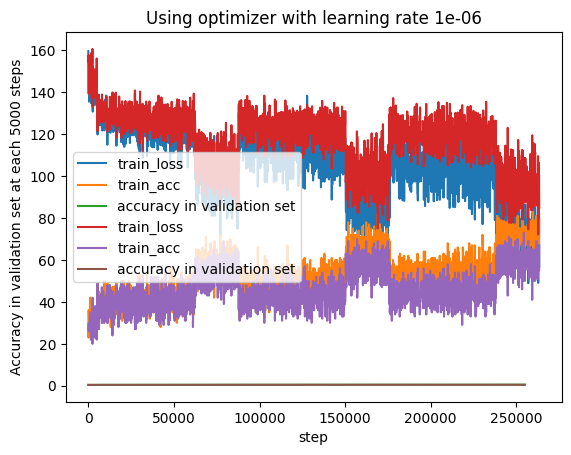

In [177]:
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

validation_input_ids = tokenized_datasets["validation"]["input_ids"]
validation_labels = tokenized_datasets["validation"]['answer']

for lr in [5e-6, 1e-6]:
    
    model = AutoModelForSeq2SeqLM.from_pretrained(model_small).to(device)
    optimizer = AdamW(model.parameters(), lr=lr)
    
    model_trained, loss_array, acc_array, eval_results = finetune_train(model=model, optimizer=optimizer, data_loader=train_dataloader, 
                                                                        epochs=3, validation_input_ids=validation_input_ids, validation_labels=validation_labels)
        
    
    steps = [100*i for i in range(len(acc_array))]
    
    plt.subplot(1, 1, 1)
    plt.plot(steps, loss_array, label='train_loss')
    plt.plot(steps, acc_array, label='train_acc')
    
    plt.xlabel("step")
    plt.ylabel("Total accuracy per 100 steps")
    
    # plt.plot(validationEpoch_loss,label='val_loss')
    plt.legend()
    
    plt.subplot(1, 1, 1)
    steps = [5000*i for i in range(len(eval_results))]
    eval_results = np.array(eval_results)
    plt.plot(steps, eval_results/len(data_points["validation"]), label='accuracy in validation set')
    
    plt.xlabel("step")
    plt.ylabel("Accuracy in validation set at each 5000 steps")
    
    # plt.plot(validationEpoch_loss,label='val_loss')
    plt.legend()
    plt.title(f'Using optimizer with learning rate {lr}')
    plt.show

In [178]:
import numpy as np
test_input_ids = tokenized_datasets["test"]["input_ids"]
test_labels = tokenized_datasets["test"]['answer']
for lr in [1e-03, 5e-04, 5e-05, 1e-05, 5e-06, 1e-06]:

    model_checkpoint = f"model/flant5_small_lr_{'{:.0e}'.format(lr)}_race_ewc_epoch2"
    model_checkpoint = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint, local_files_only=True).to(device)
    eval_results = evaluate(model_checkpoint, test_input_ids, test_labels)
    print(f"For the learing rate {lr}, performance on test set is {eval_results/len(test_labels)}")
        

  0%|          | 0/4934 [00:00<?, ?it/s]

For the learing rate 0.001, performance on test set is 0.2683421159302797


  0%|          | 0/4934 [00:00<?, ?it/s]

For the learing rate 0.0005, performance on test set is 0.2683421159302797


  0%|          | 0/4934 [00:00<?, ?it/s]

For the learing rate 5e-05, performance on test set is 0.5180381029590596


  0%|          | 0/4934 [00:00<?, ?it/s]

For the learing rate 1e-05, performance on test set is 0.5308066477503041


  0%|          | 0/4934 [00:00<?, ?it/s]

For the learing rate 5e-06, performance on test set is 0.523104985812728


  0%|          | 0/4934 [00:00<?, ?it/s]

For the learing rate 1e-06, performance on test set is 0.46838265099310905


In [176]:
for importance in [1e+00, 1e-02, 1e-04]:
    model_checkpoint = f"model/flant5_small_lr_10-4_race_ewc_importance_{'{:.0e}'.format(importance)}_epoch2"
    model_checkpoint = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint, local_files_only=True).to(device)
    eval_results = evaluate(model_checkpoint, test_input_ids, test_labels)
    print(f"For the learing rate {lr}, performance on test set is {eval_results/len(test_labels)}")

  0%|          | 0/4934 [00:00<?, ?it/s]

For the learing rate 1e-05, performance on test set is 0.520064856100527


  0%|          | 0/4934 [00:00<?, ?it/s]

For the learing rate 1e-05, performance on test set is 0.5160113498175922


  0%|          | 0/4934 [00:00<?, ?it/s]

For the learing rate 1e-05, performance on test set is 0.51925415484394


In [63]:
base_model_test_accuracy_epoch = evaluate(model, test_input_ids, test_labels)
print(f"After epoch {i+1}, accuracy is {base_model_test_accuracy_epoch/len(test_input_ids)}")

  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 6, accuracy is 0.6368058370490475


In [64]:
for i in range(3):
    model_base_fintuned_at_epoch = f"model/flant5_base_lr_10-4_race_finetuning_epoch{i}"
    model_finetuned = AutoModelForSeq2SeqLM.from_pretrained(model_base_fintuned_at_epoch, local_files_only=True).to(device)
    base_model_test_accuracy_epoch = evaluate(model_finetuned, test_input_ids, test_labels)
    print(f"After epoch {i+1}, accuracy is {base_model_test_accuracy_epoch/len(test_input_ids)}")

  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 1, accuracy is 0.5875557357113903


  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 2, accuracy is 0.6222132144304824


  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 3, accuracy is 0.6368058370490475


In [179]:
ans_id_dict

{71: 'A', 272: 'B', 205: 'C', 309: 'D'}

In [180]:
print("a")

a


In [50]:
eval_results

array([2354, 2384, 2374, 2339, 2391, 2363, 2331, 2323, 2342, 2333, 2323,
       2374, 2369, 2406, 2411, 2433, 2415, 2459, 2458, 2490, 2490, 2476,
       2445, 2479, 2478, 2489, 2466, 2434, 2471, 2471, 2481, 2490, 2502,
       2514, 2529, 2537, 2526, 2538, 2525, 2529, 2487, 2515, 2515, 2502,
       2503, 2504, 2513, 2532, 2555, 2566, 2560, 2555])

In [51]:
# #Save results to file
# with open("qa_eval_results_epochs_456.txt", "w") as fp:
#     json.dump(eval_results.tolist(), fp)
# with open("qa_loss_in_training_epochs_456.txt", "w") as fp:
#     json.dump(loss_array, fp)
# with open("qa_acc_in_traning_epochs_456.txt", "w") as fp:
#     json.dump(acc_array, fp)

In [12]:
# with open("qa_loss_in_training.txt", "r") as fp:
#     loss_array = json.load(fp)
# with open("qa_acc_in_traning.txt", "r") as fp:
#     acc_array = json.load(fp)
# with open("qa_eval_results.txt", "r") as fp:
#     eval_results = json.load(fp)

<function matplotlib.pyplot.show(close=None, block=None)>

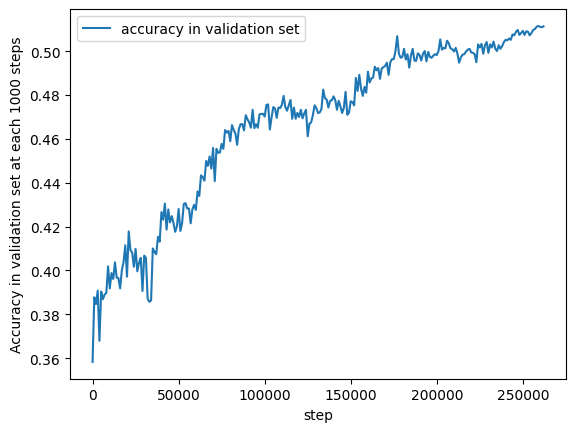

In [17]:
from matplotlib import pyplot as plt
steps = [1000*i for i in range(len(eval_results))]
eval_results = np.array(eval_results)
plt.plot(steps, loss_array, label='train_loss')
plt.plot(steps, eval_results/len(data_points["validation"]), label='accuracy in validation set')

plt.xlabel("step")
plt.ylabel("Accuracy in validation set at each 1000 steps")

# plt.plot(validationEpoch_loss,label='val_loss')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

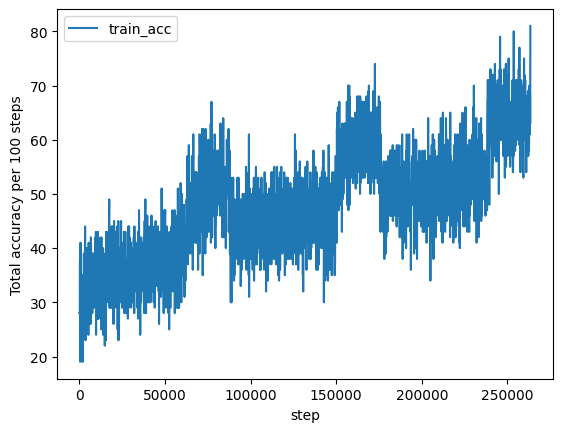

In [14]:
from matplotlib import pyplot as plt
steps = [100*i for i in range(len(acc_array))]
# plt.plot(steps, loss_array, label='train_loss')
plt.plot(steps, acc_array, label='train_acc')

plt.xlabel("step")
plt.ylabel("Total accuracy per 100 steps")

# plt.plot(validationEpoch_loss,label='val_loss')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

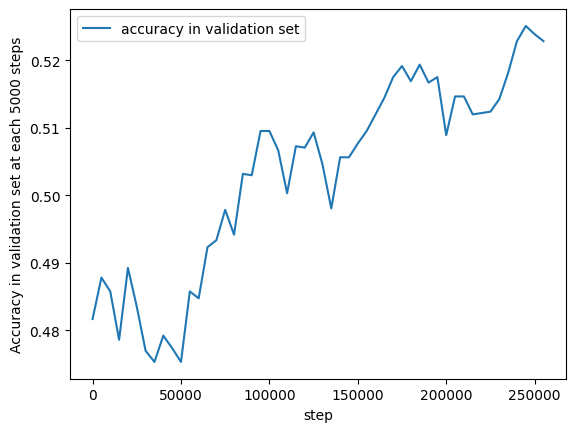

In [35]:
from matplotlib import pyplot as plt
steps = [5000*i for i in range(len(eval_results))]
eval_results = np.array(eval_results)
# plt.plot(steps, loss_array, label='train_loss')
plt.plot(steps, eval_results/len(data_points["validation"]), label='accuracy in validation set')

plt.xlabel("step")
plt.ylabel("Accuracy in validation set at each 5000 steps")

# plt.plot(validationEpoch_loss,label='val_loss')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

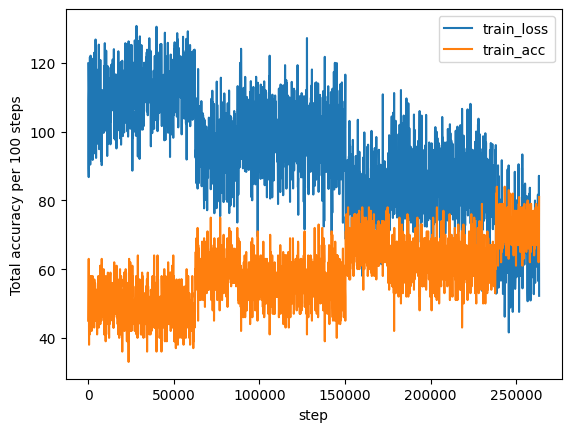

In [36]:
from matplotlib import pyplot as plt
steps = [100*i for i in range(len(acc_array))]
plt.plot(steps, loss_array, label='train_loss')
plt.plot(steps, acc_array, label='train_acc')

plt.xlabel("step")
plt.ylabel("Total accuracy per 100 steps")

# plt.plot(validationEpoch_loss,label='val_loss')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

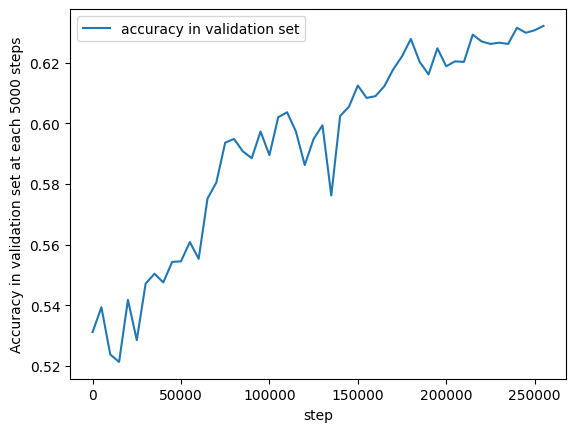

In [69]:
#Base Flan-T5
from matplotlib import pyplot as plt
steps = [5000*i for i in range(len(eval_results))]
eval_results = np.array(eval_results)
# plt.plot(steps, loss_array, label='train_loss')
plt.plot(steps, eval_results/len(data_points["validation"]), label='accuracy in validation set')

plt.xlabel("step")
plt.ylabel("Accuracy in validation set at each 5000 steps")

# plt.plot(validationEpoch_loss,label='val_loss')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

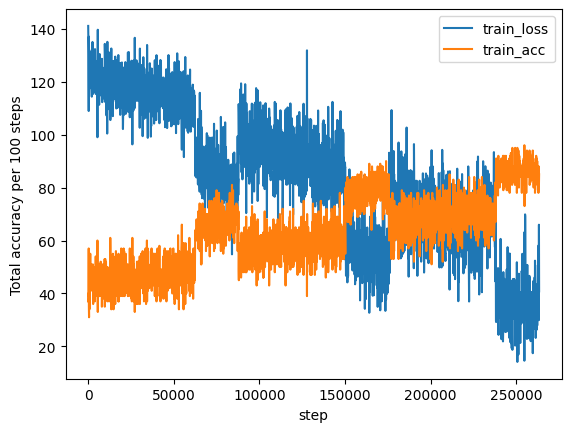

In [67]:
#Base Flan-T5
from matplotlib import pyplot as plt
steps = [100*i for i in range(len(acc_array))]
plt.plot(steps, loss_array, label='train_loss')
plt.plot(steps, acc_array, label='train_acc')

plt.xlabel("step")
plt.ylabel("Total accuracy per 100 steps")

# plt.plot(validationEpoch_loss,label='val_loss')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

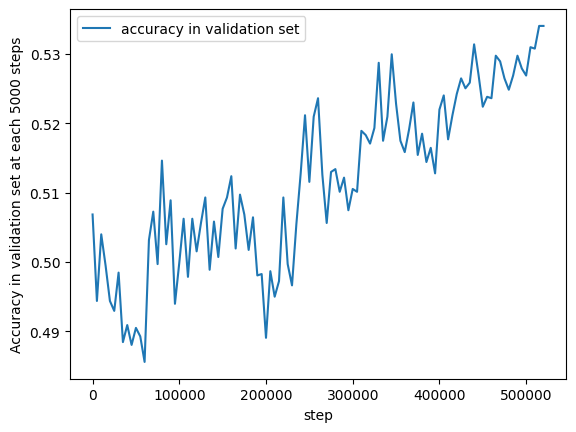

In [79]:
#Small Flan-T5
from matplotlib import pyplot as plt
steps = [5000*i for i in range(len(eval_results))]
eval_results = np.array(eval_results)
# plt.plot(steps, loss_array, label='train_loss')
plt.plot(steps, eval_results/len(data_points["validation"]), label='accuracy in validation set')

plt.xlabel("step")
plt.ylabel("Accuracy in validation set at each 5000 steps")

# plt.plot(validationEpoch_loss,label='val_loss')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

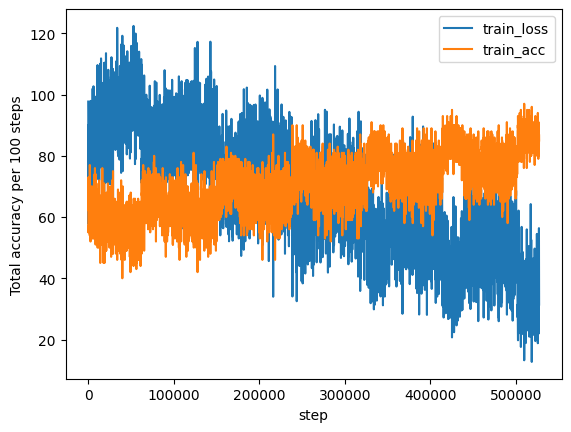

In [80]:
from matplotlib import pyplot as plt
steps = [100*i for i in range(len(acc_array))]
plt.plot(steps, loss_array, label='train_loss')
plt.plot(steps, acc_array, label='train_acc')

plt.xlabel("step")
plt.ylabel("Total accuracy per 100 steps")

# plt.plot(validationEpoch_loss,label='val_loss')
plt.legend()
plt.show

In [36]:
test_input_ids = tokenized_datasets["test"]["input_ids"]
test_labels = tokenized_datasets["test"]['answer']


In [28]:
large_model_test_accuracy = evaluate(model_large, test_input_ids, test_labels)

  0%|          | 0/4934 [00:00<?, ?it/s]

In [30]:
print(large_model_test_accuracy/len(test_input_ids))

0.7115930279691933


In [31]:
small_model_test_accuracy_based = evaluate(model, test_input_ids, test_labels)


  0%|          | 0/4934 [00:00<?, ?it/s]

In [32]:
print(small_model_test_accuracy_based/len(test_input_ids))


0.39319010944466964


In [36]:
for i in range(3):
    model_small_fintuned_at_epoch = f"model/flant5_small_lr_10-4_race_finetuning_epoch{i}"
    model_finetuned = AutoModelForSeq2SeqLM.from_pretrained(model_small_fintuned_at_epoch, local_files_only=True).to(device)
    small_model_test_accuracy_epoch = evaluate(model_finetuned, test_input_ids, test_labels)
    print(f"After epoch {i+1}, accuracy is {small_model_test_accuracy_epoch/len(test_input_ids)}")

  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 1, accuracy is 0.4641264693960276


  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 2, accuracy is 0.49432509120389134


  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 3, accuracy is 0.5087150385083097


In [39]:
for i in range(3,6,1):
    model_small_fintuned_at_epoch = f"model/flant5_small_lr_10-4_race_finetuning_epoch{i}"
    model_finetuned = AutoModelForSeq2SeqLM.from_pretrained(model_small_fintuned_at_epoch, local_files_only=True).to(device)
    small_model_test_accuracy_epoch = evaluate(model_finetuned, test_input_ids, test_labels)
    print(f"After epoch {i+1}, accuracy is {small_model_test_accuracy_epoch/len(test_input_ids)}")

  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 4, accuracy is 0.4983785974868261


  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 5, accuracy is 0.5127685447912445


  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 6, accuracy is 0.5214835832995541


In [78]:
for i in range(0,12,1):
    model_small_fintuned_at_epoch = f"model/flant5_small_lr_10-4_race_finetuning_epoch{i}"
    model_finetuned = AutoModelForSeq2SeqLM.from_pretrained(model_small_fintuned_at_epoch, local_files_only=True).to(device)
    small_model_test_accuracy_epoch = evaluate(model_finetuned, test_input_ids, test_labels)
    print(f"After epoch {i+1}, accuracy is {small_model_test_accuracy_epoch/len(test_input_ids)}")

  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 1, accuracy is 0.4641264693960276


  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 2, accuracy is 0.49432509120389134


  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 3, accuracy is 0.5087150385083097


  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 4, accuracy is 0.4983785974868261


  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 5, accuracy is 0.5127685447912445


  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 6, accuracy is 0.5214835832995541


  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 7, accuracy is 0.49918929874341306


  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 8, accuracy is 0.5097284150790433


  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 9, accuracy is 0.516214025131739


  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 10, accuracy is 0.5214835832995541


  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 11, accuracy is 0.5210782326712606


  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 12, accuracy is 0.5249290636400487


In [37]:
for i in range(0,6,1):
    model_small_fintuned_at_epoch = f"model/flant5_small_lr_1e-05_race_distill_1best_epoch{i}"
    model_finetuned = AutoModelForSeq2SeqLM.from_pretrained(model_small_fintuned_at_epoch, local_files_only=True).to(device)
    small_model_test_accuracy_epoch = evaluate(model_finetuned, test_input_ids, test_labels)
    print(f"After epoch {i+1}, accuracy is {small_model_test_accuracy_epoch/len(test_input_ids)}")

  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 1, accuracy is 0.4637211187677341


  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 2, accuracy is 0.496149169031212


  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 3, accuracy is 0.5099310903931901


  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 4, accuracy is 0.5204702067288204


  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 5, accuracy is 0.5237130117551683


  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 6, accuracy is 0.5314146736927442


In [40]:
model_base = "google/flan-t5-base"
tokenizer_base = AutoTokenizer.from_pretrained(model_base)
model_base = AutoModelForSeq2SeqLM.from_pretrained(model_base).to(device)

In [41]:
base_model_test_accuracy = evaluate(model_base, test_input_ids, test_labels)
print(base_model_test_accuracy/len(test_input_ids))


  0%|          | 0/4934 [00:00<?, ?it/s]

0.6035670855289825


In [184]:
model.eval()
input_ids = tokenized_datasets["test"]["input_ids"]
labels = tokenized_datasets["test"]['answerKey']
model_outputs = []
probability_output = []
for i in range(0, len(input_ids)):
        # print(input_ids[i])
    
        test_tensor = torch.unsqueeze(torch.tensor(input_ids[i]), 0).to(device)
        preds = model(input_ids=test_tensor, decoder_input_ids=torch.tensor([[model1.config.decoder_start_token_id,]]).to(device))      
        preds_prob = []
        for t in ans_id_dict.keys():
            preds_prob.append(torch.nn.functional.softmax(preds.logits, dim=-1)[...,t][0][0].item())
            
        model_outputs.append(index_to_ans[np.argmax(preds_prob)])
        probability_output.append(preds_prob)
        
result = 0
for i in range(min(len(model_outputs), len(labels))):
    if model_outputs[i] == labels[i] or ans_to_index[model_outputs[i]] == labels[i]:
        result += 1
result
#946

1049

In [185]:
# torch.save(model.state_dict(), "model/flant5_small_lr_10-5_qa_finetuning")
# model.save_pretrained("model/flant5_small_lr_10-5_qa_finetuning")

In [129]:
model_distill = AutoModelForSeq2SeqLM.from_pretrained(model_small).to(device)

In [130]:
optimizer_distill = AdamW(model_distill.parameters(), lr=1e-4)
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler_distill = get_scheduler(
    name="linear", optimizer=optimizer_distill, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [131]:
model_distill.train()
loss_array_distill = []
acc_array_distill = []
eval_results_distill = []

loss_per_100 = 0
acc_per_100 = 0
c = 0
for epoch in range(num_epochs):
    for batch in tqdm(train_dataloader):
        # print(batch)
        # labels = torch.tensor(, requires_grad=True).to("cuda")
        labels = batch["labels"].clone().detach().requires_grad_(True).to(device)
        # labels.retain_grad()
        labels = labels.squeeze()
        labels = torch.nn.functional.softmax(labels, dim=-1)
        # print(labels)
        # labels = batch['labels'][0].to(device)
        batch = batch['input_ids'].to(device)
        # print(batch)
        outputs = model_distill(batch, decoder_input_ids=torch.tensor([[0]]).to(device))
        # print(outputs)
        loss_fct = torch.nn.CrossEntropyLoss()
        logits = outputs.get("logits")

        preds = logits[0, 0, tuple(list(ans_id_dict.keys()))]
        # print(preds)
        # print(labels)
        if torch.argmax(labels) == torch.argmax(preds):
            acc_per_100 += 1
            
        loss = loss_fct(preds, labels)
        # loss.retain_grad()
        loss_per_100 += loss.item()
        if c%100==99:
            print(loss_per_100)
            loss_array_distill.append(loss_per_100)
            acc_array_distill.append(acc_per_100)
            
            loss_per_100 = 0
            acc_per_100 = 0
        
        optimizer_distill.zero_grad()
        loss.backward()
            
        optimizer_distill.step()
        lr_scheduler_distill.step()
        # progress_bar.update(1)
        c += 1
        if c%5000==4999:
            eval_result = evaluate(model_distill, validation_input_ids, validation_labels)
            eval_results_distill.append(eval_result)
            # print(eval_result)
    model_distill.save_pretrained(f"model/flant5_small_lr_10-4_race_distill_epoch{epoch}")
    


  0%|          | 0/87866 [00:00<?, ?it/s]

142.2494912147522
137.68477314710617
138.2514117360115
138.56166273355484
140.22122812271118
141.90746599435806
135.55826205015182
139.7240738272667
140.17902660369873
137.66256266832352
137.59213465452194
133.78750878572464
135.98177728056908
138.1237980723381
136.31721058487892
135.87784492969513
135.0477465391159
129.1773834824562
139.59594810009003
137.94374787807465
135.1852204799652
126.8271074295044
138.62954926490784
137.56891244649887
138.8472000360489
135.72265714406967
133.47306191921234
139.8867478966713
137.30359995365143
133.30006402730942
138.96161568164825
134.61381512880325
136.65293329954147
133.49454367160797
136.38131254911423
139.1307190656662
136.47042548656464
132.73753494024277
134.5822727382183
137.4556286931038
137.47565668821335
135.15318846702576
135.9791784286499
135.0097994208336
131.55863907933235
135.41521680355072
133.8093220591545
133.5283768773079
128.937290340662


  0%|          | 0/4887 [00:00<?, ?it/s]

138.67970818281174
129.23445773124695
128.28146114945412
132.3005849123001
131.96850043535233
116.21117889881134
135.86333814263344
131.402100533247
134.6377598643303
129.52969998121262
129.3761466741562
130.94267949461937
123.6032672226429
136.16923561692238
132.80400931835175
127.28799200057983
134.33570683002472
127.13711547851562
125.94416388869286
131.62199276685715
127.9666556417942
127.44008302688599
133.21665713191032
126.57783913612366
129.57268887758255
130.0517654120922
131.47754818201065
132.26787734031677
128.53087604045868
121.111064478755
123.1434675604105
127.14508602023125
130.4995390623808
126.34020963311195
130.42630749940872
124.11519999802113
128.90927359461784
123.94834816455841
128.50133690238
130.6608588397503
123.57890821993351
125.92153352499008
128.93776178359985
128.5905104279518
131.71769186854362
123.98326805233955
129.9824174940586
124.3192160576582
132.68139991164207
130.1824845969677


  0%|          | 0/4887 [00:00<?, ?it/s]

131.3661721944809
128.9045622497797
127.76660150289536
130.35833007097244
124.96458320319653
128.4621658027172
130.58468908071518
129.7464093118906
127.04611018300056
122.16526241600513
130.09371453523636
132.68456971645355
120.9472744166851
126.83864033222198
128.27767911553383
125.35453861951828
125.8017807006836
125.00693672895432
130.2162863612175
124.24584838747978
127.51972967386246
127.8345900028944
125.68294161558151
125.98286163806915
122.84094688296318
124.98486867547035
127.48935870826244
126.85965767502785
120.31781986355782
118.97104812413454
117.37991261482239
124.13197329640388
133.64575698971748
125.18836358189583
124.29096138477325
128.78222411870956
128.87577733397484
124.84434121847153
125.56834918260574
119.53911256790161
120.70459149777889
125.21410551667213
130.40883848071098
125.39266879856586
128.58139789104462
119.23421096801758
126.70355622470379
129.47739323973656
120.41016671061516
130.647706925869


  0%|          | 0/4887 [00:00<?, ?it/s]

127.54899603128433
128.3392649590969
133.42797881364822
122.19647628068924
117.76192453503609
125.50933489203453
122.99423868954182
128.89732010662556
123.65206557512283
125.16129732131958
119.35402902215719
126.49421912431717
128.94025713205338
114.43650893867016
118.87809093296528
115.53809474408627
113.3882378488779
120.63937146961689
125.70931755006313
118.88316337764263
125.5765855461359
126.4919703900814
124.01733103394508
119.70739883184433
130.44356659054756
117.92832027375698
125.84892664849758
123.9631908684969
123.53517839312553
126.10346820950508
123.20068238675594
126.6860103905201
122.164664670825
124.34917232394218
122.66867271065712
118.63368119299412
127.41874569654465
117.12356877326965
119.17422018945217
117.3919241130352
127.89034867286682
115.60066471993923
119.50307983160019
123.90608222782612
123.8859438598156
124.8847866654396
127.00422324240208
124.50834256410599
124.8208096921444
120.96928560733795


  0%|          | 0/4887 [00:00<?, ?it/s]

124.17176721990108
119.33409199863672
126.32688683271408
119.08133418858051
116.16848894953728
126.45940965414047
122.84027209877968
122.93401108682156
118.9369486272335
122.32781273126602
119.28771063685417
111.24434743821621
123.05515369772911
122.97314397990704
124.66192203760147
121.77113933861256
123.07990948855877
124.04024546593428
130.27212193608284
118.35783645510674
114.83738221973181
124.73568388819695
115.07827021181583
124.1131450086832
119.92029727250338
123.00956486165524
124.6014698036015
124.586365878582
119.72837507724762
123.2628308236599
115.73888203501701
118.26115475594997
125.92645151913166
126.53724619746208
113.9921763241291
120.31613129377365
126.18608748912811
121.52903352677822
117.44016221165657
125.68791948258877
115.79498441517353
119.3645261079073
108.32327169179916
131.0159937441349
122.08471189439297
126.7268930375576
123.63795128464699
118.26267702877522
116.20247782766819
122.04580271989107


  0%|          | 0/4887 [00:00<?, ?it/s]

116.57822824269533
126.57569383084774
125.09346848726273
121.61208313703537
128.665643543005
119.37330318242311
121.51036346703768
118.80799168348312
124.12159478664398
110.55953513085842
115.49423614144325
118.04825957491994
116.57057769596577
122.56656940281391
123.42450687289238
115.78811806440353
120.17867934703827
126.24719722568989
123.740429520607
123.09802082180977
118.25293977558613
116.71819059550762
122.15623053908348
131.0836223065853
126.24040260910988
117.62328846007586
127.35813696682453
124.0044130384922
115.43786892294884
123.45421892404556
118.95610058307648
122.37398919463158
128.95024353265762
120.70199182629585
128.20679423213005
120.40551868081093
115.56695248186588
117.47459053993225
123.32672184705734
130.0492722839117
120.31216415762901
113.4014737457037
123.24449920654297
119.16840475797653
126.21584171056747
116.12983456254005
116.05918927490711
116.59477889537811
126.88810344040394
117.78546721115708


  0%|          | 0/4887 [00:00<?, ?it/s]

120.1101526170969
114.12900838255882
119.35941098630428
132.2096994444728
117.49180659651756
115.61573296040297
127.72381448745728
116.88620233535767
116.02526768296957
127.91134813427925
119.13294440507889
114.64011976867914
127.95964220166206
107.21654509007931
122.42521767318249
116.30525051057339
117.43573554605246
120.88578194379807
120.21021309494972
113.04445818439126
119.49729657173157
122.07794517278671
123.12692560255527
119.8698779642582
127.96174436807632
118.12843522429466
115.25833334028721
120.64830231666565
117.2862539589405
118.58738910406828
117.16753435134888
118.34087662398815
120.37443616241217
115.15189656615257
119.6500273346901
118.8021252155304
117.90531207621098
128.63114823400974
124.83160038292408
126.3440859913826
120.58331713080406
121.72144293040037
121.99922597408295
122.62166561186314
112.06317926943302
126.99251563847065
123.24048855900764
124.87400209903717
112.93553419411182
110.93373745679855


  0%|          | 0/4887 [00:00<?, ?it/s]

125.45897506177425
119.88648493587971
116.66045209765434
113.4843995347619
116.59854112565517
126.56100569665432
120.08867219090462
123.67167937755585
136.2096674144268
119.23534707725048
118.37380628287792
118.80715009570122
121.11825160682201
113.46674713492393
119.87506188452244
124.20969235897064
116.41574041545391
112.60871832072735
120.1597148515284
115.55387587100267
128.16772791743279
117.30010356009007
122.51198513060808
119.10991315543652
119.47613409161568
112.07289231941104
116.96489235013723
112.24506752938032
118.10132659971714
115.78300143778324
120.88241459429264
116.19402898102999
106.67624321207404
124.36960129439831
111.61771158874035
114.74585811048746
115.31381948292255
127.52241154015064
123.73651540279388
120.29678416252136
117.0283090621233
124.48978072404861
120.44777055084705
120.8076466023922
107.05502786301076
116.49360081553459
116.9762669801712
118.05080384016037
121.2713214457035
114.13440068811178


  0%|          | 0/4887 [00:00<?, ?it/s]

124.9887076318264
127.48415940254927
120.78816497325897
118.82344314455986
118.49603878706694
121.64512822031975
108.39923255890608
110.75061290338635
113.24765365570784
118.97444674372673
120.63175773620605
120.96623095870018
120.58042794466019
128.66760225594044
119.0419500246644
118.66300907731056
122.40669599175453
109.55733697861433
117.93053307384253
123.7815565392375
123.35032537579536
116.39410860836506
110.34334718436003
123.10929449647665
120.04203927516937
124.65258564800024
118.98915274441242
118.21795265376568
121.04270067811012
124.90374091267586
113.81811012327671
118.54961732029915
122.9365758895874
122.60180629789829
117.06727436184883
114.69481740519404
115.39812272787094
116.65410715341568
113.29966948181391
121.39764800667763
115.85339081287384
126.96298494935036
123.68846814334393
118.26742914319038
116.31831367313862
108.77100526541471
106.71414910256863
120.9445411041379
110.28758660703897
125.49497106671333


  0%|          | 0/4887 [00:00<?, ?it/s]

116.6188323572278
118.6671436727047
111.43123785406351
108.66287868469954
111.98354423046112
108.78972697257996
106.56252831965685
122.158138230443
121.87916155532002
118.75284320116043
119.55075354874134
117.83826590329409
104.55845932662487
112.09423422068357
125.22387211769819
127.50298796594143
122.90155424177647
119.76238352060318
115.06073937192559
118.99147138744593
121.02885085344315
122.59243033826351
111.06450827419758
125.08644458651543
123.30682104825974
123.45851668715477
123.99902403354645
126.14685812592506
121.46912506222725
108.50009403377771
115.84572514146566
112.54717200249434
113.94743812084198
127.94468948245049
121.06972020864487
118.93228878080845
113.34216599911451
116.0503349006176
120.09975036978722
100.4327338412404
119.06688050180674
111.74730068072677
119.5542295947671
123.14539575576782
121.26937073469162
113.66267235577106
119.71646448969841
110.56259979307652
110.58817080780864
117.7458997219801


  0%|          | 0/4887 [00:00<?, ?it/s]

111.83233742415905
111.03293454647064
122.54310756921768
119.25842541456223
118.78250439465046
113.15929786860943
119.96765921264887
122.43352348357439
118.73305441439152
114.567960947752
122.44134658575058
109.59650412201881
116.5348729044199
116.52913630008698
112.46473623812199
115.22871641814709
120.30461229383945
116.84951347857714
123.32089614868164
113.45464291423559
129.3162958920002
124.50294995307922
110.38338221609592
106.63967229425907
117.24920856207609
122.34047535061836
114.27730935811996
98.4315624833107
118.25258573144674
119.42295986413956
114.35925796627998
127.17356480658054
111.12630943953991
112.72817772626877
113.67737217247486
119.40772615373135
113.92594808340073
121.41797909140587
113.90382247418165
108.61835743486881
123.71073713898659
119.53942093253136
113.98854828625917
117.8615140914917
111.01558628678322
108.0966761559248
107.81373015791178
110.55826133862138
106.82318559288979
117.38917621225119


  0%|          | 0/4887 [00:00<?, ?it/s]

124.46980602294207
116.0112681761384
118.5476381778717
114.7284959256649
114.85982298105955
121.88651633262634
109.42565575242043
119.46484740078449
122.57482567429543
114.23176987469196
110.47841084375978
111.7933727428317
112.36667235940695
122.16175743937492
117.35297548770905
119.10099440813065
112.19385962933302
125.5274151340127
123.53477062284946
121.73961019515991
118.04230682551861
117.70136247575283
112.70004554837942
116.65304715931416
122.20199748128653
115.55624789185822
107.68227541260421
106.32936956733465
108.9155411273241
118.4285536184907
117.57663454115391
118.19633332267404
107.40906600654125
125.07883143424988
121.8153690546751
118.22105960547924
117.91847122460604
107.06242102384567
114.74005651473999
114.83983759582043
113.57895340584219
116.11301127821207
113.95778722316027
123.09884649515152
115.37902408838272
120.02641585469246
126.78101119399071
117.23218148946762
115.31546100229025
117.95097863674164


  0%|          | 0/4887 [00:00<?, ?it/s]

110.64396899193525
108.60242208093405
121.94045040011406
114.16577190160751
117.49134503304958
119.11504238843918
120.38706678897142
105.19408217817545
116.66932466253638
110.8990489244461
107.6294881850481
118.4704233109951
120.64329229295254
118.53277436643839
114.19503945112228
112.63940500095487
107.27178518846631
121.7814318202436
106.00473686307669
113.67221396788955
131.6348757147789
116.21605046093464
116.23187313973904
120.74979576468468
122.19751184433699
113.119543120265
108.42210192233324
108.29429293423891
114.6023301128298
105.99660731479526
104.91784050129354
96.90596903301775
90.97366819158196
99.18491510301828
106.92826296389103
105.2451936379075
98.68268132209778
102.19055393338203
107.80130901932716
87.6977587947622
88.61128836590797
100.33357679657638
84.06028605159372
105.03552291169763
91.57294031605124
107.67209567688406
99.051941646263
95.40083448961377
92.81946394592524
101.91845885850489


  0%|          | 0/4887 [00:00<?, ?it/s]

100.59349954873323
86.15921948850155
100.98657113034278
100.58649355359375
104.98331309109926
97.27298615500331
106.99909593164921
92.89011889696121
103.25104656815529
94.8533531986177
105.80403296649456
87.44478339701891
103.09793118201196
105.42223543487489
86.3339375257492
100.89022336900234
85.82621036469936
93.74703106377274
94.79886187240481
95.69649457931519
97.16205860301852
96.9927734611556
109.93051696382463
101.52815513126552
88.59702510014176
91.22999314963818
99.35430586710572
88.46504714619368
81.76429699035361
94.31388531625271
96.93330454081297
103.6049991697073
87.54260864853859
84.35463590919971
73.98192228935659
104.23340363614261
100.27507428638637
97.96961914747953
88.66620820946991
98.45833547413349
98.60173319745809
102.17793449759483
87.9383338727057
106.3143831025809
110.05943020060658
93.43867483735085
95.82189282588661
102.61590855196118
96.032958060503
98.9771100282669


  0%|          | 0/4887 [00:00<?, ?it/s]

90.1890753172338
86.2898657657206
87.48235482722521
95.24809488281608
99.7354646064341
92.08673468977213
105.59821574389935
96.49205977842212
91.69711864739656
94.59196517057717
90.83606475777924
99.00654359161854
94.33256869297475
92.25253669917583
98.73395127430558
80.71810305304825
98.68675429932773
86.50299764052033
82.94103739783168
91.27673061471432
97.48150298371911
98.440903859213
96.62516886368394
86.40616675466299
94.07777229137719
99.86497989669442
108.91031501442194
95.90591041743755
97.5951812081039
92.81558298505843
97.14853233471513
96.49020091071725
99.04627935215831
97.06456223875284
93.81158981472254
94.82674586214125
109.34033006615937
98.55085223540664
80.63680990226567
88.62602159008384
94.46125634014606
96.0659155882895
91.50185116752982
89.76766767911613
97.75360447354615
85.11223675403744
94.67736673727632
89.43903890252113
79.93160926550627
88.04766787961125


  0%|          | 0/4887 [00:00<?, ?it/s]

101.36222450435162
69.96914271265268
111.16121090296656
95.59885161370039
91.05905755702406
93.99679627642035
105.12422940135002
95.90186313167214
92.07289743889123
91.44764752686024
95.59270993992686
101.34849960636348
93.36543809995055
100.7415330838412
96.7794893104583
86.59123147651553
92.30802701413631
78.84986165165901
73.11588808335364
97.98745609633625
87.3857661113143
95.26051308959723
82.45341300778091
89.96552629116923
95.61710119619966
93.87162612751126
111.65174256265163
101.80940507352352
93.77652363851666
97.21652745269239
102.28470988478512
88.77086144499481
95.61334989219904
92.77448106557131
81.77161059901118
100.23642141371965
94.59992868080735
91.32377419248223
99.93837632145733
92.83570284768939
104.11030527576804
89.02616273611784
88.08756999671459
99.38700070977211
100.11219410225749
93.47344883158803
89.6237476952374
103.23791890963912
95.67956760525703
91.06361491978168


  0%|          | 0/4887 [00:00<?, ?it/s]

95.53022579848766
97.97172894142568
94.83821861818433
87.14517121389508
88.8516556918621
110.47307499498129
99.91053415834904
85.82945503108203
103.4779535792768
84.78586368262768
87.6647436991334
66.98611653037369
88.88522271625698
76.10273540206254
78.64302143454552
94.17483239248395
92.96985470503569
90.37056926265359
90.13138668239117
103.81586548686028
80.80906450003386
92.43146164342761
96.08243905380368
95.58356094919145
100.50770568102598
86.9079363271594
89.21655952557921
87.46565024089068
89.04678199067712
93.17969462834299
89.71761869639158
88.41113345697522
91.00273920968175
81.73299146536738
87.24521143734455
89.13585871830583
93.15582260675728
101.62336908467114
87.1406322773546
84.1782886851579
86.00683800317347
68.17200686968863
89.16165884397924
90.37785420566797
90.3121583238244
97.16405476629734
84.48044550791383
94.12933094240725
96.60310206376016
90.2853776589036


  0%|          | 0/4887 [00:00<?, ?it/s]

96.54516638815403
98.34399529919028
88.33051797002554
81.15835576504469
102.44894352555275
87.3637096658349
98.56692141480744
89.40896417293698
93.11492457613349
87.93653694912791
95.43728868477046
77.98241789638996
94.41865800693631
91.66973649710417
94.48369212541729
93.02258629724383
82.70512067526579
81.70744051784277
86.6630586143583
89.02061028033495
89.55049754213542
89.70077653415501
59.55699263326824
86.42586051113904
100.04313869215548
91.55858598649502
92.69844455458224
106.51534719951451
77.54993198346347


  0%|          | 0/87866 [00:00<?, ?it/s]

98.35612040571868
110.63517986238003
113.45508976280689
102.1818875297904
105.248739823699
113.54661467671394
117.98841962218285
105.027354195714
115.42944167554379
119.0823178961873
108.44843655079603
118.87173771858215
101.61804264038801
119.3281628638506
100.47022765129805
123.07540205866098
116.07562576979399
104.75478818267584
104.77174431085587
112.11679685674608
103.78842771053314


  0%|          | 0/4887 [00:00<?, ?it/s]

104.87242452055216
100.93695494905114
112.21741645410657
116.40896949917078
118.6574086099863
107.39693893305957
115.25131899118423
115.27156010270119
104.37016677111387
116.71020691655576
110.01193413883448
114.77815793454647
109.99591520428658
111.32310004904866
104.23467575386167
106.01495485380292
114.14185175299644
114.00928670167923
118.4781219959259
113.95060653239489
112.17525403946638
117.56760810315609
107.87934963032603
121.37563631683588
98.48868093639612
119.40028424561024
109.82333306968212
106.99224454164505
111.76171278953552
109.54763718880713
104.51564601063728
119.85818827152252
106.86451018974185
102.49250647053123
99.5545288156718
115.99851694889367
113.29390367865562
106.82096480578184
102.1092828065157
104.4247661754489
94.62412064149976
105.94600974954665
103.58374857529998
103.36884294822812
107.44215308502316
119.64546789973974
107.37063623219728
109.82411237433553
99.27176008373499
114.27670111320913


  0%|          | 0/4887 [00:00<?, ?it/s]

93.86432173103094
113.49711902812123
108.81169295683503
95.66771442815661
101.49914054945111
98.14090614765882
102.52297890931368
108.39620458334684
85.1625149846077
98.00727961212397
113.24214912950993
103.28065529838204
99.0480310767889
106.38630221039057
107.96265624463558
107.50759240239859
111.69671107083559
96.2201858498156
95.18767651543021
97.85615226253867
101.35115098580718
106.97114155814052
92.8308314345777
107.65760733559728
98.3050664961338
109.69985467754304
110.09261975809932
113.68303316831589
105.13108926266432
112.18390971422195
101.05828224867582
105.1318872012198
109.97552644833922
102.82662454247475
103.43949430808425
105.04852847009897
98.95863031875342
110.57725834101439
98.93073587864637
108.79826397448778
106.78827103972435
81.03987996838987
115.35662047564983
107.43801172450185
98.05395443737507
92.72187692672014
116.2662899363786
110.02650581672788
106.26998859271407
101.21710453927517


  0%|          | 0/4887 [00:00<?, ?it/s]

100.89304035902023
98.69512293487787
105.46754179149866
99.66600668802857
97.0233562272042
95.64123990572989
111.81353272497654
90.18983679264784
89.44438844546676
103.58878503739834
96.05585043132305
99.06695730611682
109.80546678975224
106.51184545084834
106.86285652965307
105.15307320281863
105.32506553083658
102.97509964928031
98.56789914146066
99.62183533608913
94.16677203401923
104.16385762766004
100.93290303647518
110.12542425096035
93.0848433393985
116.9360388815403
102.75387433171272
105.62156044878066
107.61121273040771
113.7317821867764
105.11934707313776
112.88115152344108
84.41691556759179
100.50927318818867
104.52040423825383
97.44553277269006
104.9784172475338
97.02383622527122
99.89457671716809
103.18412950634956
108.44966111704707
100.25092474371195
89.82781192660332
96.88613149616867
93.86552233621478
78.41569582559168
91.51851173117757
97.48792947083712
102.19936500862241
101.59932911768556


  0%|          | 0/4887 [00:00<?, ?it/s]

100.50030386075377
100.40656975284219
86.54623042419553
116.0951506793499
93.9521529302001
103.46075662225485
98.8404447697103
97.65972580760717
118.99848534166813
100.36629535630345
96.99030740186572
105.96166940778494
93.88232109695673
89.9123072270304
102.30312053114176
102.00556561350822
91.04202608205378
85.4647068362683
93.11666698008776
102.60015412420034
97.49960077926517
94.52118704095483
105.98680686205626
104.82790440320969
106.12558967620134
109.66527131199837
100.67991701327264
104.6812570951879
101.34172100201249
104.69842486083508
93.25306247547269
103.4364716745913
104.58745491318405
91.46325880289078
98.81113476678729
91.43004044145346
106.28259798139334
103.41697684302926
95.95880319923162
93.2286915089935
83.67121384479105
104.4350565019995
105.34422293677926
97.40540024638176
104.78821804374456
92.2008993960917
114.77914950996637
105.32028172910213
89.06702441722155
84.22423871792853


  0%|          | 0/4887 [00:00<?, ?it/s]

98.97872587293386
85.16993922367692
108.81451471708715
101.68256741482764
99.20325015485287
94.84153646696359
107.16072653979063
95.1647308729589
91.79878093022853
93.50001730769873
87.53032874315977
106.36091599613428
101.92035859823227
93.34721487015486
94.95259530097246
98.90142791718245
98.85555562376976
105.76753887534142
103.26522499322891
100.0848370231688
96.56093559414148
74.9857679978013
111.52783204615116
89.87645494192839
99.95702366903424
106.12494775652885
94.77416789717972
83.14955240860581
99.46138555184007
90.0501717813313
106.39453451149166
95.29926947876811
109.43855911679566
102.76174149662256
92.50748719461262
103.21635296940804
95.9604612160474
82.52318011969328
92.43125900812447
92.73105481639504
88.75878733769059
86.71693751588464
99.05912518501282
96.1159408017993
85.69775692000985
96.8059816872701
101.82499927282333
103.243133418262
109.71701915562153
85.20493452996016


  0%|          | 0/4887 [00:00<?, ?it/s]

95.97495612129569
93.28222955018282
114.69092854484916
98.39405938237906
107.72341471165419
102.2653760612011
98.09896384552121
93.42623880133033
106.82154583185911
93.75660967826843
98.96889078617096
99.826007489115
98.04152220487595
102.17941578477621
104.83910941332579
80.0465190038085
102.26731475442648
99.08589319698513
109.99846763163805
99.1416874974966
89.95775002986193
109.15932594612241
94.00474785268307
107.46895691379905
88.97984164953232
89.09075301140547
91.16241445951164
103.20115704461932
97.67500994727015
94.99250116199255
81.45971618592739
96.86205284297466
110.80069841071963
94.87453224509954
90.72086424008012
93.96766099333763
95.58449912816286
94.47008419595659
95.46034640818834
86.84028726816177
98.4138502907008
106.18584207817912
81.45811052620411
99.6658032014966
88.2334876768291
100.38464243058115
110.05530845746398
85.44860269129276
83.89843701943755
109.55660805851221


  0%|          | 0/4887 [00:00<?, ?it/s]

94.89555076509714
103.52737564593554
94.40651544369757
102.07525977864861
86.74804522097111
89.01315745711327
98.81043345853686
96.1972037255764
85.16048954240978
88.09466008841991
88.47027334570885
99.01591453142464
89.46603399887681
101.10649634152651
101.27111470326781
104.39544923231006
103.72697317972779
95.91984331794083
101.53009621053934
94.95885749720037
92.37030308321118
94.94716738536954
96.72140742093325
95.42498004809022
110.42089720442891
102.9041001740843
99.56491253525019
92.76578998193145
89.76350260525942
96.74426673166454
103.57335902750492
89.39225470274687
98.71362931467593
75.07433211058378
106.80677687376738
94.38860606402159
107.4073860310018
113.74681812524796
97.82986073382199
93.88000441342592
95.37335641309619
93.38841884210706
99.35337313637137
92.37427272647619
97.00918475538492
83.87406015023589
81.72775857150555
87.7575319595635
110.83479130640626
101.80556017532945


  0%|          | 0/4887 [00:00<?, ?it/s]

96.67213293910027
92.31186657771468
99.57879424048588
98.17511385679245
86.2274885699153
94.50388776510954
88.210304800421
90.357242166996
94.42950461246073
98.96489235013723
84.66533407568932
91.06615449488163
98.29752887785435
92.85941807553172
84.77786327525973
91.27494067698717
112.7455894201994
98.81286316365004
95.33861326426268
94.78042887151241
106.24229960516095
93.9470024742186
82.54246439784765
74.78249634429812
92.55192614439875
98.11909515038133
91.0538515560329
103.69228020496666
85.03187200427055
113.50270992424339
95.57951954379678
98.23860043287277
84.11854449659586
91.66161638312042
87.1685720058158
86.400121640414
81.21776534616947
97.06027119606733
96.00425127334893
95.24636161513627
87.36384123936296
102.31643039360642
104.15129660069942
101.9017136618495
96.94036692753434
95.13346912711859
93.49144717492163
91.15015281736851
96.11944712884724
96.40229696035385


  0%|          | 0/4887 [00:00<?, ?it/s]

78.34146538376808
99.97934489697218
98.71071408316493
107.13985149562359
96.13048186711967
82.58908600360155
99.08451204374433
86.94288246333599
102.82266809791327
90.19930475577712
91.09261579811573
95.04666175320745
102.295483879745
102.00442410912365
90.73893686383963
90.60008583590388
80.76415550522506
101.13223244436085
97.6311433762312
88.28355890139937
98.17757625132799
109.25152804516256
91.86167093738914
87.56255736015737
76.6781324967742
99.56353510916233
86.40779624506831
88.00385199300945
97.34759138524532
92.16350995004177
91.04242050088942
90.53178873285651
84.74816115759313
92.67347571626306
72.1062208712101
88.104318279773
102.81204615905881
93.43626902624965
94.48169353231788
91.06992829591036
88.68081432953477
92.45268945395947
82.24370472878218
99.52357707545161
109.63765078410506
91.63565352000296
93.42373323813081
89.58015260286629
86.86721668578684
106.58664735034108


  0%|          | 0/4887 [00:00<?, ?it/s]

90.97975733876228
85.28900046646595
91.04083164781332
106.9389406517148
108.22315772809088
102.6968033593148
96.09595066681504
87.7465284820646
90.11792845092714
84.41143815219402
76.84590982180089
89.02599786967039
104.26860539056361
97.1366172619164
87.56810207478702
87.13785045221448
91.68419216945767
97.12037229910493
86.8406121917069
82.92793080210686
95.15197889879346
95.75009275600314
96.90718026459217
91.05393438972533
95.00379881635308
90.5300905816257
93.89813402667642
88.46029917337
79.75267528556287
82.82084721978754
80.3499052952975
99.81910777837038
101.00213593244553
99.43794433400035
88.43396666646004
98.83666895702481
86.70545805059373
87.94701638072729
86.12206917861477
98.88220272958279
88.69132649712265
88.87642819434404
94.23952198773623
85.69495233893394
102.49374283850193
86.70367870852351
94.37007269263268
96.11070172861218
88.36806876584888
109.72327566891909


  0%|          | 0/4887 [00:00<?, ?it/s]

97.15524848178029
89.64573999494314
83.54395425319672
103.55680419132113
96.43416596204042
84.61395695060492
82.3862492851913
82.20070914924145
96.28101323544979
94.9234464969486
101.80292705819011
89.39621668681502
76.14861780405045
96.39251869358122
95.88832518830895
89.37646556645632
93.25065142847598
83.17505925893784
85.64894043654203
98.77149311825633
99.91879354044795
89.07858326472342
89.86256483569741
81.09565013833344
87.8221549615264
85.26205068640411
71.84001431241632
72.92879864573479
95.50164671987295
109.83039697259665
85.29955771565437
96.68413344398141
83.25560220144689
93.15676050679758
87.91355170216411
70.89153021760285
93.36199113726616
97.46539106220007
80.06943364068866
92.61823621019721
71.65054856613278
84.1972841732204
101.90637313388288
96.35892924293876
86.82500665076077
93.84460887685418
104.48087603226304
100.49239372462034
88.15771698579192
89.84747620671988


  0%|          | 0/4887 [00:00<?, ?it/s]

109.3277679849416
86.94537563621998
87.23677043430507
93.73091753199697
74.59147005248815
85.30800978001207
83.55515181645751
79.98949525877833
99.40271362103522
89.20488963089883
93.50909186527133
87.60297336243093
103.10904821194708
86.61486585438251
90.55238197557628
90.38521158322692
83.3797685392201
92.42473987862468
82.76377437263727
81.9753005579114
93.79340959712863
74.64600631780922
93.00260771997273
94.88418535143137
85.2066244399175
106.8420534543693
99.8729710765183
94.7309975028038
93.08768354728818
84.53271675948054
85.81567526608706
101.5560877174139
86.32101446390152
94.50112236663699
96.44863291084766
87.4777636770159
76.6253493539989
96.83519962057471
86.98199788480997
73.70994253642857
105.24005199503154
101.37204607948661
82.97236026450992
89.41945737414062
94.64083790592849
80.36609235033393
78.73721627704799
91.93496445193887
87.13761142455041
100.04990394413471


  0%|          | 0/4887 [00:00<?, ?it/s]

100.9475581087172
90.8747179992497
90.01225909590721
104.81513529457152
68.93537151440978
65.88333075400442
66.74859415180981
73.8948178710416
76.79696698859334
71.09621126949787
62.04667015746236
60.69317787885666
63.67414724826813
82.6424526181072
76.30308440886438
61.34140487574041
76.96039658412337
77.4686021450907
62.51672779582441
41.646104434970766
74.72152466326952
60.43216349836439
71.30146612785757
69.30988998385146
84.70563109964132
71.92308400012553
71.39525065384805
68.47559448704123
65.45938459178433
66.92101570777595
63.747552120126784
67.51594882830977
65.46650363877416
61.85652361996472
73.9865211949218
63.3810978946276
63.97386918310076
75.72362473700196
75.48297137953341
66.63224887289107
58.61060137860477
65.28241661190987
80.86721719801426
62.12744928151369
60.17361705005169
56.35761499963701
65.82007293077186
75.58141962438822
69.52997785527259
58.21145629603416


  0%|          | 0/4887 [00:00<?, ?it/s]

90.1037366501987
85.28466622531414
69.43371419236064
62.072450056672096
67.06025115121156
66.14215107634664
52.649593477952294
60.95628379331902
60.619477067142725
67.42286277934909
56.97488318569958
62.727622954174876
68.86693030409515
53.4823364270851
72.27044846303761
68.21908718720078
67.42478617560118
76.12520778365433
60.0050529721193
66.0835200920701
76.26223280653358
64.66433808393776
92.20344781689346
83.62302977405488
73.48465267196298
65.00783103890717
78.04621307738125
65.44101501628757
81.76717068627477
52.40409141778946
72.60254201292992
66.62479689437896
71.65666251862422
73.22958159632981
64.53662933781743
79.78571196645498
67.7812493480742
58.02114116959274
59.52751815225929
56.1035914439708
74.89988727075979
71.48647425323725
76.11175963655114
56.11148565635085
61.37443456239998
60.03666501119733
60.78991879988462
61.54696567263454
66.92089462652802
59.26308921352029


  0%|          | 0/4887 [00:00<?, ?it/s]

59.765922451391816
70.79980542883277
58.55875288695097
83.55742253828794
69.572873971425
65.70165331289172
69.99331363290548
64.9495482398197
73.0746594639495
73.55351359024644
67.64735523238778
69.89370049815625
76.91001594625413
57.698064926080406
82.06511403713375
81.99476897297427
61.533093336969614
41.74701527599245
55.40778653137386
61.293705785647035
65.93981832638383
69.53127252776176
52.56676419824362
66.80236609466374
56.98446194641292
67.44717860314995
65.92083767079748
61.361979003064334
64.18443839997053
65.30415951833129
59.117083095014095
76.04964988026768
66.80811463296413
63.16443758364767
67.96631163917482
58.62076111882925
75.3135846182704
62.02072063833475
62.8022801829502
60.90464558452368
78.08122942876071
54.51722088269889
71.06751727405936
63.10109255183488
61.800949265714735
56.15881701372564
63.68454357609153
56.87576309591532
60.873195454478264
65.63519541081041


  0%|          | 0/4887 [00:00<?, ?it/s]

57.82796492148191
73.29612082522362
60.65537849906832
66.27922608330846
82.52464800793678
82.12851995229721
77.21006668359041
61.99994494859129
65.05697879381478
66.63126309681684
57.79044606536627
69.27540738880634
60.69181988015771
56.94226650800556
60.7242541089654
71.07983775623143
57.77615287527442
76.86590351164341
63.36597623117268
83.45673659071326
48.46779683418572
64.51690538786352
74.28089326433837
64.51091349031776
63.62808290030807
68.13289074413478
61.79516282025725
71.32321846857667
64.08161899168044
72.30882536619902
76.19191005080938
63.62899243272841
61.533019471913576
60.969636872410774
81.1209776904434
66.50951096788049
51.30661845766008
70.21549146948382
63.62175811827183
51.267193106003106
51.09951760806143
65.12461540289223
40.07773194927722
76.54415773274377
53.848225438036025
64.5933356359601
52.79081360343844
70.47551104798913
56.10780439991504
68.5823259986937


  0%|          | 0/4887 [00:00<?, ?it/s]

66.63498356379569
72.67226624907926
66.00118912383914
73.60333750676364
62.724185924977064
51.407427000813186
54.16630877368152
58.12391004245728
61.1302649974823
65.35823674220592
60.963149486109614
58.44124754238874
60.73365741223097
60.62591752037406
45.422164395451546
69.77599313110113
62.905800136737525
65.1831403747201
55.3432495277375
51.6264659864828
42.110250058583915
50.57850981131196
67.46086271107197
67.04912206530571
61.31281877681613
59.36724653746933
73.78757610172033
66.25479132588953
61.57292036898434
55.3813853058964
79.99483463354409
60.54356514196843
74.4470535106957
61.66915948688984
54.750531220808625
73.45716239511967
59.8333325041458
51.78504678606987
58.59781463351101
64.09580079652369
60.16838647425175
53.23841778934002
59.80858907010406
58.67296588793397
57.53988452721387
53.88104985002428
44.65035909228027
61.43021420575678
73.3307403838262
56.0235668187961


  0%|          | 0/4887 [00:00<?, ?it/s]

56.66936075780541
47.58785986248404
58.3024264248088
67.75499016232789
67.13145740889013
65.52142985351384
66.04338000202551
60.979343857616186


  0%|          | 0/87866 [00:00<?, ?it/s]

86.88947387225926
100.00600003823638
94.65645230188966
68.31327398866415
87.49724366888404
98.4526203610003
89.2061361707747
84.2367689460516
86.44873813726008
88.71345605701208
93.56327348016202
91.45531900972128
85.16754296049476
82.55022372305393
87.44106488861144
93.43523482233286
94.24768545571715
75.63450573943555
87.25643008947372
92.14289369806647
80.57831608876586
84.44309919700027
84.1236050222069
80.46336360648274
101.94030531868339
89.62101444602013
87.76717620249838
94.99855137243867
105.42287519201636
75.92667469382286
98.19249229505658
79.55786795914173
94.15982998907566
69.84525481238961
73.78735607489944
89.65098715387285
92.21606820821762
87.8629200225696
94.3069613315165
95.67206478863955
88.72467700764537
91.06439425423741


  0%|          | 0/4887 [00:00<?, ?it/s]

91.38693438842893
93.99221218749881
83.73638893850148
80.81488841958344
89.17429680377245
77.64844959229231
94.72980571910739
86.25075814127922
86.46090327110142
86.46943452581763
86.47896048612893
84.46526748593897
74.6794692017138
78.73566674254835
104.97226778417826
86.41511910036206
71.09992126189172
82.39644061215222
81.4923701621592
73.99776755925268
90.20453538745642
71.57051557861269
70.17187254689634
90.7757116407156
95.10803862288594
89.43555070459843
89.12561587430537
76.68371734209359
94.50333007797599
78.34099663048983
94.09161081537604
82.93473927117884
73.1769238775596
76.1484349295497
70.04261573962867
80.23477618489414
78.99212942179292
62.708550821989775
89.63585115224123
90.33136083371937
72.81783932261169
80.31266911327839
84.25951284356415
75.46135665103793
94.81341213360429
77.14972550421953
72.00217268243432
75.40646276064217
66.85425195470452
69.0899561420083


  0%|          | 0/4887 [00:00<?, ?it/s]

79.02802813611925
75.26772395521402
78.37135891057551
81.94584061019123
97.80432514194399
98.67353223636746
72.87548920605332
84.51737250108272
75.60979325510561
77.16493361443281
88.4199729822576
89.76688813790679
74.68456540070474
84.09112883359194
81.27745257690549
85.40522535704076
71.85419509746134
84.96160473488271
84.54734347388148
78.85009779036045
68.67190317809582
93.23508115112782
85.89809685386717
63.109317641705275
74.31703022122383
86.69307849928737
74.66780265234411
86.19027618784457
75.78659157454967
82.96164309978485
84.75602681562304
78.50558758154511
81.74776895716786
75.35587044432759
90.11273418553174
88.66599509119987
66.72909191250801
65.25522205792367
79.3679013941437
89.04006990045309
80.78121162392199
84.43244272656739
74.01530830841511
84.0013541802764
78.73944732360542
86.31445675808936
71.97968314215541
88.5047193262726
83.34319919534028
80.44195428490639


  0%|          | 0/4887 [00:00<?, ?it/s]

74.79634959436953
95.05784100107849
83.5363913886249
72.91600169241428
104.49527922272682
81.2870228253305
78.22211079671979
86.1850147023797
90.07618604786694
92.9065831899643
82.69737683236599
72.57440432906151
83.05622051469982
74.44307612068951
83.28999932482839
89.60502599552274
74.8500968888402
73.01581417582929
84.7091665957123
86.23994652554393
76.03618735820055
83.33176399581134
71.58368306607008
73.72684739343822
62.126448553055525
75.18102246150374
77.2011741772294
83.3922405783087
76.93322678655386
84.52592055313289
74.94643934071064
80.21520942635834
84.19668961316347
80.37443006783724
86.23545835539699
87.75031612627208
78.49315180629492
102.78720523416996
72.24438251182437
90.17047132179141
75.62434124946594
68.95448375120759
83.98615900985897
85.33002034947276
67.93020478263497
57.72774836793542
76.37876825407147
78.41345716640353
72.50459125079215
82.17017992958426


  0%|          | 0/4887 [00:00<?, ?it/s]

74.90851574763656
85.7305678986013
80.81890115514398
86.04847096651793
92.90708900615573
83.21952781826258
88.6951599009335
86.00873552262783
82.73347018286586
75.25337352976203
80.43990420550108
73.22402283921838
93.23043595254421
70.41340881958604
78.12037611752748
70.46176926791668
84.39666290581226
81.62952527217567
65.53998840786517
72.57361537218094
79.74971610866487
86.53225680999458
79.63496885448694
85.54231774434447
85.51011182181537
88.12729813531041
84.90335073694587
58.40452141314745
73.43319231271744
73.44570982456207
79.78064107894897
86.18565471097827
80.31056077219546
87.81452791951597
75.32168109994382
79.54162549972534
82.69354060478508
64.80790079012513
79.2159116808325
75.91750481538475
88.64091205596924
87.44125229120255
62.842338781803846
88.15951156523079
84.87684957683086
78.71566402167082
89.10554969869554
85.45101588964462
92.5243107303977
66.04773762077093


  0%|          | 0/4887 [00:00<?, ?it/s]

79.28947158902884
75.43868163973093
75.81210649199784
76.75935250520706
81.7454000711441
72.21474902611226
74.42984027974308
91.86945469863713
78.47768448852003
85.9916148968041
80.1557010570541
85.73489580862224
87.71865572407842
75.13903820700943
81.20171405747533
88.47665716335177
68.77289523370564
75.37693430762738
78.83812376111746
69.97176399827003
72.62661652639508
66.84964812081307
79.9317077063024
85.07915462180972
66.19922393374145
84.91049599647522
84.90671098232269
90.61744423024356
72.04536908306181
84.49754930660129
83.52224626019597
85.77984910830855
82.17686056345701
86.06355294585228
90.49168744310737
71.34954127855599
85.7893928643316
89.0829824861139
74.98631965368986
78.00332608819008
82.1075924038887
87.60443583503366
78.76023118197918
75.93704911321402
64.67633086815476
89.3984008692205
88.09956906549633
85.5614324901253
82.55521239712834
81.56049684993923


  0%|          | 0/4887 [00:00<?, ?it/s]

90.61818804219365
89.85089613497257
84.81780322268605
65.5008293017745
71.34728497080505
76.66401579231024
78.39481787569821
68.66439403034747
82.32763704843819
77.861398646608
92.88383635133505
85.11004091054201
77.69372733682394
85.05381608661264
84.55029975250363
73.95459592342377
82.36050167307258
66.67535241134465
69.07677219435573
89.07625623233616
82.49656977551058
64.00083788111806
82.3812244720757
73.87721219658852
72.3946285364218
85.2292930521071
69.97460932657123
71.23567559197545
94.9032454751432
85.36928076483309
71.38212201371789
84.31458862870932
81.23948642611504
67.75947042182088
78.41152428463101
82.39846006408334
77.34449546225369
60.15891934745014
69.67812714353204
81.86971509456635
78.66513680294156
70.44483217410743
83.51404175907373
90.83654943667352
97.77014915645123
74.91692543961108
75.36696010641754
82.03957757726312
73.18256723694503
83.1882645636797


  0%|          | 0/4887 [00:00<?, ?it/s]

78.40872870758176
64.68598372861743
80.28272660076618
91.95980587601662
90.23728876933455
76.82423633150756
76.29561786167324
76.18670547381043
94.84848973155022
82.42151573114097
83.88799292035401
68.05495017394423
65.23028392344713
81.3903992921114
91.20923795551062
90.48694476857781
87.74370747432113
85.5634809024632
78.1195244602859
79.11210864968598
86.5709528811276
77.24595038592815
74.93251774460077
74.46955017372966
66.75228562578559
69.82367576472461
73.65464600734413
80.08326372131705
83.15052670240402
83.33239002339542
77.43131305277348
86.90429829992354
73.58765459060669
85.62762457504869
69.32056511752307
81.49420078098774
69.240668265149
82.70567130856216
83.73759381473064
66.13047994486988
73.20481895282865
85.05383428931236
74.2038501650095
70.37397921830416
67.87535572052002
97.42749597877264
69.0219751149416
86.14232258498669
80.74479522556067
81.04173490405083


  0%|          | 0/4887 [00:00<?, ?it/s]

74.54791070148349
64.51049578748643
66.78059297427535
82.36164444871247
74.03128154575825
73.39976426586509
88.0820249915123
80.60974680632353
81.73426960594952
76.82203114777803
82.62731253355742
80.01814161241055
86.22519431449473
53.862715031951666
70.93744407966733
71.78858569823205
79.8637931291014
77.44591204449534
80.41611552238464
76.2340361494571
78.07690829224885
83.01702739112079
89.6512047816068
91.37629684060812
79.33787727542222
91.54215916991234
80.23727176710963
85.06542992405593
76.96107182092965
78.58867119252682
77.86045822128654
82.5572209302336
87.30599964596331
76.47561228647828
66.91431340947747
94.28790729120374
77.33718996867537
76.00752065703273
80.0517057068646
74.40877044945955
71.13792619481683
81.9030488692224
85.11351578217
71.52952124550939
81.35716175287962
73.86936947330832
78.40407371334732
94.5196359474212
75.79537892714143
91.32861626520753


  0%|          | 0/4887 [00:00<?, ?it/s]

73.71539692208171
68.91071783006191
65.49802305363119
72.9480448961258
85.39531533047557
70.64760402776301
71.31725136190653
81.58342424407601
76.31730464566499
77.07722486928105
71.25574224814773
71.38166897185147
76.11363012343645
63.821463691070676
81.36991970054805
91.74759780243039
69.91831642948091
82.06811936944723
63.90750477463007
67.10307662375271
77.96265845373273
68.03769024088979
84.99019704200327
89.59632901102304
69.80107144080102
74.78509772010148
65.47442320547998
80.52031769230962
77.79461712390184
71.82079189643264
81.26730361953378
67.7982583437115
87.2007779320702
88.51092083379626
95.94156831130385
70.2778288051486
73.78215332701802
80.3317168392241
73.98589530028403
59.8162472397089
82.79154924489558
90.13072515465319
69.54399167373776
73.59164995513856
85.84214313328266
79.05552798882127
71.00536368601024
78.49603123031557
64.62694795057178
74.95678584463894


  0%|          | 0/4887 [00:00<?, ?it/s]

81.73416656628251
78.54713310673833
84.21014720015228
75.94898534938693
78.92701089940965
81.74935657344759
68.7342389691621
69.08479984104633
60.973478210158646
61.67111060395837
83.9505533464253
94.68636976927519
67.76994669623673
93.8138131853193
78.17338575050235
72.0600273180753
71.32468580175191
90.79279615543783
81.69725640490651
78.44025138020515
83.30037552304566
69.80942380800843
68.65142765641212
86.95091277360916
73.2261476367712
80.28696621954441
70.34816788509488
83.61268842965364
95.18002248182893
80.72385501489043
70.62066884711385
83.74154480174184
81.1805768366903
72.92633153311908
72.76096607372165
60.41837961040437
78.3192655928433
68.55748180113733
81.52970368787646
77.91108308173716
75.82381528243423
63.47130409441888
81.75510033406317
85.4018270522356
78.49836023896933
64.0327389985323
81.35656405612826
69.78809440135956
84.86588743701577
84.20505957957357


  0%|          | 0/4887 [00:00<?, ?it/s]

72.31079889833927
65.92996257543564
64.21853492595255
75.78402201086283
68.81283099204302
58.38158812560141
64.42549743317068
73.31734863482416
94.60256178304553
74.53382975049317
83.985077816993
68.51975195482373
73.29887817427516
66.57269568089396
59.55670596472919
80.2713527046144
72.48259904421866
73.29862091504037
72.2591505907476
66.65227460674942
83.47742448374629
87.24900282546878
67.48731828853488
75.2036095187068
70.8035541549325
87.9485800974071
79.5704133734107
69.98182216659188
76.2653670758009
89.41955422237515
75.68013347126544
74.1330041512847
77.70907361246645
56.5586335901171
70.4949396289885
74.54066778346896
72.98803249560297
77.753931555897
75.25363525934517
68.42949839308858
90.50577583536506
85.68264230154455
64.26981558278203
78.55550637096167
69.35633477009833
76.54639641940594
78.96583813428879
65.46008472517133
77.09609929472208
70.38941058889031


  0%|          | 0/4887 [00:00<?, ?it/s]

63.81009362451732
69.08018172997981
79.52393379434943
87.0570996273309
76.92239664588124
73.59585758298635
78.94477428495884
80.07670979201794
73.68755834270269
78.49997777491808
81.14956709370017
78.69007616303861
73.967330545187
75.8169587450102
75.53672336786985
62.00296547450125
82.4693454131484
70.98848383314908
69.62564615160227
92.83056043088436
86.71763300150633
78.3798985350877
74.54339579492807
79.03437547758222
67.60222474951297
70.05912456102669
64.13032640516758
72.84718954563141
84.61221304349601
78.55615848302841
64.44793134741485
83.74751134216785
75.87072647549212
46.07996262796223
44.38282464817166
55.5917188776657
45.543508660048246
54.48014071024954
52.25180820655078
39.93478943314403
46.349172537680715
53.40380255645141
55.29234247840941
51.43581356480718
54.15384479239583
66.61763318162411
40.46875287219882
51.55723475199193
38.09356736950576
52.37833206076175


  0%|          | 0/4887 [00:00<?, ?it/s]

51.8936638282612
56.9930631686002
52.85086786746979
55.45977170113474
58.576260038651526
51.561096113175154
57.513499445747584
39.703718576580286
45.10675986018032
50.20708056539297
54.80639586225152
44.7616992816329
50.887483447790146
58.58633921900764
49.08576646447182
54.59705052152276
53.319432973861694
50.93471168167889
49.60405788291246
48.16227015666664
54.40839507058263
50.86353664286435
45.78168552927673
47.4688984779641
39.17374180164188
56.12252506567165
51.39524232130498
59.9758321037516
53.00991239678115
53.99774572812021
54.307251651305705
49.520596095360816
49.96768925152719
58.701840604655445
40.00583259481937
48.65520972246304
44.0885558524169
50.57540826871991
43.28821628727019
36.228015792090446
45.38844097778201
47.97212385572493
51.57818026468158
59.3386048739776
48.268517090938985
46.314492201432586
55.654025277122855
43.31552862469107
56.464991038665175
59.1528264740482


  0%|          | 0/4887 [00:00<?, ?it/s]

56.140687194652855
73.35046414937824
52.37914980389178
54.05343673564494
54.14984295144677
53.68338488833979
50.746070424094796
64.85358260944486
41.67739296704531
55.1095507517457
50.93162321229465
50.852795373648405
55.392526188865304
63.193301698192954
53.11098865419626
54.05167804379016
42.82754616625607
44.60223301220685
50.96427465276793
60.93101788358763
48.86888454481959
54.721701584756374
42.905644999817014
54.178212905302644
45.85409593768418
41.67255750577897
53.95524185616523
57.76737302634865
52.845388607122004
42.12314251065254
47.988346461206675
42.09487618226558
61.31923273112625
54.35070615913719
53.35824442654848
48.73720805719495
57.14291444979608
54.523216309025884
61.292504489421844
60.392171980813146
50.49784049531445
55.25850827805698
46.794823091477156
58.41932318685576
66.26285082660615
48.711656083352864
37.29433653317392
45.35437568370253
48.53457838110626
44.74664901942015


  0%|          | 0/4887 [00:00<?, ?it/s]

47.367102538235486
49.10391286853701
47.11367245391011
49.613240933045745
50.40108576416969
56.49969357904047
51.64248751103878
57.92700685467571
41.28204779699445
59.927804009988904
56.39152830466628
50.515375232324004
56.75450035184622
48.9647014234215
45.426509622484446
57.43773421738297
43.43048911076039
52.7675163038075
47.4368905313313
46.421012319624424
40.90934996679425
50.78895774483681
44.627435388974845
45.65693937987089
48.658013871870935
47.247536581009626
46.39979026094079
52.462342131882906
51.79291265644133
50.5582658611238
51.994139335118234
52.34951580688357
61.60416212119162
62.99796328600496
59.58682054653764
50.057471642270684
52.18635831028223
56.01301114913076
48.04415271617472
51.29701632075012
46.241566982120275
52.31835620291531
49.451396360993385
46.734353507868946
53.914455354213715
43.7805656013079
63.874548353254795
55.155514201149344
57.506736017763615
36.04824267234653


  0%|          | 0/4887 [00:00<?, ?it/s]

64.457026604563
56.690787483006716
47.138910964131355
50.93994246702641
56.511794958263636
56.15191299747676
47.16964313481003
59.94487563148141
53.059448215179145
53.78631758876145
47.8540316503495
43.513761238195
58.55820905789733
58.735158290714025
46.42609273083508
50.12040259875357
50.90900513762608
47.82085965201259
43.81948295608163
52.08246937673539
43.78290948830545
40.901402823626995
61.474413136951625
37.058849938213825
47.05281181819737
39.53936235234141
50.30145335569978
46.24333033896983
59.299784660339355
50.19032122567296
54.82699458207935
53.55657328851521
58.431220593862236
55.960338769480586
46.84212362207472
38.90318207256496
45.9762602224946
50.608013522811234
48.462868904694915
51.17264522239566
51.411924086511135
40.0608935309574
45.53533543739468
45.08529231790453
51.16851696930826
47.704776456579566
50.83261871431023
41.58480417355895
30.149335963651538
47.78090498968959


  0%|          | 0/4887 [00:00<?, ?it/s]

41.6384503506124
46.25741975940764
44.308650786057115
46.39948261436075
44.07727240584791
54.424412064719945
61.6414154432714
44.46650151256472
48.79674316663295
58.616023243404925
52.56916331499815
62.29879131540656
47.93867186643183
50.35400770045817
51.18845138605684
47.54032434569672
36.42154858075082
44.2647622320801
35.15184660255909
48.110098933801055
50.99606570415199
47.13554543722421
46.53987530898303
39.18799841683358
42.70380490832031
36.165806172415614
58.37775340490043
49.328953225165606
46.14382151979953
41.093600979074836
45.75993104837835
58.5893818163313
55.9313755389303
44.368671303614974
59.76515510492027
50.85673749120906


<function matplotlib.pyplot.show(close=None, block=None)>

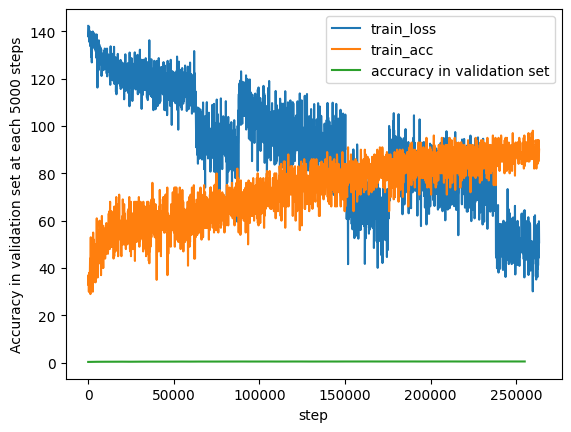

In [134]:
steps = [100*i for i in range(len(acc_array_distill))]
plt.plot(steps, loss_array_distill, label='train_loss')
plt.plot(steps, acc_array_distill, label='train_acc')

plt.xlabel("step")
plt.ylabel("Total accuracy per 100 steps")

# plt.plot(validationEpoch_loss,label='val_loss')
plt.legend()
plt.show

steps = [5000*i for i in range(len(eval_results_distill))]
eval_results_distill = np.array(eval_results_distill)
# plt.plot(steps, loss_array, label='train_loss')
plt.plot(steps, eval_results_distill/len(data_points["validation"]), label='accuracy in validation set')

plt.xlabel("step")
plt.ylabel("Accuracy in validation set at each 5000 steps")

# plt.plot(validationEpoch_loss,label='val_loss')
plt.legend()
plt.show

In [138]:
for i in range(3):
    model_small_distill_at_epoch = f"model/flant5_small_lr_10-4_race_distill_epoch{i}"
    model_distill = AutoModelForSeq2SeqLM.from_pretrained(model_small_distill_at_epoch, local_files_only=True).to(device)
    small_model_test_accuracy_epoch = evaluate(model_distill, test_input_ids, test_labels)
    print(f"After epoch {i+1}, accuracy is {small_model_test_accuracy_epoch/len(test_input_ids)}")

  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 1, accuracy is 0.5188488042156465


  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 2, accuracy is 0.5358735306039725


  0%|          | 0/4934 [00:00<?, ?it/s]

After epoch 3, accuracy is 0.5342521280907986


In [139]:
for i in range(3):
    model_small_distill_at_epoch = f"model/flant5_small_lr_10-4_race_distill_epoch{i}"
    model_distill = AutoModelForSeq2SeqLM.from_pretrained(model_small_distill_at_epoch, local_files_only=True).to(device)
    small_model_test_accuracy_epoch = evaluate(model_distill, validation_input_ids, validation_labels)
    print(f"After epoch {i+1}, accuracy is {small_model_test_accuracy_epoch/len(validation_input_ids)}")

  0%|          | 0/4887 [00:00<?, ?it/s]

After epoch 1, accuracy is 0.5232248823409045


  0%|          | 0/4887 [00:00<?, ?it/s]

After epoch 2, accuracy is 0.5387763454061797


  0%|          | 0/4887 [00:00<?, ?it/s]

After epoch 3, accuracy is 0.5455289543687334


<function matplotlib.pyplot.show(close=None, block=None)>

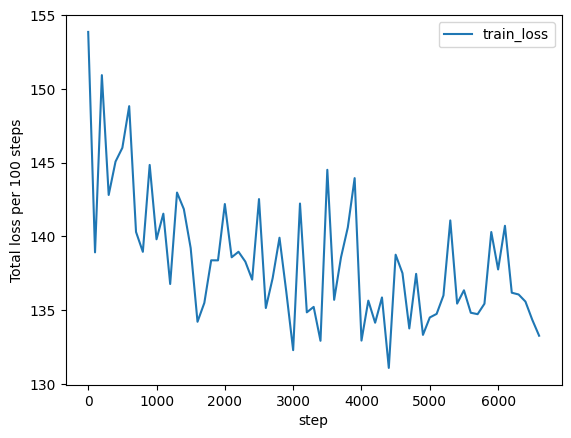

In [189]:
from matplotlib import pyplot as plt
steps = [100*i for i in range(len(loss_array_distill))]
plt.plot(steps, loss_array_distill, label='train_loss')
plt.xlabel("step")
plt.ylabel("Total loss per 100 steps")

# plt.plot(validationEpoch_loss,label='val_loss')
plt.legend()
plt.show

In [190]:
model_distill.eval()
model_distill_outputs = []
labels = tokenized_datasets["test"]['answerKey']

for i in range(0, len(input_ids)):
        # print(input_ids[i])
    
        test_tensor = torch.unsqueeze(torch.tensor(input_ids[i]), 0).to(device)
        preds = model_distill(input_ids=test_tensor, decoder_input_ids=torch.tensor([[model1.config.decoder_start_token_id,]]).to(device))      
        preds_prob = []
        for t in ans_id_dict.keys():
            preds_prob.append(torch.nn.functional.softmax(preds.logits, dim=-1)[...,t][0][0].item())
            
        model_distill_outputs.append(index_to_ans[np.argmax(preds_prob)])
        
result_distill = 0
for i in range(min(len(model_distill_outputs), len(labels))):
    if model_distill_outputs[i] == labels[i] or ans_to_index[model_distill_outputs[i]] == labels[i]:
        result_distill += 1
result_distill

956

In [192]:
# torch.save(model.state_dict(), "model/flant5_small_lr_10-5_qa_distill_match_large_output_abcd")
# model_distill.save_pretrained("model/flant5_small_lr_10-5_qa_distill_match_large_output_abcd")


In [5]:
from copy import deepcopy
from tqdm import tqdm
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data

def variable(t: torch.Tensor, use_cuda=True, **kwargs):
    if torch.cuda.is_available() and use_cuda:
        t = t.cuda()
    return t


class EWC(object):
    def __init__(self, model: nn.Module, dataset:torch.utils.data.DataLoader):

        self.model = model
        self.dataset = dataset

        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}
        self._means = {}
        self._precision_matrices = self._diag_fisher()

        for n, p in deepcopy(self.params).items():
            self._means[n] = variable(p.data)

    def _diag_fisher(self):
        precision_matrices = {}
        for n, p in deepcopy(self.params).items():
            p.data.zero_()
            precision_matrices[n] = variable(p.data)

        self.model.eval()
        for input in self.dataset:
            self.model.zero_grad()
            input = variable(input)
            output = self.model(input).view(1, -1)
            label = output.max(1)[1].view(-1)
            loss = F.nll_loss(F.log_softmax(output, dim=1), label)
            loss.backward()

            for n, p in self.model.named_parameters():
                precision_matrices[n].data += p.grad.data ** 2 / len(self.dataset)

        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            _loss = self._precision_matrices[n] * (p - self._means[n]) ** 2
            loss += _loss.sum()
        return loss


def normal_train(model: nn.Module, optimizer: torch.optim, data_loader: torch.utils.data.DataLoader):
    model.train()
    epoch_loss = 0
    for input, target in data_loader:
        input, target = variable(input), variable(target)
        optimizer.zero_grad()
        output = model(input)
        loss = F.cross_entropy(output, target)
        epoch_loss += loss.data[0]
        loss.backward()
        optimizer.step()
    return epoch_loss / len(data_loader)


def ewc_train(model: nn.Module, optimizer: torch.optim, data_loader: torch.utils.data.DataLoader,
              ewc: EWC, importance: float):
    model.train()
    loss_per_100 = 0
    loss_array = []
    c = 0
    progress_bar = tqdm(range(data_loader))
    for input, target in data_loader:
        input, target = variable(input), variable(target)
        optimizer.zero_grad()
        output = model(input)
        loss = F.cross_entropy(output, target) + importance * ewc.penalty(model)
        loss_per_100 += loss.item()
        if c%100==99:
            print(loss_per_100)
            loss_array.append(loss_per_100)
            loss_per_100 = 0
        loss.backward()
        optimizer.step()
        progress_bar.update(1)
        c += 1
    return epoch_loss / len(data_loader)

ModuleNotFoundError: No module named 'utils'

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_small).to(device)


In [ ]:
model_1_best = AutoModelForSeq2SeqLM.from_pretrained(model_small).to(device)

In [ ]:
progress_bar = tqdm(range(num_training_steps))

model_1_best.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        highest_prob_index = np.argmax(batch['labels'][0])
        labels = [0.0] * len(batch['labels'][0])
        labels[highest_prob_index] = 1.0
        labels = torch.tensor(labels).to(device)
        batch = batch['input_ids'].to(device)
        outputs = model_1_best(batch, decoder_input_ids=torch.tensor([[0]]).to(device))
        loss_fct = torch.nn.CrossEntropyLoss()
        logits = outputs.get("logits")
        preds_prod = []
        for i in range(1):
            pred_prob = []
            for t in ans_id_dict.keys():
                pred_prob.append(logits[..., t][0][0].item())
            preds_prod.append(pred_prob)
        preds = torch.tensor(preds_prod[0]).to("cuda")
        loss = loss_fct(preds, labels)
        loss.requires_grad_()
        
        # loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)


In [ ]:
model_1_best.eval()
input_ids = tokenized_datasets["test"]["input_ids"]
labels = tokenized_datasets["test"]['answerKey']
model_1_best_outputs = []
probability_1_best_output = []
for i in range(0, len(input_ids)):
        # print(input_ids[i])
    
        test_tensor = torch.unsqueeze(torch.tensor(input_ids[i]), 0).to(device)
        preds = model_1_best(input_ids=test_tensor, decoder_input_ids=torch.tensor([[model1.config.decoder_start_token_id,]]).to(device))      
        preds_prob = []
        for t in ans_id_dict.keys():
            preds_prob.append(torch.nn.functional.softmax(preds.logits, dim=-1)[...,t][0][0].item())
            
        model_1_best_outputs.append(index_to_ans[np.argmax(preds_prob)])
        probability_1_best_output.append(preds_prob)
        
result = 0
for i in range(min(len(model_1_best_outputs), len(labels))):
    if model_1_best_outputs[i] == labels[i] or ans_to_index[model_1_best_outputs[i]] == labels[i]:
        result += 1
result

In [ ]:
probability_1_best_output